## Imports

In [39]:
import pandas as pd
import math
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.animation as animation
from matplotlib.patches import Rectangle
from matplotlib.colors import LogNorm
import scipy
from scipy import stats
from scipy.signal import welch, stft, spectrogram
from scipy.stats import chi2
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import os
from datetime import datetime, timedelta
import re
import pywt
from numpy.fft import rfft, rfftfreq
import copy
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
from IPython.display import clear_output

mpl.rcParams['agg.path.chunksize'] = 10000000

## Definitions

In [40]:
def is_number(s):
    # Define a regex pattern to match positive, negative, and decimal numbers
    number_pattern = re.compile(r'^-?(\d+(\.\d*)?|\.\d+)$')
    
    # Use the pattern to check if the string matches
    return bool(number_pattern.match(s))

def truncate_microseconds(dt_str):
    # Split the time string at the decimal point
    if '.' in dt_str:
        time_part, microseconds_part = dt_str.split('.')
        # Truncate to only the first six digits of microseconds
        truncated_microseconds_part = microseconds_part[:6]
        truncated_dt_str = f"{time_part}.{truncated_microseconds_part}"
        return truncated_dt_str
    return dt_str

net_AE_time_adjust_from_file = 0.0

## Load Data

### Load Mistras Hits Data

In [41]:
Mistras_filepath = ""
while True:
    Mistras_filepath = input("Please enter the absolute filepath of your Mistras .txt file (Enter 'None' to skip Mistras import): ")
    Mistras_filepath = Mistras_filepath.strip('"')

    if os.path.isfile(Mistras_filepath):
        print("\nMistras Data Filepath: ", f"\"{Mistras_filepath}\"")
        break
    print("\nThe specified file does not exist. Please check the path and try again.")
    
def get_mistras_metadata(filepath, df):
    metadata = {}
    
    # This regex pattern matches a time format and optionally captures microseconds if present
    time_pattern = re.compile(r'\b(\d{2}:\d{2}:\d{2})(?:\.(\d+))?\b')
    
    with open(filepath, 'r') as file:
        for line in file:
            match = re.search(time_pattern, line)
            if match:
                time_str = match.group(1)  # Time in HH:MM:SS
                microseconds_str = match.group(2) if match.group(2) else '000000'  # Microseconds part if present, else '0'
                break
        else:
            # Handle case where no time is found
            return None

    # Append microseconds to the time string and parse
    full_time_str = f"{time_str}.{microseconds_str}"
    time_obj = datetime.strptime(full_time_str, "%H:%M:%S.%f")

    metadata['start_time'] = time_obj
    metadata['duration'] = df['SSSSSSSS.mmmuuun'].iloc[-1]
    return metadata

def import_mistras_file_to_df(filepath):
    # Read the data using read_csv, assuming tab-separated values (TSV); adjust delimiter if needed
    df = pd.read_csv(filepath, sep='\s+', header=4)
    # There is a bad import on the 'SIG STRNGTH col because it has a space in the name and the file is whitespace-delimted
    column_names_AE_Node = [
        'ID', 'SSSSSSSS.mmmuuun', 'CH', 'RISE', 'COUN', 'ENER', 
        'DURATION', 'AMP', 'A-FRQ', 'RMS', 'ASL', 'PCNTS', 'THR', 'R-FRQ', 
        'I-FRQ', 'SIG STRNGTH', 'ABS-ENERGY'
    ]
    column_names_EasyAE = [
        'ID', 'SSSSSSSS.mmmuuun', 'PARA1', 'CH', 
        'RISE', 'COUN', 'ENER', 
        'DURATION', 'A-FRQ', 'RMS', 'PCNTS', 'THR', 'R-FRQ', 
        'I-FRQ', 'SIG STRNGTH', 'ABS-ENERGY', 'FRQ-C', 'P-FRQ', 'AMP', 'ASL'
    ]
    column_names = column_names_EasyAE
    # Keep all columns except the last one
    df = df.iloc[:, :-1]
    df.columns = column_names
    # Remove rows where any value is not a float
    # Attempt to convert all values to float
    df = df.apply(pd.to_numeric, errors='coerce')

    # Drop rows with any NaNs (i.e., conversion failures)
    df = df.dropna(how='any')

    return df

def process_mistras_df(df, metadata):
    # Drop 'ID' col
    df = df.drop('ID', axis=1)
    # Rename time col
    df.rename(columns={'SSSSSSSS.mmmuuun': 'TIME'}, inplace=True)
    
    # Add 'Absolute time' column to the data
    mistras_start_time_obj = metadata['start_time']
    seconds = df['TIME']
    time_deltas = pd.to_timedelta(seconds, unit='s')
    absolute_time = mistras_start_time_obj + time_deltas
    df.insert(0, 'Absolute Time', absolute_time)
    
    return df

mistras_df = import_mistras_file_to_df(Mistras_filepath)
mistras_metadata = get_mistras_metadata(Mistras_filepath, mistras_df)
mistras_df = process_mistras_df(mistras_df, mistras_metadata)
print("Start time:", mistras_metadata['start_time'])
print("Duration: " + str(mistras_metadata['duration']) + " s")

display(mistras_df)

amp_type_counts = mistras_df['AMP'].apply(lambda x: type(x).__name__).value_counts()
print("Type counts in 'AMP' column:")
print(amp_type_counts)
mistras_df_times_synchronized = False
hits_inserted = False


Mistras Data Filepath:  "C:\Users\sapierso\Box\PD-Acoustic Project Data\0_FormattedData\PD-acoustic170\PD-acoustic170_hits.TXT"
Start time: 1900-01-01 11:20:31
Duration: 147.0623375 s


Absolute Time        TIME   PARA1  CH  RISE  COUN  ENER  \
0     1900-01-01 11:20:34.839524500    3.839525  0.0177   1    10     1     0   
1     1900-01-01 11:20:34.840472500    3.840473  0.0179   1   135     3     1   
2     1900-01-01 11:20:34.841520500    3.841521  0.0182   1   316     6     3   
3     1900-01-01 11:20:34.843313500    3.843313  0.0179   1    33     1     0   
4     1900-01-01 11:20:34.843932500    3.843933  0.0183   1   330     5     2   
...                             ...         ...     ...  ..   ...   ...   ...   
13395 1900-01-01 11:22:57.878153500  146.878153  0.0180   1     2     2     0   
13396 1900-01-01 11:22:57.894894500  146.894894  0.0180   1     1     1     0   
13397 1900-01-01 11:22:57.945103500  146.945103  0.0180   1     3     1     0   
13398 1900-01-01 11:22:57.978608500  146.978609  0.0182   1     1     1     0   
13399 1900-01-01 11:22:58.062337500  147.062338  0.0182   1     3     1     0   

       DURATION  A-FRQ  RMS  PCNTS  THR  R-FRQ  I-FRQ  SIG STRNGTH  \
0           185      5  0.0      1   31      0    100      2367.00   
1           396      8  0.0      1   31      7      7      9168.00   
2           977      6  0.0      2   31      6      6     20975.00   
3           113      9  0.0      1   31      0     30      3239.00   
4           626      8  0.0      3   31      6      9     16644.00   
...         ...    ...  ...    ...  ...    ...    ...          ...   
13395       147     14  0.0      1   31      6    500      2638.00   
13396         1   1000  0.0      1   31      0   1000         0.00   
13397         4    250  0.0      1   31      0    333       112.85   
13398         1   1000  0.0      1   31      0   1000       112.85   
13399        11     91  0.0      1   31      0    333       393.45   

       ABS-ENERGY  FRQ-C  P-FRQ   AMP   ASL  
0        5.848000    101      7  32.2  18.0  
1       30.250000     74      6  34.5  18.1  
2       76.653000     78      6  36.5  18.1  
3       13.247000     88      3  35.1  18.1  
4       67.854000     68      7  37.5  18.1  
...           ...    ...    ...   ...   ...  
13395    7.320000     98      7  32.6  21.1  
13396    0.000000    106     23  31.0  21.0  
13397    0.442225    109      7  31.9  20.7  
13398    0.000000    111      5  31.0  20.6  
13399    1.711000    112      8  33.2  20.3  

[13400 rows x 20 columns]

Type counts in 'AMP' column:
AMP
float    13400
Name: count, dtype: int64


### Load Mistras Time-Driven Data

In [42]:
Mistras_tdd_filepath = ""
while True:
    Mistras_tdd_filepath = input("Please enter the absolute filepath of your Mistras TDD .txt file (Enter 'None' to skip import): ")
    Mistras_tdd_filepath = Mistras_tdd_filepath.strip('"')
    print("\nMistras TDD Data Filepath: ", repr(Mistras_tdd_filepath))

    if os.path.isfile(Mistras_tdd_filepath):
        break
    print("\nThe specified file does not exist. Please check the path and try again.")

def get_mistras_metadata(filepath, df):
    metadata = {}
    
    # This regex pattern matches a time format and optionally captures microseconds if present
    time_pattern = re.compile(r'\b(\d{2}:\d{2}:\d{2})(?:\.(\d+))?\b')
    
    with open(filepath, 'r') as file:
        for line in file:
            match = re.search(time_pattern, line)
            if match:
                time_str = match.group(1)  # Time in HH:MM:SS
                microseconds_str = match.group(2) if match.group(2) else '000000'  # Microseconds part if present, else '0'
                break
        else:
            # Handle case where no time is found
            return None

    # Append microseconds to the time string and parse
    full_time_str = f"{time_str}.{microseconds_str}"
    time_obj = datetime.strptime(full_time_str, "%H:%M:%S.%f")

    metadata['start_time'] = time_obj
    metadata['duration'] = df['SSSSSSSS.mmmuuun'].iloc[-1]
    return metadata

def parse_tdd_data(file_path):
    # Initialize lists to store data
    timestamps = []
    rms = []
    asl = []
    thr = []
    abs_energy = []
    
    # Open and read the file
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('  2 '):
                # Extract timestamp
                timestamp = float(line.split()[1])
                timestamps.append(timestamp)
                
                # Read the next two lines
                _ = next(file)  # Skip the "CH:[    RMS ASL THR  ABS-ENERGY]" line
                channel_data = next(file).strip()
                
                # Extract channel data
                data = channel_data.split('[')[-1].split(']')[0].split()
                rms.append(float(data[0]))
                asl.append(float(data[3]))
                thr.append(float(data[1]))
                abs_energy.append(float(data[2]))
    
    # Create DataFrame
    df = pd.DataFrame({
        'SSSSSSSS.mmmuuun': timestamps,
        'RMS_CONTINUOUS': rms,
        'THR_CONTINUOUS': thr,
        'ABS_ENERGY_CONTINUOUS': abs_energy,
        'ASL_CONTINUOUS': asl,
    })
    
    return df

def process_mistras_tdd_df(df, metadata):
    # Rename time col
    df.rename(columns={'SSSSSSSS.mmmuuun': 'TIME'}, inplace=True)
    
    # Add 'Absolute time' column to the data
    mistras_start_time_obj = metadata['start_time']
    seconds = df['TIME']
    time_deltas = pd.to_timedelta(seconds, unit='s')
    absolute_time = mistras_start_time_obj + time_deltas
    df.insert(0, 'Absolute Time', absolute_time)
    
    return df

mistras_tdd_df = None
mistras_tdd_df = parse_tdd_data(Mistras_tdd_filepath)
mistras_tdd_metadata = get_mistras_metadata(Mistras_tdd_filepath, mistras_tdd_df)
mistras_tdd_df = process_mistras_tdd_df(mistras_tdd_df, mistras_tdd_metadata)
print("Start time:", mistras_tdd_metadata['start_time'])
print("Duration: " + str(mistras_tdd_metadata['duration']) + " s")
display(mistras_tdd_df)
mistras_tdd_df_times_synchronized = False


Mistras TDD Data Filepath:  'C:\\Users\\sapierso\\Box\\PD-Acoustic Project Data\\0_FormattedData\\PD-acoustic170\\PD-acoustic170_time.TXT'
Start time: 1900-01-01 11:20:31
Duration: 163.230284 s


Absolute Time        TIME  RMS_CONTINUOUS  THR_CONTINUOUS  \
0     1900-01-01 11:20:31.010084    0.010084             0.0            31.0   
1     1900-01-01 11:20:31.020084    0.020084             0.0            31.0   
2     1900-01-01 11:20:31.030084    0.030084             0.0            31.0   
3     1900-01-01 11:20:31.040084    0.040084             0.0            31.0   
4     1900-01-01 11:20:31.050084    0.050084             0.0            31.0   
...                          ...         ...             ...             ...   
16318 1900-01-01 11:23:14.190284  163.190284             0.0            31.0   
16319 1900-01-01 11:23:14.200284  163.200284             0.0            31.0   
16320 1900-01-01 11:23:14.210284  163.210284             0.0            31.0   
16321 1900-01-01 11:23:14.220284  163.220284             0.0            31.0   
16322 1900-01-01 11:23:14.230284  163.230284             0.0            31.0   

       ABS_ENERGY_CONTINUOUS  ASL_CONTINUOUS  
0                      0.000             0.1  
1                     42.313            16.2  
2                     32.770            17.0  
3                     33.186            17.3  
4                     31.813            17.5  
...                      ...             ...  
16318                 35.551            18.2  
16319                 30.679            18.2  
16320                 29.202            18.2  
16321                 34.717            18.2  
16322                 33.434            18.2  

[16323 rows x 6 columns]

### Load EasyAE Streamed Waveforms

In [112]:
# Ask for folder_path
while True:
    folder_path = input("Enter the absolute path to waveforms …").strip('"')
    if os.path.isdir(folder_path):
        break
    print("Invalid directory. Try again.")

print(f"Using folder: \"{folder_path}\"")

Using folder: "C:\Users\sapierso\Box\PD-Acoustic Project Data\0_FormattedData\PD-acoustic170\PD-acoustic170_wfms"


In [44]:
# Build & sort CSV-file list up front
def sort_key(fn):
    base = os.path.splitext(fn)[0]
    parts = base.split('_')
    try:
        return int(parts[-2])
    except:
        return 0

csv_files = sorted(
    [f for f in os.listdir(folder_path) if f.lower().endswith('.csv')],
    key=sort_key
)

# Try loading the pickle, otherwise build & cache
base_name     = os.path.basename(folder_path)
pickle_file   = os.path.join(folder_path, base_name + '_combined.pkl')

if os.path.isfile(pickle_file):
    print("Loading cached array…")
    with open(pickle_file, 'rb') as pf:
        loaded_item = pickle.load(pf)

    if isinstance(loaded_item, dict):
        # already in the new format
        combined_wfm_data      = loaded_item['combined_data']
        sample_interval    = loaded_item['sample_interval']
        stream_start_time  = loaded_item['start_time']
        wfm_stream_metadata = {
            'combined_data': combined_wfm_data,
            'sample_interval': sample_interval,
            'start_time': stream_start_time,
        }

    elif isinstance(loaded_item, np.ndarray):
        # --- NEW: bring the old array forward into the new-dict format ---
        combined_wfm_data = loaded_item

        if csv_files:
            # re-extract sample_interval & start_time from first CSV
            first_csv = os.path.join(folder_path, csv_files[0])
            with open(first_csv, 'r') as f:
                header = [next(f) for _ in range(12)]
            sample_interval = float(header[3].split(':')[-1].strip())
            stream_start_time_str = header[2].split(' ')[-1].strip()
            stream_start_time = datetime.strptime(stream_start_time_str, "%H:%M:%S")
        else:
            # If no CSV files, set defaults
            sample_interval = 1e-6  # Default to 1 microsecond
            stream_start_time = mistras_metadata['start_time']  # Default to time from Mistras metadata

        # build the dict
        wfm_stream_metadata = {
            'combined_data': combined_wfm_data,
            'sample_interval': sample_interval,
            'start_time': stream_start_time,
        }

        # save it right back
        print("Upgrading pickle to new format…")
        with open(pickle_file, 'wb') as pf:
            pickle.dump(wfm_stream_metadata, pf)
        print("Re‐saved pickle with metadata.")
else:
    # Always pull sample_interval from first csv file
    first_csv = os.path.join(folder_path, csv_files[0])
    with open(first_csv, 'r') as f:
        header = [next(f) for _ in range(12)]
    sample_interval = float(header[3].split(':')[-1].strip())
    print("Sample interval (s):", sample_interval)
    stream_start_time_str = header[2].split(' ')[-1].strip()
    stream_start_time = datetime.strptime(stream_start_time_str, "%H:%M:%S")
    print("Stream start time:", stream_start_time)
    wfm_stream_metadata = {
        'sample_interval': sample_interval,
        'start_time': stream_start_time,
    }

    data_list = []
    for fn in tqdm(csv_files, desc="Reading CSVs"):
        path = os.path.join(folder_path, fn)
        arr  = np.loadtxt(path, delimiter=',', skiprows=12)
        data_list.append(arr)
    combined_wfm_data = np.vstack(data_list)
    wfm_stream_metadata['combined_data'] = combined_wfm_data
    print("Saving cache…")
    with open(pickle_file, 'wb') as pf:
        pickle.dump(wfm_stream_metadata, pf)

print("combined_data shape:", combined_wfm_data.shape)
waveform_times_synchronized = False

Loading cached array…
combined_data shape: (160873947, 2)


### Load MPD CSV Data

In [45]:
MPD_filepath = ""
while True:
    MPD_filepath = input("Please enter the absolute filepath of your MPD .csv file (Enter 'None' to skip import): ")
    MPD_filepath = MPD_filepath.strip('"')
    print("\nMPD csv Filepath: ", repr(MPD_filepath))

    if os.path.isfile(MPD_filepath):
        break
    print("\nThe specified file does not exist. Please check the path and try again.")

def extract_time_from_MPD_filename(filename):
    basename = os.path.basename(filename)
    pattern = r'(\d{2})h(\d{2})m(\d{2})s\.csv$'
    match = re.search(pattern, basename)
    if match:
        hours, minutes, seconds = match.groups()
        return int(hours), int(minutes), int(seconds)
    else:
        raise ValueError("Filename does not match the expected pattern 'HHhMMmSSs.csv'.")
    
def get_time_object(hours, minutes, seconds):
    return datetime(1900, 1, 1, hour=hours, minute=minutes, second=seconds)
    
def get_MPD_csv_metadata(filename, df):
    metadata = {}
    hours, minutes, seconds = extract_time_from_MPD_filename(filename)
    metadata['start_time'] = get_time_object(hours, minutes, seconds)
    metadata['duration'] = df["Time [s]"].iloc[-1]
    return metadata

def parse_MPD_csv_content(filepath, delimiter=';'):
    df = pd.read_csv(filepath, delimiter=delimiter, skiprows=1)
    return df

def process_MPD_df(df, metadata):
    # Add 'Absolute time' column to the data
    mistras_start_time_obj = metadata['start_time']
    seconds = df['Time [s]']
    time_deltas = pd.to_timedelta(seconds, unit='s')
    absolute_time = mistras_start_time_obj + time_deltas

    # Convert C to pc and rename column
    df.insert(0, 'Absolute Time', absolute_time)
    df.rename(columns={'IEC 60270 Apparent Charge (Q_IEC/WTD) [C]': 'IEC 60270 Apparent Charge (Q_IEC/WTD) [pC]'}, inplace=True)
    df['IEC 60270 Apparent Charge (Q_IEC/WTD) [pC]'] *= 1e12

    return df

MPD_df = parse_MPD_csv_content(MPD_filepath)
MPD_metadata = get_MPD_csv_metadata(MPD_filepath, MPD_df)
MPD_df = process_MPD_df(MPD_df, MPD_metadata)
print("Start time:", MPD_metadata['start_time'])
print("Duration: " + str(MPD_metadata['duration']) + " s")
display(MPD_df)


MPD csv Filepath:  'C:\\Users\\sapierso\\Box\\PD-Acoustic Project Data\\0_FormattedData\\PD-acoustic170\\PD-acoustic170-2025-06-26_11h20m48s.csv'
Start time: 1900-01-01 11:20:48
Duration: 140.7 s


Absolute Time  Time [s]  \
0   1900-01-01 11:20:48.600       0.6   
1   1900-01-01 11:20:48.900       0.9   
2   1900-01-01 11:20:49.200       1.2   
3   1900-01-01 11:20:49.500       1.5   
4   1900-01-01 11:20:49.800       1.8   
..                      ...       ...   
463 1900-01-01 11:23:07.500     139.5   
464 1900-01-01 11:23:07.800     139.8   
465 1900-01-01 11:23:08.100     140.1   
466 1900-01-01 11:23:08.400     140.4   
467 1900-01-01 11:23:08.700     140.7   

     IEC 60270 Apparent Charge (Q_IEC/WTD) [pC]  AC Input RMS Voltage [V]  \
0                                      8.262836                 87.267097   
1                                      7.927818                 87.311471   
2                                      7.945859                 87.270170   
3                                      8.204367                 87.244928   
4                                      8.222457                 87.268196   
..                                          ...                       ...   
463                                    8.258413                 75.044601   
464                                    8.240208                 75.350040   
465                                    7.896966                 75.604104   
466                                    7.921551                 75.828322   
467                                    7.929839                 76.126125   

     AC Input Peak Voltage / Sqrt(2) [V]  AC Input signal frequency [Hz]  \
0                              87.264621                       59.986146   
1                              87.278306                       59.986740   
2                              87.256620                       59.986752   
3                              87.246307                       59.986617   
4                              87.237246                       59.986221   
..                                   ...                             ...   
463                            75.970246                       60.005956   
464                            76.288734                       60.006022   
465                            76.561242                       60.006736   
466                            76.781873                       60.007084   
467                            77.079515                       60.006762   

     total PD Rate [Pulses/s]  PD Rate relevant for Q_IEC/WTD [Pulses/s]  \
0               186368.289158                                  53.130402   
1               187353.699566                                  77.523399   
2               186740.668515                                  77.729027   
3               187494.175466                                  63.823193   
4               186089.154377                                  65.585030   
..                        ...                                        ...   
463             187908.954925                                  57.543240   
464             189173.621541                                  53.521500   
465             144030.242066                                  74.582542   
466             191840.654649                                  73.847626   
467             191320.121112                                  74.306770   

     Maximum Charge of PD events in interval [C]  \
0                                   3.713254e-10   
1                                   3.713254e-10   
2                                   3.713254e-10   
3                                   3.713254e-10   
4                                   3.713254e-10   
..                                           ...   
463                                 2.319454e-11   
464                                 2.169113e-11   
465                                 1.704619e-11   
466                                 1.704619e-11   
467                                 1.704619e-11   

     Quadratic Rate D (from IEC 60270) [C²/s]  Average charge in interval [C]  \
0                                5.537345e-19                   

### Load PD Data

In [46]:
def import_pd_data(folder: str, q_unit: str) -> np.ndarray:
    """
    Import partial discharge data from a .PD file and return a single (N×2) array.

    Each 12-byte record contains:
      • bytes 0–3: float32 measurement q
      • bytes 4–11: float64 timestamp q_tm

    Args:
        folder: Path to the directory containing the .PD file.
        q_unit: Base filename (without “.PD”) to open.

    Returns:
        data: NumPy array of shape (N, 2), where
              data[:, 0] == q_tm (float64),
              data[:, 1] == q    (float32).
    """
    path = os.path.join(folder, f"{q_unit}.PD")
    if not os.path.isfile(path):
        raise FileNotFoundError(f"No such file: {path}")

    # Read entire file
    with open(path, 'rb') as f:
        raw = f.read()

    L = len(raw)
    n_records = L // 12
    buf = np.frombuffer(raw, dtype=np.uint8, count=n_records*12)
    recs = buf.reshape(n_records, 12)

    # Extract measurement q (float32 from bytes 0–3)
    q = recs[:, 0:4].view('<f4').ravel()
    # Extract time   q_tm (float64 from bytes 4–11)
    q_tm = recs[:, 4:12].view('<f8').ravel()

    # Stack into one (N,2) array: [time, measurement]
    data = np.column_stack((q_tm, q))
    return data

# Ask the user for a path (e.g. C:\Users\you\Documents\report.pdf)
filepath_str = input("Enter the full filepath to your (.PD) file: ").strip().strip('"')

# Convert the string to a Path object
filepath = Path(filepath_str)

# Extract the directory (parent) and the file name separately
folder   = filepath.parent          # PosixPath or WindowsPath object
filename = filepath.name            # Just the file’s name with extension

print(f"Folder : {folder}")
print(f"Filename: {filename}")

pd_data = import_pd_data(
    folder=folder,
    q_unit=filename.removesuffix('.PD')  # Remove the ".PD" extension
)
print(pd_data)           # prints the full [time, measurement] array
print(pd_data.shape)     # e.g. (123456, 2)

Folder : C:\Users\sapierso\Box\PD-Acoustic Project Data\0_FormattedData\PD-acoustic170\170
Filename: MPD 800 2.1.1-20250626_11h20m47s850ms.PD
[[8.42752893e-01 1.46849221e-12]
 [8.42759981e-01 8.97135664e-13]
 [8.42764141e-01 1.21002655e-12]
 ...
 [1.41171700e+02 1.02357055e-12]
 [1.41171703e+02 7.56841746e-13]
 [1.41171707e+02 6.03286518e-13]]
(25275542, 2)


### Get the primary folder name

In [ ]:
# Retrieve the parent directory name of the wfms folder
parent_dir = os.path.dirname(folder_path)
parent_name = os.path.basename(parent_dir)  # "PD-acoustic170"

# Create "images" folder inside PD-acousticXXX if it doesn't exist already
images_dir = os.path.join(parent_dir, "images")
os.makedirs(images_dir, exist_ok=True)

print(parent_name)
print(f"\"{images_dir}\"")

PD-acoustic170
"C:\Users\sapierso\Box\PD-Acoustic Project Data\0_FormattedData\PD-acoustic170\images"


## Process/Synchronize Data

In [47]:
class ArgumentConflict(Exception):
    def __init__(self, message="The arguments in this function overdefine the method"):
        self.message = message
        super().__init__(self.message)

# Post-process the merged dataset to calculate the # of hits
def count_ae_hits(df, n_bins=None, time_delta=None):
    if n_bins is not None and time_delta is not None:
        raise ArgumentConflict
    elif time_delta is not None and n_bins is None:
        n_bins = math.floor(df['TIME'].max() / time_delta)
    elif n_bins is not None and time_delta is None:
        time_delta = df['TIME'].max() / n_bins
    n_hits = []
    for start_time in range(0, math.floor(df['TIME'].max())-1, time_delta):
        end_time = start_time + time_delta
        # Selecting the subsection
        subsection = df[(df['TIME'] >= start_time) & (df['TIME'] < end_time)]
        # Count non-NaN entries in the 'Data' column
        count_non_nan = subsection['RISE'].notna().sum()
        n_hits.append(count_non_nan)
        # print(f"Time from {start_time} to {end_time} seconds: {count_non_nan} non-NaN values")
    hits = np.array(n_hits).astype(float)
    increments = np.arange(time_delta, time_delta * (n_bins), time_delta).astype(float)
    hits_df = pd.DataFrame({
        'TIME': increments,
        'Hits': hits
    })
    return hits_df

def adjust_df_relative_time(df, true_start_time, df_start_time, time_col_name='Time [s]'):
    df[time_col_name] = df[time_col_name] - (true_start_time - df_start_time).total_seconds()
    return df

MPD_mistras_file_time_diff = (MPD_metadata['start_time'] - mistras_metadata['start_time']).total_seconds()
print(f"MPD file starts {MPD_mistras_file_time_diff} seconds after Mistras hits file starts.")

# Adjust the time column of combined_data to be relative to the MPD file start time
MPD_wfm_file_time_diff = (MPD_metadata['start_time'] - wfm_stream_metadata['start_time']).total_seconds()
print(f"MPD file starts {MPD_wfm_file_time_diff} seconds after Waveform file starts.")

if not hits_inserted:
    # Insert hits into the mistras_df DataFrame
    hits = count_ae_hits(mistras_df, time_delta=1)
    mistras_df = pd.merge_asof(left=mistras_df, right=hits, on='TIME', direction='backward')
    hits_inserted = True

if not mistras_df_times_synchronized:
    # Adjust the time columns in the mistras_df DataFrame to be relative to the MPD file start time
    mistras_df = adjust_df_relative_time(mistras_df, MPD_metadata['start_time'], mistras_metadata['start_time'], time_col_name='TIME')
    mistras_df_times_synchronized = True

if not mistras_tdd_df_times_synchronized:
    # Adjust the time columns in the mistras_df and mistras_tdd_df DataFrames to be relative to the MPD file start time
    mistras_tdd_df = adjust_df_relative_time(mistras_tdd_df, MPD_metadata['start_time'], mistras_tdd_metadata['start_time'], time_col_name='TIME')
    mistras_tdd_df_times_synchronized = True

if not waveform_times_synchronized:
    # Adjust the time column of combined_wfm_data to be relative to the MPD file start time
    combined_wfm_data[:, 0] = combined_wfm_data[:, 0] - MPD_wfm_file_time_diff
    waveform_times_synchronized = True

display(mistras_df)
print(combined_wfm_data)

MPD file starts 17.0 seconds after Mistras hits file starts.
MPD file starts 13.0 seconds after Waveform file starts.


Absolute Time        TIME   PARA1  CH  RISE  COUN  ENER  \
0     1900-01-01 11:20:34.839524500  -13.160476  0.0177   1    10     1     0   
1     1900-01-01 11:20:34.840472500  -13.159527  0.0179   1   135     3     1   
2     1900-01-01 11:20:34.841520500  -13.158480  0.0182   1   316     6     3   
3     1900-01-01 11:20:34.843313500  -13.156686  0.0179   1    33     1     0   
4     1900-01-01 11:20:34.843932500  -13.156067  0.0183   1   330     5     2   
...                             ...         ...     ...  ..   ...   ...   ...   
13395 1900-01-01 11:22:57.878153500  129.878153  0.0180   1     2     2     0   
13396 1900-01-01 11:22:57.894894500  129.894894  0.0180   1     1     1     0   
13397 1900-01-01 11:22:57.945103500  129.945103  0.0180   1     3     1     0   
13398 1900-01-01 11:22:57.978608500  129.978609  0.0182   1     1     1     0   
13399 1900-01-01 11:22:58.062337500  130.062338  0.0182   1     3     1     0   

       DURATION  A-FRQ  RMS  ...  THR  R-FRQ  I-FRQ  SIG STRNGTH  ABS-ENERGY  \
0           185      5  0.0  ...   31      0    100      2367.00    5.848000   
1           396      8  0.0  ...   31      7      7      9168.00   30.250000   
2           977      6  0.0  ...   31      6      6     20975.00   76.653000   
3           113      9  0.0  ...   31      0     30      3239.00   13.247000   
4           626      8  0.0  ...   31      6      9     16644.00   67.854000   
...         ...    ...  ...  ...  ...    ...    ...          ...         ...   
13395       147     14  0.0  ...   31      6    500      2638.00    7.320000   
13396         1   1000  0.0  ...   31      0   1000         0.00    0.000000   
13397         4    250  0.0  ...   31      0    333       112.85    0.442225   
13398         1   1000  0.0  ...   31      0   1000       112.85    0.000000   
13399        11     91  0.0  ...   31      0    333       393.45    1.711000   

       FRQ-C  P-FRQ   AMP   ASL   Hits  
0        101      7  32.2  18.0    0.0  
1         74      6  34.5  18.1    0.0  
2         78      6  36.5  18.1    0.0  
3         88      3  35.1  18.1    0.0  
4         68      7  37.5  18.1    0.0  
...      ...    ...   ...   ...    ...  
13395     98      7  32.6  21.1  213.0  
13396    106     23  31.0  21.0  213.0  
13397    109      7  31.9  20.7  213.0  
13398    111      5  31.0  20.6  213.0  
13399    112      8  33.2  20.3  213.0  

[13400 rows x 21 columns]

[[-1.30010240e+01 -6.10400000e-05]
 [-1.30010230e+01 -6.10400000e-05]
 [-1.30010220e+01 -6.10400000e-05]
 ...
 [ 1.47872920e+02 -1.22070000e-04]
 [ 1.47872921e+02 -6.10400000e-05]
 [ 1.47872922e+02  6.10400000e-05]]


In [48]:
print(hits_inserted)
print(mistras_df_times_synchronized)
print(mistras_tdd_df_times_synchronized)
print(waveform_times_synchronized)

True
True
True
True


In [49]:
print(f"Sampling Interval: {sample_interval} s")
sampling_frequency = 1 / sample_interval
print(f"Sampling Frequency: {sampling_frequency} Hz")

Sampling Interval: 1e-06 s
Sampling Frequency: 1000000.0 Hz


In [50]:
# Compute the spectrogram
spec_frequencies, spec_times, Sxx = spectrogram(combined_wfm_data[:, 1], sampling_frequency, nperseg=4096)
Sxx_log = 10 * np.log10(Sxx)

spec_times -= MPD_wfm_file_time_diff

In [51]:
min_spectrogram_value_ctrl = -150
max_spectrogram_value_ctrl = -95

max_frequency = 50e3
min_frequency = 0

frequency_mask = (spec_frequencies >= min_frequency) & (spec_frequencies <= max_frequency)
masked_spec_frequencies = spec_frequencies[frequency_mask]
masked_Sxx_log = Sxx_log[frequency_mask, :]

## Data Synchronization Preview

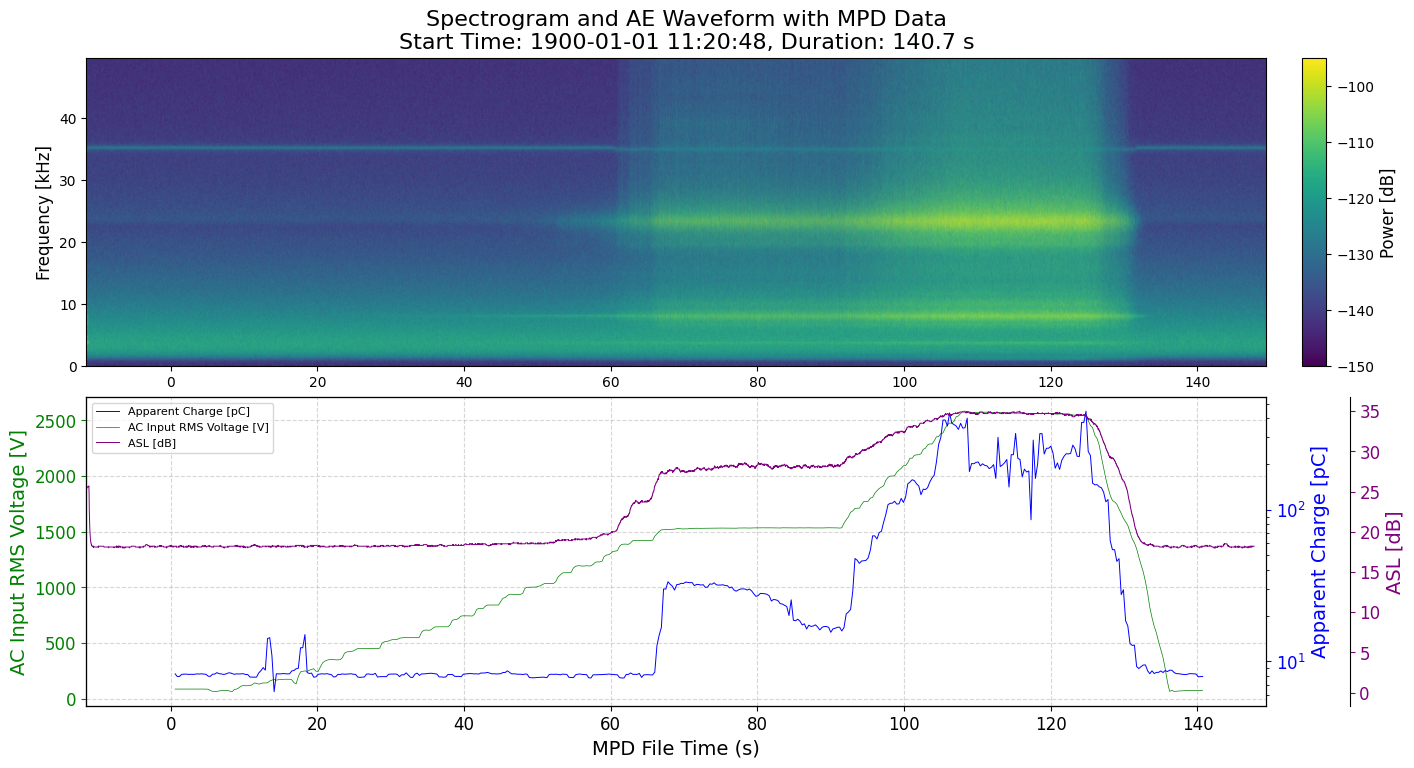

Final AE time adjust value: 1.5
-11.6604755
-15.489916000000001
-11.501024


Absolute Time        TIME   PARA1  CH  RISE  COUN  ENER  \
0     1900-01-01 11:20:34.839524500  -11.660476  0.0177   1    10     1     0   
1     1900-01-01 11:20:34.840472500  -11.659527  0.0179   1   135     3     1   
2     1900-01-01 11:20:34.841520500  -11.658480  0.0182   1   316     6     3   
3     1900-01-01 11:20:34.843313500  -11.656686  0.0179   1    33     1     0   
4     1900-01-01 11:20:34.843932500  -11.656067  0.0183   1   330     5     2   
...                             ...         ...     ...  ..   ...   ...   ...   
13395 1900-01-01 11:22:57.878153500  131.378153  0.0180   1     2     2     0   
13396 1900-01-01 11:22:57.894894500  131.394894  0.0180   1     1     1     0   
13397 1900-01-01 11:22:57.945103500  131.445103  0.0180   1     3     1     0   
13398 1900-01-01 11:22:57.978608500  131.478609  0.0182   1     1     1     0   
13399 1900-01-01 11:22:58.062337500  131.562338  0.0182   1     3     1     0   

       DURATION  A-FRQ  RMS  ...  THR  R-FRQ  I-FRQ  SIG STRNGTH  ABS-ENERGY  \
0           185      5  0.0  ...   31      0    100      2367.00    5.848000   
1           396      8  0.0  ...   31      7      7      9168.00   30.250000   
2           977      6  0.0  ...   31      6      6     20975.00   76.653000   
3           113      9  0.0  ...   31      0     30      3239.00   13.247000   
4           626      8  0.0  ...   31      6      9     16644.00   67.854000   
...         ...    ...  ...  ...  ...    ...    ...          ...         ...   
13395       147     14  0.0  ...   31      6    500      2638.00    7.320000   
13396         1   1000  0.0  ...   31      0   1000         0.00    0.000000   
13397         4    250  0.0  ...   31      0    333       112.85    0.442225   
13398         1   1000  0.0  ...   31      0   1000       112.85    0.000000   
13399        11     91  0.0  ...   31      0    333       393.45    1.711000   

       FRQ-C  P-FRQ   AMP   ASL   Hits  
0        101      7  32.2  18.0    0.0  
1         74      6  34.5  18.1    0.0  
2         78      6  36.5  18.1    0.0  
3         88      3  35.1  18.1    0.0  
4         68      7  37.5  18.1    0.0  
...      ...    ...   ...   ...    ...  
13395     98      7  32.6  21.1  213.0  
13396    106     23  31.0  21.0  213.0  
13397    109      7  31.9  20.7  213.0  
13398    111      5  31.0  20.6  213.0  
13399    112      8  33.2  20.3  213.0  

[13400 rows x 21 columns]

In [ ]:
manual_AE_time_adjust = 0
while True:
    label_fontsize = 12
    tick_fontsize = 10

    # Create a figure and GridSpec layout: left column for plots, right column for a narrower colorbar
    fig = plt.figure(figsize=(16, 8))
    gs = fig.add_gridspec(
        nrows=2,
        ncols=2,
        width_ratios=[0.98, 0.02],   # relative widths for plots, colorbar
        height_ratios=[1,1],        # Spectrogram row taller than waveform row
        hspace=0.10,
        wspace=0.06                  # Small horizontal gap between plots and colorbar
    )

    ax1 = fig.add_subplot(gs[0, 0])              # Top-left: spectrogram
    ax2 = fig.add_subplot(gs[1, 0])              # Bottom-left: trend plot
    cax = fig.add_subplot(gs[0, 1])              # Top-right: colorbar axis (aligned with spectrogram)

    # ==== Plot spectrogram on ax1 ====  
    xmin = spec_times[0] + manual_AE_time_adjust
    xmax = spec_times[-1] + manual_AE_time_adjust
    ymin = masked_spec_frequencies[0] / 1e3  # Convert to kHz
    ymax = masked_spec_frequencies[-1] / 1e3  # Convert to kHz

    spec_img = ax1.imshow(
        masked_Sxx_log,
        extent=[xmin, xmax, ymin, ymax],
        interpolation='bilinear',
        cmap='viridis',
        aspect='auto',
        vmin=min_spectrogram_value_ctrl,
        vmax=max_spectrogram_value_ctrl,
        origin='lower'
    )
    ax1.set_ylabel('Frequency [kHz]', fontsize=label_fontsize)
    ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:.0f}'))
    ax1.tick_params(axis='both', which='major', labelsize=tick_fontsize)

    # # # Hide the x-tick labels on ax1, since the bottom-most axis will display shared time axis
    # ax1.tick_params(axis='x', labelbottom=False)

    # Attach colorbar to the narrower cax axis
    cbar = fig.colorbar(spec_img, cax=cax, orientation='vertical')
    cbar.set_label('Power [dB]', fontsize=label_fontsize)
    cbar.ax.tick_params(labelsize=tick_fontsize)

    # ==== Plot on ax2 ====
    ax2.plot(
        MPD_df['Time [s]'], 
        MPD_df['AC Input RMS Voltage [V]'], 
        color='green', 
        linewidth=0.5, 
        label='AC Input RMS Voltage [V]'
    )
    ax2.set_ylabel('AC Input RMS Voltage [V]', fontsize=14, color='green')
    ax2.grid(True, linestyle='--', alpha=0.5)

    # Use AutoLocator for x-axis to get nice, even tick values
    ax2.set_xlim(xmin, xmax)
    ax2.xaxis.set_major_locator(mticker.MaxNLocator(integer=False))

    # Set x-axis label on ax2
    ax2.set_xlabel('MPD File Time (s)', fontsize=14)

    # Ensure y-axis ticks are visible
    ax2.tick_params(axis='y', which='major', labelsize=12, colors='green')
    ax2.tick_params(axis='x', which='major', labelsize=12)

    # ==== Create a twin y‐axis for Apparent Charge ====
    ax2b = ax2.twinx()
    ax2b.plot(
        MPD_df['Time [s]'],
        MPD_df['IEC 60270 Apparent Charge (Q_IEC/WTD) [pC]'],
        color='blue',
        linewidth=0.7,
        label='Apparent Charge [pC]'
    )
    ax2b.set_yscale('log')  # Set y-axis to logarithmic scale
    ax2b.set_ylabel('Apparent Charge [pC]', fontsize=14, color='blue')
    ax2b.tick_params(axis='y', labelsize=12, colors='blue')


    # ==== Create a third y‐axis for AE ====
    ax2c = ax2.twinx()
    ax2c.plot(
        mistras_tdd_df['TIME']+ manual_AE_time_adjust,
        mistras_tdd_df['ASL_CONTINUOUS'],
        color='purple',
        linewidth=0.7,
        label='ASL [dB]'
    )
    ax2c.set_ylabel('ASL [dB]', fontsize=14, color='purple')
    ax2c.tick_params(axis='y', labelsize=12, colors='purple')
    ax2c.spines['right'].set_position(('outward', 60))  # Offset the third y-axis


    # (Optional) If you want a legend that shows both curves:
    lines_v, labels_v = ax2.get_legend_handles_labels()
    lines_pc,   labels_pc   = ax2b.get_legend_handles_labels()
    lines_ae, labels_ae = ax2c.get_legend_handles_labels()
    ax2.legend(
        lines_pc + lines_v + lines_ae,
        labels_pc + labels_v + labels_ae,
        loc='upper left',
        fontsize=8
    )

    fig.subplots_adjust(top=0.92)  # Lower the top of the subplots, leaving room for suptitle
    plt.suptitle(
        f"Spectrogram and AE Waveform with MPD Data\n"
        f"Start Time: {MPD_metadata['start_time']}, Duration: {MPD_metadata['duration']} s",
        fontsize=16
    )
    plt.show()
    plt.close('all')


    adjust_input = input(f"Enter new AE time adjust value in seconds or enter \"done\" to keep current ({manual_AE_time_adjust}s): ").strip()
    if adjust_input.lower() == 'done':
        plt.close(fig)
        break
    if adjust_input:
        try:
            manual_AE_time_adjust = float(adjust_input)
        except Exception as e:
            print("Error parsing AE time adjust:", e)
            continue
    clear_output(wait=False)

# Adjust the time column in mistras_df, mistras_tdd_df, and combined_wfm_data
mistras_df['TIME'] = mistras_df['TIME'] + manual_AE_time_adjust
mistras_tdd_df['TIME'] = mistras_tdd_df['TIME'] + manual_AE_time_adjust
combined_wfm_data[:, 0] = combined_wfm_data[:, 0] + manual_AE_time_adjust
net_AE_time_adjust_from_file += manual_AE_time_adjust

print("Final net AE time adjust value:", net_AE_time_adjust_from_file)

print(mistras_df['TIME'][0])
print(mistras_tdd_df['TIME'][0])
print(combined_wfm_data[0, 0])
display(mistras_df)

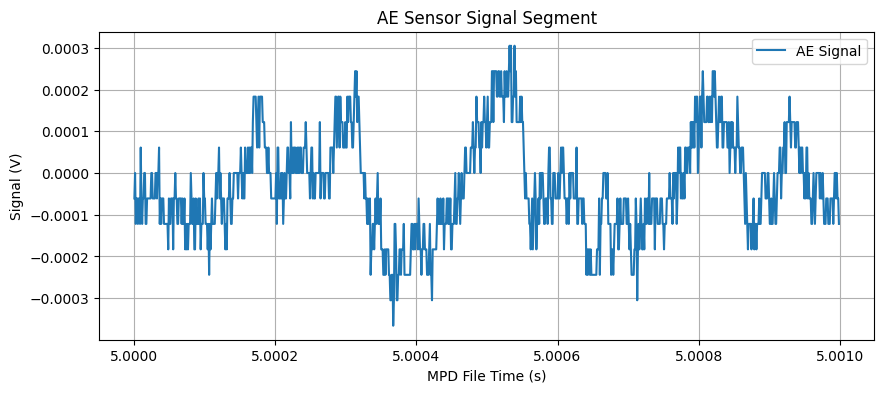

In [53]:
# Create a mask to select a small timespan of data
mask = (combined_wfm_data[:, 0] >= 5) & (combined_wfm_data[:, 0] < 5.001)
segment = combined_wfm_data[mask]

# Plot the masked segment
plt.figure(figsize=(10, 4))
plt.plot(segment[:, 0], segment[:, 1], label="AE Signal")
plt.xlabel("MPD File Time (s)")
plt.ylabel("Signal (V)")
plt.title("AE Sensor Signal Segment")
plt.grid(True)
plt.legend()
plt.show()

Saving image to "C:\Users\sapierso\Box\PD-Acoustic Project Data\0_FormattedData\PD-acoustic170\images\PD-acoustic170_raw_signal_plot.png"


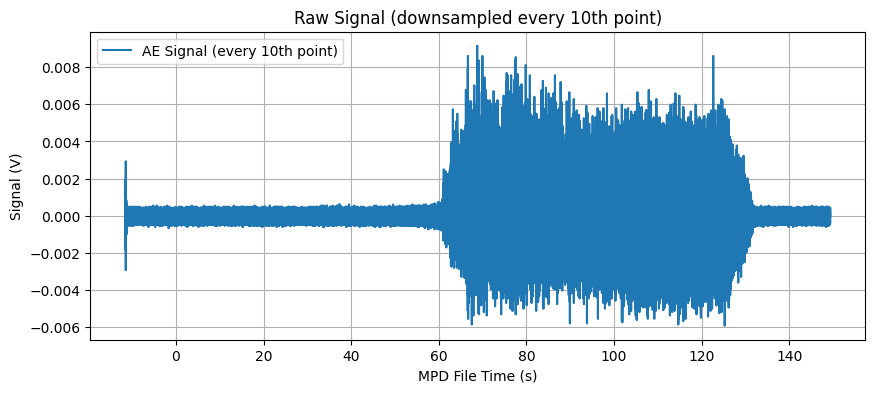

In [131]:
step: int = 10  # Sample every nth point for downsampling (step = 1 for no downsampling)
x_ds = combined_wfm_data[::step, 0]
y_ds = combined_wfm_data[::step, 1]

if step == 1:
    label = "AE Signal"
    title = "Raw Signal"
else:
    label = f"AE Signal (every {step}th point)"
    title = f"Raw Signal (downsampled every {step}th point)"

plt.figure(figsize=(10, 4))
plt.plot(x_ds, y_ds, label=label)
plt.xlabel("MPD File Time (s)")
plt.ylabel("Signal (V)")
plt.title(title)
plt.grid(True)
plt.legend(loc="upper left")

# Build the save path for the image
save_path = os.path.join(images_dir, f"{parent_name}_raw_signal_plot.png")
print(f"Saving image to \"{save_path}\"")

# Save before showing
plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.show()

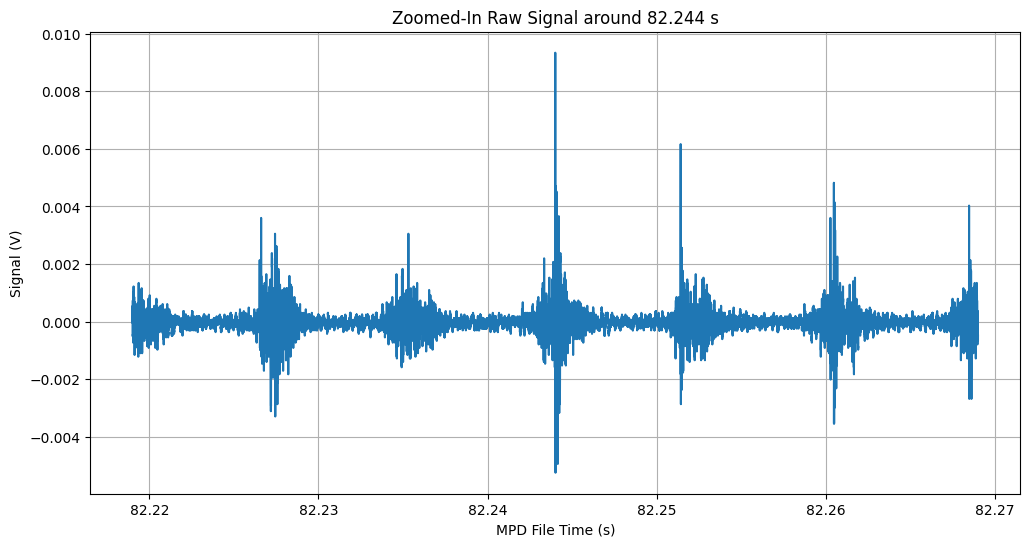

In [55]:
# 1) find time of max abs signal
idx_max = np.argmax(np.abs(combined_wfm_data[:, 1]))
default_center = combined_wfm_data[idx_max, 0]

# 2) ask user (Enter to accept default_center)
user_in = input(f"Enter time to center zoom on [s] (default {default_center:.3f}): ").strip()
if user_in:
    try:
        center = float(user_in)
    except ValueError:
        print(f"Invalid input '{user_in}', using default {default_center:.3f}")
        center = default_center
else:
    center = default_center

# 3) define your zoom window (10 ms here)
window = 0.05
half = window / 2

viewing_xmin = center - half
viewing_xmax = center + half

# 4) (optional) clamp to the data’s time range
t0, tN = combined_wfm_data[0, 0], combined_wfm_data[-1, 0]
viewing_xmin = max(viewing_xmin, t0)
viewing_xmax = min(viewing_xmax, tN)

# 5) extract and plot
mask = (combined_wfm_data[:, 0] >= viewing_xmin) & (combined_wfm_data[:, 0] < viewing_xmax)
segment = combined_wfm_data[mask]

plt.figure(figsize=(12, 6))
plt.plot(segment[:, 0], segment[:, 1])
plt.title(f'Zoomed-In Raw Signal around {center:.3f} s')
plt.xlabel('MPD File Time (s)')
plt.ylabel('Signal (V)')
plt.grid(True)
plt.show()

## Time-Mask the AE Signal for Power Spectral Density Analysis (Optional)

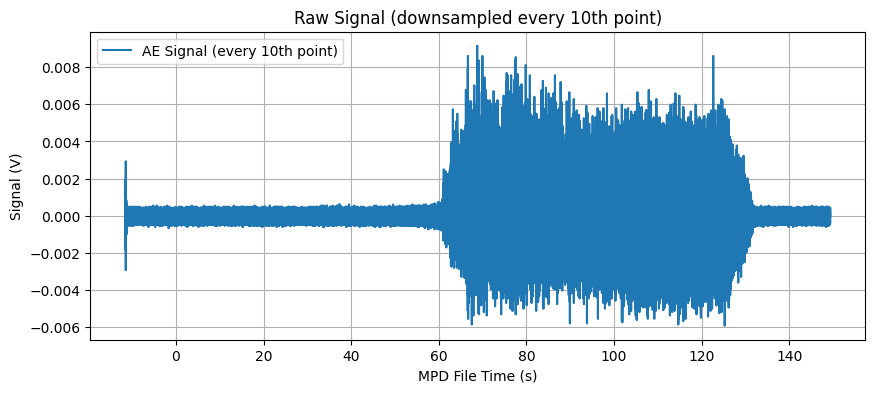

In [56]:
start_time = None
end_time = None

if start_time is not None and end_time is not None:
    mask = (combined_wfm_data[:, 0] >= start_time) & (combined_wfm_data[:, 0] < end_time)
elif start_time is not None:
    mask = (combined_wfm_data[:, 0] >= start_time)
elif end_time is not None:
    mask = (combined_wfm_data[:, 0] < end_time)
else:
    mask = np.ones(combined_wfm_data.shape[0], dtype=bool)

masked_ae_data = combined_wfm_data[mask]

step: int = 10  # Sample every nth point for downsampling (step = 1 for no downsampling)
x_ds = masked_ae_data[::step, 0]
y_ds = masked_ae_data[::step, 1]

if step == 1:
    label = "AE Signal"
    title = "Raw Signal"
else:
    label = f"AE Signal (every {step}th point)"
    title = f"Raw Signal (downsampled every {step}th point)"

plt.figure(figsize=(10, 4))
plt.plot(x_ds, y_ds, label=label)
plt.xlabel("MPD File Time (s)")
plt.ylabel("Signal (V)")
plt.title(title)
plt.grid(True)
plt.legend(loc="upper left")
plt.show()

## Power Spectrum

In [57]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.signal import welch

# def rms_noise_welch(x, fs, fmin=None, fmax=None, nperseg=1024, noverlap=None):
#     """
#     Estimate broadband noise RMS over a specified frequency band using Welch's method.
#     """
#     # compute the power spectral density (PSD) using Welch's method
#     f, Pxx = welch(x, fs=fs, window='hann', nperseg=nperseg, noverlap=noverlap)

#     # build mask, ignoring any None bounds
#     mask = np.ones_like(f, dtype=bool)
#     if fmin is not None:
#         mask &= (f >= fmin)
#     if fmax is not None:
#         mask &= (f <= fmax)
    
#     # integrate and take sqrt
#     P_noise = np.trapz(Pxx[mask], f[mask])
#     return np.sqrt(P_noise)

# def rms_over_time(t0, x, fs, window_sec=1.0, step_sec=0.5, **welch_kwargs):
#     """
#     Compute RMS noise in sliding windows over time.
    
#     Parameters
#     ----------
#     t0 : float
#         Time corresponding to first value in the input signal.
#     x : array-like
#         Input signal.
#     fs : float
#         Sampling frequency (Hz).
#     window_sec : float
#         Window length in seconds.
#     step_sec : float
#         Step size between windows in seconds.
#     welch_kwargs : dict
#         Additional keyword args passed to rms_noise_welch.
        
#     Returns
#     -------
#     times : ndarray
#         Time stamps at the center of each window (s).
#     sigmas : ndarray
#         RMS noise values for each window.
#     """
#     window_len = int(window_sec * fs)  # Window length in samples
#     step_len = int(step_sec * fs)  # Step length in samples
#     sigmas = []  # Initialize list to store RMS values
#     times = []  # Initialize list to store time stamps
#     for start_idx in range(0, len(x) - window_len + 1, step_len):
#         segment = x[start_idx:start_idx + window_len]
#         sigma = rms_noise_welch(segment, fs, **welch_kwargs)
#         center_time = (start_idx + window_len / 2) / fs + t0  # Calculate center time of the window
#         sigmas.append(sigma)
#         times.append(center_time)
#     return np.array(times), np.array(sigmas)

# spec_times, sigmas = rms_over_time(masked_ae_data[0, 0], masked_ae_data[:, 1], fs=sampling_frequency, window_sec=0.5, step_sec=0.1, nperseg=512, fmin=4e3, fmax=50e3)
# plt.figure()
# plt.plot(spec_times, sigmas)
# plt.xlabel("MPD File Time (s)")
# plt.ylabel("RMS Noise (V RMS)")
# plt.title("RMS Broadband Noise vs Time")
# plt.show()

In [58]:
# # Compute the Signal RMS
# signal_rms = np.sqrt(np.mean(np.square(masked_raw_signal)))
# print(f"Signal RMS: {signal_rms} V")

# Compute the Power Spectral Density (PSD)
psd_frequencies, psd = welch(masked_ae_data[:, 1], fs=sampling_frequency, nperseg=1024)
# Convert PSD to dB Scale
psd_db = 10 * np.log10(psd)

psd_min = np.min(psd)
psd_max = np.max(psd)

psd_db_min = np.min(psd_db)
psd_db_max = np.max(psd_db)

print(f"Min Power: {psd_db_min} dB")
print(f"Max Power: {psd_db_max} dB")
print(psd.shape)

Min Power: -148.27639674250193 dB
Max Power: -107.08341381192707 dB
(513,)


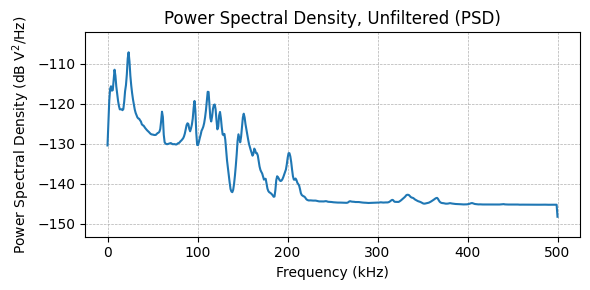

In [59]:
# Plotting the PSD on a log scale
plt.figure(figsize=(6,3))
# plt.semilogx(psd_frequencies, psd_db)
plt.plot(psd_frequencies/1e3, psd_db)
plt.xlabel("Frequency (kHz)")
plt.ylabel("Power Spectral Density (dB V$^2$/Hz)")
plt.ylim([psd_db_min-5, psd_db_max+5])
plt.title("Power Spectral Density, Unfiltered (PSD)")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

# Calculate Spectral Difference Trend(s) Over Time

## Upload an Acoustic Baseline PSD (.csv) file

In [60]:
baseline_psd_path = None

# Load PSD baseline
while True:
    entry = input("Enter absolute path to your baseline PSD: ").strip().strip('"')
    try:
        baseline_psd_path = Path(entry)
    except ValueError:
        print("Invalid path format. Please enter a valid absolute path.")
        continue

    if baseline_psd_path.suffix == '.csv' and baseline_psd_path.is_file():  # Check if the path exists and ends with .csv
        print(f"Loading PSD from \"{entry}\"")
        break
    else:
        print(f"Path '{entry}' does not exist. Please try again.")

Loading PSD from "C:\Users\sapierso\Box\PD-Acoustic Project Data\0_FormattedData\PD-acoustic170\saved_psd_150_None_nperseg_16384.csv"


In [61]:
def parse_trailing_number(s):
    # This regex says:
    #   ^       : start of string
    #   ([^\d]+): one or more non-digit characters → group 1 (the “prefix”)
    #   (\d+(?:\.\d+)?)$ 
    #            : one or more digits, optionally a decimal-point + more digits, 
    #              anchored at the end → group 2 (the “number”)
    m = re.match(r'^([^\d]+)(\d+(?:\.\d+)?)$', s)
    if not m:
        return None, None
    prefix, num_str = m.groups()
    num = float(num_str)
    return prefix, num

def psd_distance(f, P1, P2, f_min=1e3, f_max=50e3, metric='L_inf'):
    # 1) mask to band
    mask = (f >= f_min) & (f <= f_max)
    p1, p2 = P1[mask], P2[mask]
    f_masked = f[mask]
    eps = 0

    prefix, p = parse_trailing_number(metric)

    if metric == 'L_inf':
        # L-infinity (Chebyshev) distance
        return np.max(np.abs(p1 - p2))

    # elif metric == 'rmsle':
    #     return np.sqrt(np.mean((np.log(p1 + eps) - np.log(p2 + eps))**2))

    # elif metric == 'skl':
    #     # symmetric KL divergence on normalized PSDs
    #     p1n, p2n = p1 / p1.sum(), p2 / p2.sum()
    #     return 0.5 * (
    #         np.sum(p1n * np.log(p1n / p2n)) +
    #         np.sum(p2n * np.log(p2n / p1n))
    #     )

    # elif metric == 'angle':
    #     # spectral angle
    #     return np.arccos(np.dot(p1, p2) /
    #                      (np.linalg.norm(p1) * np.linalg.norm(p2)))
    
    # elif metric == 'energy':
    #     # Energy distance
    #     return energy_distance(p1, p2)
    
    # elif prefix == 'L':
    #     # L8 distance (max norm)
    #     print(f"Calculating L{p} distance")
    #     return np.max(np.abs(p1 - p2)**p)**(1/p)

    # elif metric in ('emd', 'wasserstein'):
    #     # Earth Mover's (1-Wasserstein) distance
    #     return wasserstein_distance(
    #         f_masked,      # support for P1
    #         f_masked,      # support for P2 (same grid)
    #         u_weights=p1,  # masses for P1
    #         v_weights=p2   # masses for P2
    #     )

    # elif metric in ('euclidean'):
    #     # Euclidean distance between the two PSDs
    #     return np.linalg.norm(p1 - p2)

    else:
        raise ValueError(f"Unknown metric '{metric}'")
    
def compute_windowed_welch_with_progress(t0, data, fs, window_sec, overlap_frac=0.5):
    # convert to samples
    win_len = int(window_sec * fs)
    noverlap = int(win_len * overlap_frac)
    # if nfft is None:
    #     nfft = 1 << (win_len - 1).bit_length()

    # strided windows
    step = win_len - noverlap
    windows = sliding_window_view(data, win_len)[::step]

    psd_list = []
    for w in tqdm(windows, desc="Windowed Welch", unit="win"):
        f, Pxx = welch(
            w,
            fs=fs,
            nperseg=4096*4,
        )
        psd_list.append(Pxx)

    print(windows.shape)

    # stack into 2D array
    psd_array = np.vstack(psd_list)  # shape (n_windows, n_freqs)

    # now convert each PSD to dB scale, keeping original list intact
    psd_db_list = [10 * np.log10(psd) for psd in psd_list]

    # if you want a 2D array of dB-PSDs too:
    psd_db_array = np.vstack(psd_db_list)

    step = win_len - noverlap
    start_sample_indices = np.arange(0, len(data) - win_len + 1, step)
    times = start_sample_indices / fs + window_sec/2 + t0 # Center time of each Welch window start (in seconds).

    # return frequencies, linear PSDs, and dB PSDs
    return f, psd_array, psd_db_array, times

Loading baseline PSD from "C:\Users\sapierso\Box\PD-Acoustic Project Data\0_FormattedData\PD-acoustic170\saved_psd_150_None_nperseg_16384.csv"


Windowed Welch: 100%|██████████| 320/320 [00:10<00:00, 29.51win/s]


(320, 1000000)
psd_db array shape: (320, 8193)


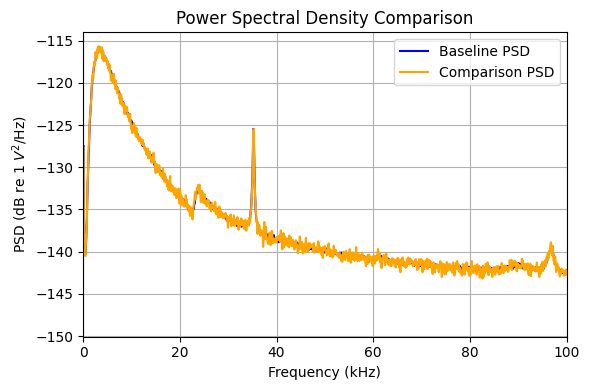

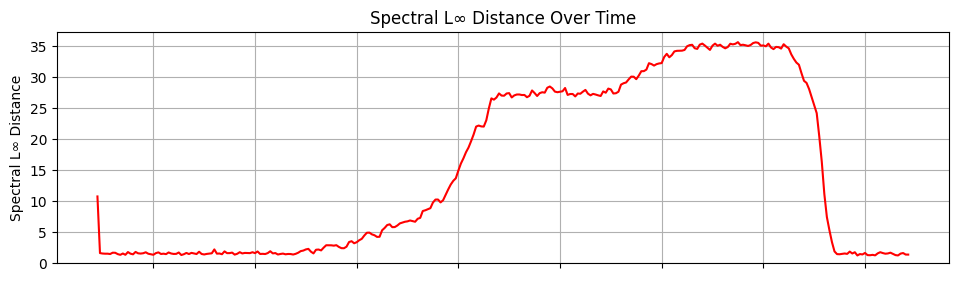

Saving image to "C:\Users\sapierso\Box\PD-Acoustic Project Data\0_FormattedData\PD-acoustic170\images\PD-acoustic170_Linf_vs_pC_plot.png"


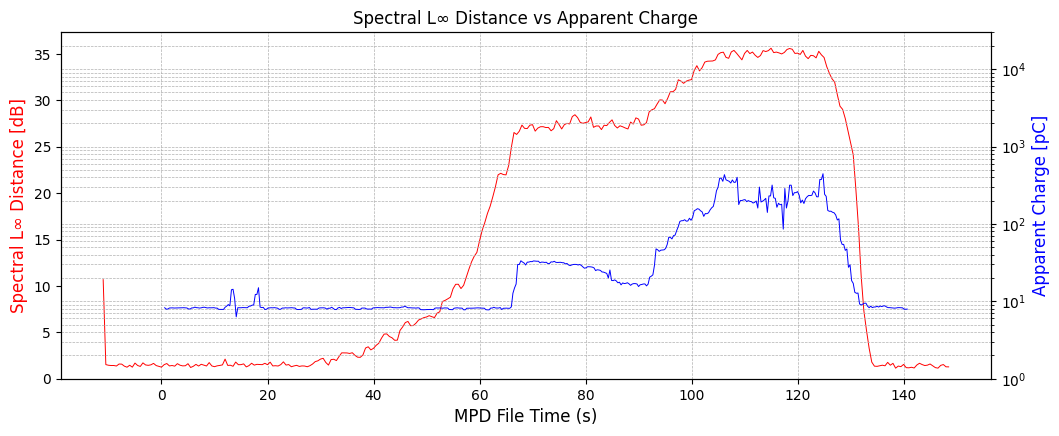

Saving image to "C:\Users\sapierso\Box\PD-Acoustic Project Data\0_FormattedData\PD-acoustic170\images\PD-acoustic170_Linf_vs_ASL_plot.png"


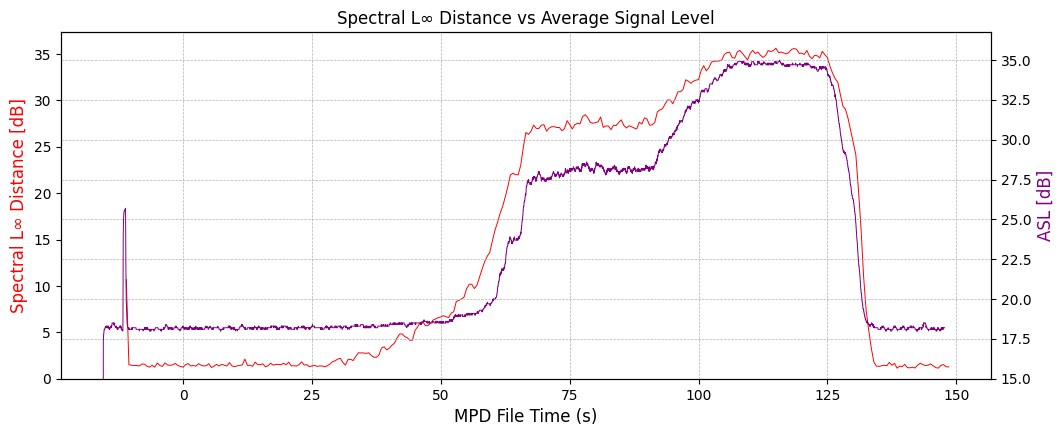

In [133]:
psd_freqs = None
psd_times = None
psds = None
psd_db = None
if baseline_psd_path is not None:
    print(f"Loading baseline PSD from \"{baseline_psd_path}\"")
    baseline_psd = pd.read_csv(baseline_psd_path)
    baseline_freqs   = baseline_psd.iloc[:, 0].values
    baseline_psd_vals= baseline_psd.iloc[:, 1].values
    baseline_psd_vals_log = 10 * np.log10(baseline_psd_vals)

    window_sec = 1.0  # window length (seconds)
    t0 = masked_ae_data[0, 0]  # start time of the AE data
    data = masked_ae_data[:, 1]
    fs = 1e6  # 1 MHz
    psd_freqs, psds, psd_db, psd_times = compute_windowed_welch_with_progress(
        t0, data, fs, window_sec=window_sec
    )
    print("psd_db array shape:", psd_db.shape)
    if np.isnan(psd_db).any():
        print("Warning: psd_db contains NaN values. This may indicate an issue with the PSD calculation.")

    plt.figure(figsize=(6, 4))
    plt.plot(baseline_freqs/1e3, 10*np.log10(baseline_psd_vals), label='Baseline PSD', color='blue')
    plt.plot(psd_freqs/1e3, psd_db[1, :], label='Comparison PSD', color='orange')
    plt.xlim(0, 100)
    plt.xlabel('Frequency (kHz)')
    plt.ylabel('PSD (dB re 1 $V^2$/Hz)')
    plt.title('Power Spectral Density Comparison')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Iterate through the PSDs the spectrogram is comprised of and build an array of distances
    L_inf_psd_distances = []
    # rmsle_psd_distances = []
    # skl_psd_distances = []
    # angle_psd_distances = []
    # energy_psd_distances = []
    # L_8_psd_distances = []
    # L_16_psd_distances = []
    # emd_psd_distances = []
    # euclidean_psd_distances = []

    for i in range(psds.shape[0]):
        comparison_psd_vals = psds[i, :]
        comparison_psd_vals_log = 10 * np.log10(comparison_psd_vals)
        # psd_distance_value = psd_distance(baseline_freqs, baseline_psd_vals_log, comparison_psd_vals_log,
        #                                   f_min=1e3, f_max=50e3, metric='rmsle')
        # rmsle_psd_distances.append(psd_distance_value)
        # skl_distance_value = psd_distance(baseline_freqs, baseline_psd_vals_log, comparison_psd_vals_log,
        #                                   f_min=1e3, f_max=50e3, metric='skl')
        # skl_psd_distances.append(skl_distance_value)
        # angle_distance_value = psd_distance(baseline_freqs, baseline_psd_vals_log, comparison_psd_vals_log,
        #                                     f_min=1e3, f_max=50e3, metric='angle')
        # angle_psd_distances.append(angle_distance_value)
        # energy_distance_value = psd_distance(baseline_freqs, baseline_psd_vals_log, comparison_psd_vals_log,
        #                                     f_min=1e3, f_max=50e3, metric='energy')
        # energy_psd_distances.append(energy_distance_value)
        L_inf_distance_value = psd_distance(baseline_freqs, baseline_psd_vals_log, comparison_psd_vals_log,
                                            f_min=4e3, f_max=50e3, metric='L_inf')
        L_inf_psd_distances.append(L_inf_distance_value)

    # line‐plot definitions
    plots = [
        # (rmsle_psd_distances, 'RMSLE Distance',       'RMSLE Distance Over Time'),
        # (skl_psd_distances,   'SKL Distance',         'SKL Distance Over Time'),
        # (angle_psd_distances, 'Angle Distance (rad)', 'Angle Distance Over Time'),
        # (energy_psd_distances,'Energy Distance',      'Energy Distance Over Time'),
        (L_inf_psd_distances, 'Spectral L∞ Distance', 'Spectral L∞ Distance Over Time'),
        # (L_8_psd_distances,   'L8 Distance',         'L8 Distance Over Time'),
        # (L_16_psd_distances,  'L16 Distance',        'L16 Distance Over Time'),
        # (emd_psd_distances,   'EMD Distance',         'EMD Distance Over Time'),
        # (euclidean_psd_distances,    'Euclidean Distance',          'Euclidean Distance Over Time'),
    ]

    fig = plt.figure(constrained_layout=True, figsize=(10, 12))
    gs = gridspec.GridSpec(
        nrows=len(plots)+2, ncols=2, figure=fig,
        width_ratios=[20, 1],
        height_ratios=[1] * len(plots) + [2, 2],
        hspace=0.05, wspace=0.05
    )

    # create the top 5 rows of line plots
    axes = []
    for i, (data, ylabel, title) in enumerate(plots):
        # share x‐axis with the first subplot
        ax = fig.add_subplot(gs[i, 0], sharex=None if i == 0 else axes[0])
        log_data = np.log10(data)
        ax.plot(psd_times, data, color='red', label=title)
        ax.set_ylabel(ylabel)
        ax.set_title(title)
        ax.grid(True)
        ax.set_ylim(bottom=0)       # force y‐axis bottom at 0
        ax.label_outer()            # hide inner tick‐labels (incl. x‐ticks on all but spectrogram)
        axes.append(ax)

    plt.show()


    # Plot L_inf distances against apparent charge
    fig, ax1 = plt.subplots(figsize=(12, 4.5))
    ax2 = ax1.twinx()
    label_fontsize = 12
    tick_fontsize = 10

    ax2.plot(
        MPD_df['Time [s]'],
        MPD_df['IEC 60270 Apparent Charge (Q_IEC/WTD) [pC]'],
        color='blue',
        linewidth=0.7,
        label='Apparent Charge [pC]'  # Uncommented label
    )
    ax2.set_ylabel('Apparent Charge [pC]', fontsize=label_fontsize, color='blue')
    ax2.tick_params(axis='y', labelsize=tick_fontsize)
    ax2.set_yscale('log')  # Set y-axis to logarithmic scale for better visibility
    ax2.set_ylim(1e0, 3e4)  # Set y-limits for Apparent Charge axis
    ax2.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)

    ax1.plot(
        psd_times,  # + AE_time_shift + wfm_stream_time_shift, 
        L_inf_psd_distances, 
        color='red', 
        linewidth=0.7, 
        label='Spectral L∞ Distance'  # Uncommented label
    )
    ax1.set_ylim(bottom=0)  # Force y-axis bottom at 0
    # ax1.axhline(l_inf_threshold, color='green', linestyle='--', linewidth=0.7, label='L∞ Threshold')
    ax1.set_ylabel('Spectral L∞ Distance [dB]', fontsize=label_fontsize, color='red')
    ax1.tick_params(axis='y', labelsize=tick_fontsize)
    ax1.set_xlabel('MPD File Time (s)', fontsize=label_fontsize)
    # Draw vertical grid lines at every x-tick
    ax1.grid(
        True,
        which='both',
        axis='x',
        linestyle='--',
        linewidth=0.5,
    )

    plt.title('Spectral L∞ Distance vs Apparent Charge', fontsize=label_fontsize)

    # Build the save path for the image
    save_path = os.path.join(images_dir, f"{parent_name}_Linf_vs_pC_plot.png")
    print(f"Saving image to \"{save_path}\"")

    # Save before showing
    plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()


    # Plot L_inf distances against Mistras TDD parameter
    fig, ax1 = plt.subplots(figsize=(12, 4.5))
    ax2 = ax1.twinx()
    label_fontsize = 12
    tick_fontsize = 10

    ax2.plot(
        mistras_tdd_df['TIME'],  #+AE_time_shift,
        mistras_tdd_df['ASL_CONTINUOUS'],
        color='purple',
        linewidth=0.7,
        label='ASL_CONTINUOUS [dB]'
    )
    ax2.set_ylim(bottom=15)
    ax2.set_ylabel('ASL [dB]', fontsize=label_fontsize, color='purple')
    ax2.tick_params(axis='y', labelsize=tick_fontsize)
    ax2.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)

    ax1.plot(
        psd_times, #+ AE_time_shift + wfm_stream_time_shift, 
        L_inf_psd_distances, 
        color='red', 
        linewidth=0.7, 
        label='Spectral L∞ Distance'
    )
    ax1.set_ylim(bottom=0)       # force y‐axis bottom at 0
    # ax1.axhline(l_inf_threshold, color='green', linestyle='--', linewidth=0.7, label='L∞ Threshold')
    ax1.set_ylabel('Spectral L∞ Distance [dB]', fontsize=label_fontsize, color='red')
    ax1.tick_params(axis='y', labelsize=tick_fontsize)
    ax1.set_xlabel('MPD File Time (s)', fontsize=label_fontsize)

    # Draw vertical grid lines at every x-tick
    ax1.grid(
        True,
        which='both',
        axis='x',
        linestyle='--',
        linewidth=0.5,
    )
    plt.title('Spectral L∞ Distance vs Average Signal Level', fontsize=label_fontsize)

    # Build the save path for the image
    save_path = os.path.join(images_dir, f"{parent_name}_Linf_vs_ASL_plot.png")
    print(f"Saving image to \"{save_path}\"")

    # Save before showing
    plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

## STFT Spectrogram

In [63]:
# Compute the spectrogram
spec_frequencies, spec_times, Sxx = spectrogram(masked_ae_data[:, 1], sampling_frequency, nperseg=4096)
Sxx_log = 10 * np.log10(Sxx)

spec_times -= (MPD_wfm_file_time_diff - net_AE_time_adjust_from_file)

In [64]:
print(spec_times)

[-11.497952 -11.494368 -11.490784 ... 149.36272  149.366304 149.369888]


### Adjust Spectrogram Parameters

In [65]:
# Times (s) over which to mask out the x-axis
start_time_mask = None
end_time_mask = None

# AE_file_headstart = (MPD_metadata['start_time'] - mistras_metadata['start_time']).total_seconds()

# # Manually adjust the time shift for the AE data relative to the MPD data
# AE_time_shift = -AE_file_headstart + 3.5

max_freq = 50e3  # Frequency (Hz) over which to mask out the y-axis

# Default spectrogram min/max values
min_spectrogram_value_ctrl = psd_db_min
max_spectrogram_value_ctrl = psd_db_max
print(psd_db_min, psd_db_max)

# Override spectrogram min/max values
min_spectrogram_value_ctrl = -150
max_spectrogram_value_ctrl = -95

-148.27639674250193 -107.08341381192707


In [66]:
freq_mask = spec_frequencies <= max_freq
masked_frequencies = spec_frequencies[freq_mask]
masked_Sxx_log = Sxx_log[freq_mask, :]

# # Add the start_time to the times array
# spec_times = spec_times + start_time

print(f"Sxx_log shape: {Sxx_log.shape}")
print(f"Masked Sxx_log shape: {masked_Sxx_log.shape}")

# Calculate the time shift between the AE data and the waveform streaming data
# wfm_stream_file_delay = (wfm_stream_metadata['start_time'] - mistras_tdd_metadata['start_time']).total_seconds()

# Manually adjust the time shift for the waveform streaming data relative to the AE data
# wfm_stream_time_shift = wfm_stream_file_delay - .25
# print(wfm_stream_time_shift)

# Create the boolean mask for the x-axis
masked_times = spec_times # + AE_time_shift + wfm_stream_time_shift

if start_time_mask is not None and end_time_mask is not None:
    time_mask = (masked_times >= start_time_mask) & (masked_times <= end_time_mask)
elif end_time_mask is not None:
    time_mask = masked_times <= end_time_mask
elif start_time_mask is not None:
    time_mask = masked_times >= start_time_mask
else:
    time_mask = np.ones_like(masked_times, dtype=bool)

# Filter times and spectrogram data based on the time_mask.
masked_times = masked_times[time_mask]
masked_Sxx_log = masked_Sxx_log[:, time_mask]

Sxx_log shape: (2049, 44886)
Masked Sxx_log shape: (205, 44886)


# Calculate PD Inception Times & Voltages

In [67]:
# TODO: Deprecate this function with bad logic in favor of the new get_PD_times function

# def get_PD_inception_times(times, param, threshold: float, n_hits: int = 5, inception_window: float = 3.0, extinction_window: float = 3.0):
#     """
#     Get PD inception in based on input array and threshold.
    
#     Parameters:
#         time (np.array): Array containing the time values.
#         param (np.array): Array containing the parameter to consider for PD inception.
#         n_hits (int): Minimum number of hits to consider a PD inception in inception_window.
#         inception_window (float): Time window in seconds to check for hits.
#         extinction_window (float): Time window in seconds to check for no hits before the inception.
#         threshold (float): Hit threshold
        
#     Returns:
#         list: List of PD inception times.
#     """
    
#     pd_times = []

#     # mask out data points that fall below the threshold
#     mask = param >= threshold
#     param = param[mask]
#     times = times[mask]
        
#     # For each time t, count hits in (t - window, t] and (t, t + window]
#     for idx, t0 in enumerate(times):
#         # count hits in (t0 - extinction_window, t0) and (t0, t0 + inception_window]
#         prev_count = np.sum((times > t0 - extinction_window) & (times < t0))
#         next_count = np.sum((times > t0) & (times <= t0 + inception_window))

#         # check for inception
#         if prev_count == 0 and next_count >= n_hits:
#             # scan forward for extinction: first t1 > t0 with zero hits in prior extinction_window
#             t_ext = None
#             for t1 in times[idx+1:]:
#                 if np.sum((times < t1 + extinction_window) & (times > t1)) == 0:
#                     t_ext = t1
#                     break
#             if t_ext is None:
#                 t_ext = times[-1]
#             pd_times.append((t0, t_ext))

#     return pd_times


def get_PD_times(times, param, threshold: float, operator: str = '>=', n_hits: int = 5, inception_window=3.0, extinction_window=3.0):
    """
    Get PD inception/extinction times by thresholding trend data.
    
    Parameters:
        time (np.array): Array containing the time values.
        param (np.array): Array containing the parameter to consider for PD inception.  
        threshold (float): Threshold value of param to consider a hit.      
        n_hits (int): Minimum number of hits to consider a PD inception in inception_window.
        inception_window (float): Time window in seconds to check for hits.
        extinction_window (float): Time window in seconds to check for no hits before the inception.
        
    Returns:
        list: List of PD inception times.
    """

    if param.shape != times.shape:
        raise ValueError("param and times must have the same shape")
    
    pd_times = []

    # mask out data points that fall below the threshold
    if operator == '>=':
        mask = param >= threshold
    elif operator == '<=':
        mask = param <= threshold
    elif operator == '>':
        mask = param > threshold
    elif operator == '<':
        mask = param < threshold
    else:
        raise ValueError("Invalid operator. Use '>=', '<=', '>', or '<'.")
    hit_times = times[mask]

    last_t_extinction = 0
    
    # For each time t, count hits in (t - window, t] and (t, t + window]
    for idx, t0 in enumerate(hit_times):
        if t0 < last_t_extinction:
            continue

        # count hits in (t0 - extinction_window, t0) and (t0, t0 + inception_window]
        prev_count = np.sum((hit_times > t0 - extinction_window) & (hit_times < t0))
        next_count = np.sum((hit_times > t0) & (hit_times <= t0 + inception_window))

        # check for inception
        if prev_count <= n_hits and next_count >= n_hits:
            # scan forward for extinction: first t1 > t0 with zero hits in prior extinction_window
            t_ext = None
            for t1 in hit_times[idx+1:]:
                if np.sum((hit_times < t1 + extinction_window) & (hit_times > t1)) == 0:
                    t_ext = t1
                    last_t_extinction = t_ext
                    break
            # if no extinction found, use the time of the last hit
            if t_ext is None:
                t_ext = hit_times[-1]
                last_t_extinction = t_ext
            pd_times.append((t0, t_ext))
    
    return pd_times

def get_PD_times_acoustic_hits(mistras_df, n_hits: int = 5, inception_window=3, extinction_window=3):
    """
    Get PD inception times based on acoustic data.
    
    Parameters:
        mistras_df (pd.DataFrame): DataFrame containing the AE data
        n_hits (int): Minimum number of hits to consider a PD inception in inception_window.
        inception_window (float): Time window in seconds to check for hits.
        extinction_window (float): Time window in seconds to check for no hits before the inception.
        
    Returns:
        list: List of PD inception times.
    """
    
    pd_times = []
    
    times = mistras_df["TIME"].to_numpy()

    last_t_extinction = 0
    
    # For each time t, count hits in (t - window, t] and (t, t + window]
    for idx, t0 in enumerate(times):
        if t0 < last_t_extinction:
            continue

        # count hits in (t0 - extinction_window, t0) and (t0, t0 + inception_window]
        prev_count = np.sum((times > t0 - extinction_window) & (times < t0))
        next_count = np.sum((times > t0) & (times <= t0 + inception_window))

        # check for inception
        if prev_count <= n_hits and next_count >= n_hits:
            # scan forward for extinction: first t1 > t0 with zero hits in prior extinction_window
            t_ext = None
            for t1 in times[idx+1:]:
                if np.sum((times < t1 + extinction_window) & (times > t1)) == 0:
                    t_ext = t1
                    last_t_extinction = t_ext
                    break
            if t_ext is None:
                t_ext = times[-1]
            pd_times.append((t0, t_ext))
    
    return pd_times


# TODO: Deprecate this function (works okay) in favor of the new more general get_PD_times function

# def get_PD_times_electrical(MPD_df, n_hits: int = 5, inception_window=3, extinction_window=3, apparent_charge_threshold_pC=10, MPD_time_adjust=0):
#     """
#     Get PD inception times based on electrical data.
    
#     Parameters:
#         MPD_df (pd.DataFrame): DataFrame containing the electrical data
#         n_hits (int): Minimum number of hits to consider a PD inception in inception_window.
#         inception_window (float): Time window in seconds to check for hits.
#         extinction_window (float): Time window in seconds to check for no hits before the inception.
#         apparent_charge_threshold_pC (float): Minimum apparent charge in pC to consider a hit.
        
#     Returns:
#         list: List of PD inception times.
#     """
    
#     pd_times = []

#     # mask out data points with apparent charge below the threshold
#     MPD_df = MPD_df[MPD_df['IEC 60270 Apparent Charge (Q_IEC/WTD) [pC]'] >= apparent_charge_threshold_pC]  # Convert pC to C for comparison
    
#     times = MPD_df["Time [s]"].to_numpy()
    
#     # For each time t, count hits in (t - window, t] and (t, t + window]
#     for idx, t0 in enumerate(times):
#         # count hits in (t0 - extinction_window, t0) and (t0, t0 + inception_window]
#         prev_count = np.sum((times > t0 - extinction_window) & (times < t0))
#         next_count = np.sum((times > t0) & (times <= t0 + inception_window))

#         # check for inception
#         if prev_count == 0 and next_count >= n_hits:
#             # scan forward for extinction: first t1 > t0 with zero hits in prior extinction_window
#             t_ext = None
#             for t1 in times[idx+1:]:
#                 if np.sum((times < t1 + extinction_window) & (times > t1)) == 0:
#                     t_ext = t1
#                     break
#             if t_ext is None:
#                 t_ext = times[-1]
#             pd_times.append((t0 + MPD_time_adjust, t_ext + MPD_time_adjust))

#     return pd_times

def get_voltage_electrical(MPD_df, time, MPD_time_adjust=0):
    """
    Get voltage based on electrical data.
    
    Parameters:
        MPD_df (pd.DataFrame): DataFrame containing the electrical data
        time (float): Time at which to get the voltage.
        
    Returns:
        float: voltage value at the specified time.
    """
    
    # Find the row corresponding to the specified time
    row = MPD_df[MPD_df['Time [s]'] == time - MPD_time_adjust]
    
    if not row.empty:
        return row['AC Input RMS Voltage [V]'].values[0]
    else:
        raise ValueError(f"No data found for time {time}.")

In [68]:
MPD_times = MPD_df['Time [s]'].values
MPD_voltages = MPD_df['AC Input RMS Voltage [V]'].values
MPD_apparent_charge = MPD_df['IEC 60270 Apparent Charge (Q_IEC/WTD) [pC]'].values

## Calculate PD Inception Times & Voltages from Electrical Data

In [69]:
elec_times = get_PD_times(
    MPD_times, 
    MPD_apparent_charge, 
    threshold=10, 
    operator='>=', 
    n_hits=5, 
    inception_window=3.0, 
    extinction_window=1.0
)
elec_inc_voltages = [
    get_voltage_electrical(MPD_df, t0)
    for t0, t_ext in elec_times
]
if elec_times:
    elec_inc_times, elec_ext_times = zip(*elec_times)
else:
    elec_inc_times, elec_ext_times = [], []

print(f"Electrical PD Inceptions/Extinctions: {elec_times}")
print(f"Electrical PD Voltages: {elec_inc_voltages}")

Electrical PD Inceptions/Extinctions: [(66.3, 131.4)]
Electrical PD Voltages: [1482.5334236615483]


## Calculate PD Inception Times & Voltages from AE Hits

In [70]:
## IMPORTANT: This section assumes that the mistras_df (and mistras_tdd_df) DataFrame has already had its 'TIME' column shifted to synchronize with the MPD data.
ae_hits_times = get_PD_times_acoustic_hits(mistras_df, n_hits=5, inception_window=3, extinction_window=3)
ae_hits_inc_voltages = [
    np.interp(t0, MPD_times, MPD_voltages)
    for t0, t_ext in ae_hits_times
]

# Unpack tuple‐lists:
if ae_hits_times:
    ae_hits_inc_times, ae_hits_ext_times = zip(*ae_hits_times)
else:
    # in case ae_times is empty or full of NaN‐tuples
    ae_hits_inc_times, ae_hits_ext_times = [], []

print(f"Acoustic Hit PD Inceptions/Extinctions: {ae_hits_times}")
print(f"Acoustic Hit PD Voltages: {ae_hits_inc_voltages}")

Acoustic Hit PD Inceptions/Extinctions: [(58.8636575, 131.5623375)]
Acoustic Hit PD Voltages: [1244.5105948320647]


## Calculate PD Inception Times & Voltages from Parameters Computed from Windowed Welch of AE Waveform

In [71]:
l_inf_threshold = 3.0  # Set the L_inf threshold for PD here

ae_spectral_diff_times = get_PD_times(
    np.array(psd_times), 
    np.array(L_inf_psd_distances), 
    threshold=l_inf_threshold, 
    operator='>=',
    n_hits=5, 
    inception_window=3.0, 
    extinction_window=3.0
)
ae_spectral_diff_inc_voltages = [
    np.interp(t0, MPD_times, MPD_voltages)
    for t0, t_ext in ae_spectral_diff_times
]

# Unpack tuple‐lists:
if ae_spectral_diff_times:
    ae_spectral_diff_inc_times, ae_spectral_diff_ext_times = zip(*ae_spectral_diff_times)
else:
    # in case ae_times is empty or full of NaN‐tuples
    ae_spectral_diff_inc_times, ae_spectral_diff_ext_times = [], []


print(f"Acoustic L-inf Spectral Difference PD Inceptions/Extinctions: {ae_spectral_diff_times}")
print(f"Acoustic L-inf Spectral Difference PD Inception Voltages:     {ae_spectral_diff_inc_voltages}")

Acoustic L-inf Spectral Difference PD Inceptions/Extinctions: [(38.498976, 133.498976)]
Acoustic L-inf Spectral Difference PD Inception Voltages:     [706.8656519574379]


## Pad Inception/Extinction Data and Compile into a DataFrame for Presentation

In [135]:
# Pad them with NaN values to equal length:
max_len = max(len(ae_hits_inc_times), len(elec_inc_times), len(ae_spectral_diff_inc_times))

elec_inc_times = list(elec_inc_times) + [np.nan] * (max_len - len(elec_inc_times))
elec_ext_times= list(elec_ext_times)  + [np.nan] * (max_len - len(elec_ext_times))

ae_hits_inc_times = list(ae_hits_inc_times)                   + [np.nan] * (max_len - len(ae_hits_inc_times))
ae_hits_ext_times = list(ae_hits_ext_times)                   + [np.nan] * (max_len - len(ae_hits_ext_times))

ae_spectral_diff_inc_times = list(ae_spectral_diff_inc_times) + [np.nan] * (max_len - len(ae_spectral_diff_inc_times))
ae_spectral_diff_ext_times = list(ae_spectral_diff_ext_times) + [np.nan] * (max_len - len(ae_spectral_diff_ext_times))

elec_inc_voltages   = elec_inc_voltages                       + [np.nan] * (max_len - len(elec_inc_voltages))
ae_hits_inc_voltages     = ae_hits_inc_voltages               + [np.nan] * (max_len - len(ae_hits_inc_voltages))
ae_spectral_diff_inc_voltages = ae_spectral_diff_inc_voltages + [np.nan] * (max_len - len(ae_spectral_diff_inc_voltages))


# Compute max/min voltage within the tolerance window for each AE hits inception:
expected_ae_hits_synchronization_error = 1.0  # seconds
ae_hits_max_tol = []
ae_hits_min_tol = []

# raw, un-padded ae_inceptions for the loop
raw_ae_hits_inceptions = list(zip(ae_hits_inc_times, ae_hits_ext_times))[:len(ae_hits_inc_voltages)]
for t0, _ in raw_ae_hits_inceptions:
    mask = (MPD_times >= (t0 - expected_ae_hits_synchronization_error)) & (MPD_times <= (t0 + expected_ae_hits_synchronization_error))
    window_vals = MPD_voltages[mask]

    # include the interpolated endpoints
    v_minus = np.interp(t0 - expected_ae_hits_synchronization_error, MPD_times, MPD_voltages)
    v_plus  = np.interp(t0 + expected_ae_hits_synchronization_error, MPD_times, MPD_voltages)
    all_vals = np.concatenate(([v_minus], window_vals, [v_plus]))

    if all_vals.size:
        ae_hits_max_tol.append(all_vals.max())
        ae_hits_min_tol.append(all_vals.min())
    else:
        ae_hits_max_tol.append(np.nan)
        ae_hits_min_tol.append(np.nan)

# Pad these two new lists to the same length as the others:
ae_hits_max_tol = ae_hits_max_tol + [np.nan] * (len(ae_hits_inc_times) - len(ae_hits_max_tol))
ae_hits_min_tol = ae_hits_min_tol + [np.nan] * (len(ae_hits_inc_times) - len(ae_hits_min_tol))


# Compute max/min voltage within the tolerance window for each AE spectral difference inception:
expected_ae_wfm_synchronization_error = 1.0  # seconds
ae_spectral_diff_max_tol = []
ae_spectral_diff_min_tol = []

# raw, un-padded ae_inceptions for the loop
raw_ae_spectral_diff_inceptions = list(zip(ae_spectral_diff_inc_times, ae_spectral_diff_ext_times))[:len(ae_spectral_diff_inc_voltages)]
for t0, _ in raw_ae_spectral_diff_inceptions:
    mask = (MPD_times >= (t0 - expected_ae_wfm_synchronization_error)) & (MPD_times <= (t0 + expected_ae_wfm_synchronization_error))
    window_vals = MPD_voltages[mask]

    # include the interpolated endpoints
    v_minus = np.interp(t0 - expected_ae_wfm_synchronization_error, MPD_times, MPD_voltages)
    v_plus  = np.interp(t0 + expected_ae_wfm_synchronization_error, MPD_times, MPD_voltages)
    all_vals = np.concatenate(([v_minus], window_vals, [v_plus]))

    if all_vals.size:
        ae_spectral_diff_max_tol.append(all_vals.max())
        ae_spectral_diff_min_tol.append(all_vals.min())
    else:
        ae_spectral_diff_max_tol.append(np.nan)
        ae_spectral_diff_min_tol.append(np.nan)

# Pad these two new lists to the same length as the others:
ae_spectral_diff_max_tol = ae_spectral_diff_max_tol + [np.nan] * (len(ae_spectral_diff_inc_times) - len(ae_spectral_diff_max_tol))
ae_spectral_diff_min_tol = ae_spectral_diff_min_tol + [np.nan] * (len(ae_spectral_diff_inc_times) - len(ae_spectral_diff_min_tol))


# Define a MultiIndex where the first 5 columns are all "ae_hits"
arrays = [
    ["electrical", "electrical", "electrical",
     "ae_hits", "ae_hits", "ae_hits", "ae_hits", "ae_hits",
     "ae_spectral_diff (L∞ >= 3.0)", "ae_spectral_diff (L∞ >= 3.0)", "ae_spectral_diff (L∞ >= 3.0)", "ae_spectral_diff (L∞ >= 3.0)", "ae_spectral_diff (L∞ >= 3.0)"],
    ["inception time [s]", "extinction time [s]", "inception voltage [V]",
     "inception time [s]", "extinction time [s]", "inception voltage [V]", f"min voltage ±{expected_ae_hits_synchronization_error}s [V]", f"max voltage ±{expected_ae_hits_synchronization_error}s [V]",
     "inception time [s]", "extinction time [s]", "inception voltage [V]", f"min voltage ±{expected_ae_wfm_synchronization_error}s [V]", f"max voltage ±{expected_ae_wfm_synchronization_error}s [V]"]
]
cols = pd.MultiIndex.from_tuples(list(zip(*arrays)), names=["type","metric"])

# Build DataFrame for presentation
df2 = pd.DataFrame(
    {
        ("ae_spectral_diff (L∞ >= 3.0)",     "inception time [s]"):                                          ae_spectral_diff_inc_times,
        ("ae_spectral_diff (L∞ >= 3.0)",     "extinction time [s]"):                                         ae_spectral_diff_ext_times,
        ("ae_spectral_diff (L∞ >= 3.0)",     "inception voltage [V]"):                                       ae_spectral_diff_inc_voltages,
        ("ae_spectral_diff (L∞ >= 3.0)",     f"min voltage ±{expected_ae_wfm_synchronization_error}s [V]"):  ae_spectral_diff_min_tol,
        ("ae_spectral_diff (L∞ >= 3.0)",     f"max voltage ±{expected_ae_wfm_synchronization_error}s [V]"):  ae_spectral_diff_max_tol,

        ("ae_hits",    "inception time [s]"):                                          ae_hits_inc_times,
        ("ae_hits",    "extinction time [s]"):                                         ae_hits_ext_times,
        ("ae_hits",    "inception voltage [V]"):                                       ae_hits_inc_voltages,
        ("ae_hits",    f"min voltage ±{expected_ae_hits_synchronization_error}s [V]"): ae_hits_min_tol,
        ("ae_hits",    f"max voltage ±{expected_ae_hits_synchronization_error}s [V]"): ae_hits_max_tol,

        ("electrical", "inception time [s]"):                                          elec_inc_times,
        ("electrical", "extinction time [s]"):                                         elec_ext_times,
        ("electrical", "inception voltage [V]"):                                       elec_inc_voltages,
    }, 
    columns=cols
)

df2.index.name = "inception_index"
display(df2)

custom_header = [
    f"PD Inception/Extinction Times and Voltages",
    f"Generated by EasyAE_MPD_Analysis_PD.ipynb on {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}",
    f"Net AE time adjust from MPD timestamp alignment (in seconds): {net_AE_time_adjust_from_file}"
]

# Build save path
csv_path = os.path.join(parent_dir, f"{parent_name}_PD_inception_data.csv")

# Write file with header + DataFrame
with open(csv_path, "w", newline="") as f:
    for line in custom_header:
        f.write(line + "\n")
    df2.to_csv(f)  # writes CSV table after your header

type                    electrical                                            \
metric          inception time [s] extinction time [s] inception voltage [V]   
inception_index                                                                
0                             66.3               131.4           1482.533424   

type                       ae_hits                                            \
metric          inception time [s] extinction time [s] inception voltage [V]   
inception_index                                                                
0                        58.863658          131.562338           1244.510595   

type                                                         \
metric          min voltage ±1.0s [V] max voltage ±1.0s [V]   
inception_index                                               
0                         1224.330929           1300.291717   

type            ae_spectral_diff (L∞ >= 3.0)                      \
metric                    inception time [s] extinction time [s]   
inception_index                                                    
0                                  38.498976          133.498976   

type                                                         \
metric          inception voltage [V] min voltage ±1.0s [V]   
inception_index                                               
0                          706.865652            646.386355   

type                                   
metric          max voltage ±1.0s [V]  
inception_index                        
0                          737.145121

Saving spectrogram image to "C:\Users\sapierso\Box\PD-Acoustic Project Data\0_FormattedData\PD-acoustic170\images\PD-acoustic170_spectral_diff_combined_plot.png"


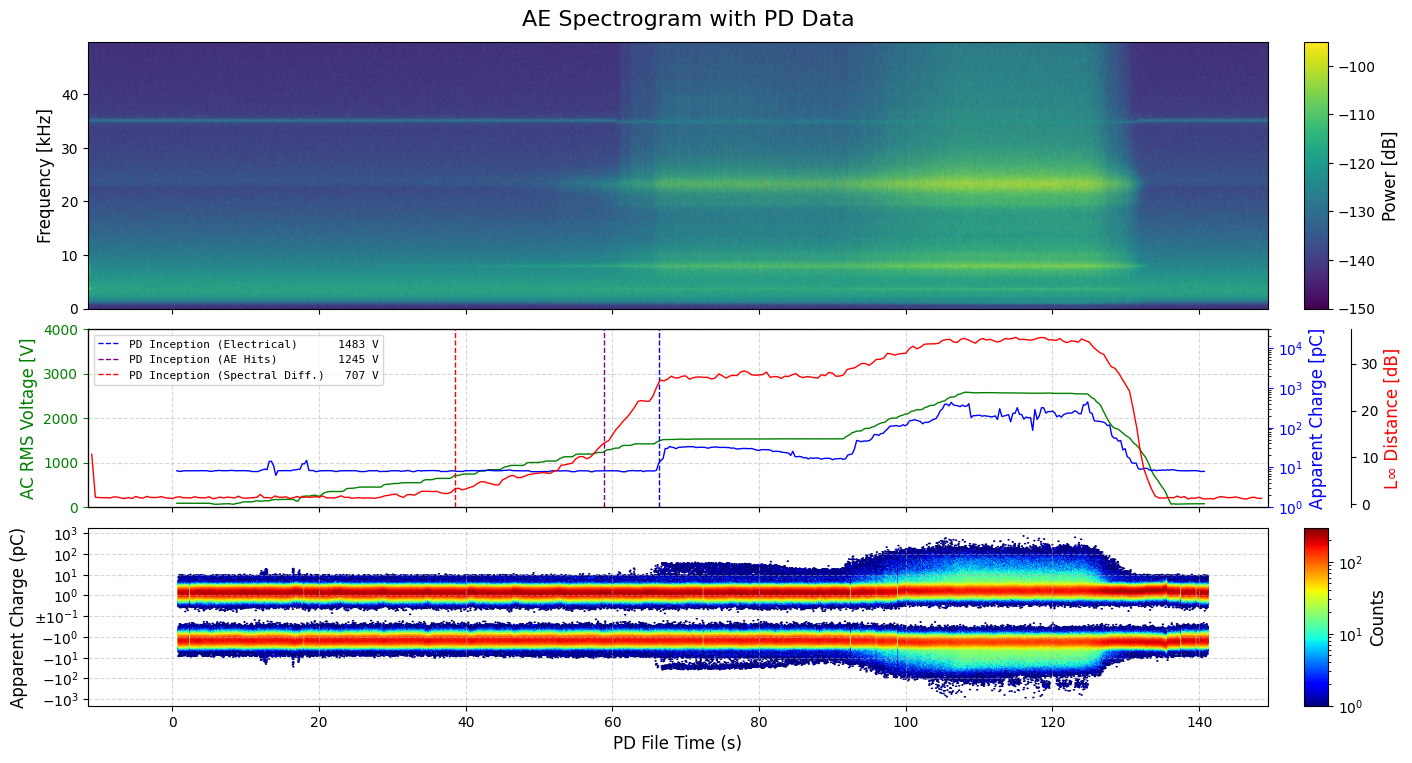

In [128]:
label_fontsize = 12
tick_fontsize = 10

# Create a figure and GridSpec layout: left column for plots, right column for a narrower colorbar
fig = plt.figure(figsize=(16, 8))
gs = fig.add_gridspec(
    nrows=3,
    ncols=2,
    width_ratios=[0.98, 0.02],   # 92% width for plots, 8% for colorbar (narrower)
    height_ratios=[3, 2, 2],        # Spectrogram row taller than waveform row
    hspace=0.10,
    wspace=0.06                  # Small horizontal gap between plots and colorbar
)

ax1 = fig.add_subplot(gs[0, 0])              # Top-left: spectrogram
ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)  # Bottom-left: Apparent charge, voltage, AE trends
ax3 = fig.add_subplot(gs[2, 0], sharex=ax1)  # Bottom-left: PD data
cax = fig.add_subplot(gs[0, 1])              # Top-right: colorbar axis (aligned with spectrogram)
cax3 = fig.add_subplot(gs[2, 1])            # Bottom-right: colorbar axis (aligned with PD data)

# ==== Plot spectrogram on ax1 ====  
xmin = masked_times[0]
xmax = masked_times[-1]
ymin = masked_frequencies[0] / 1e3  # Convert to kHz
ymax = masked_frequencies[-1] / 1e3  # Convert to kHz

spec_img = ax1.imshow(
    masked_Sxx_log,
    extent=[xmin, xmax, ymin, ymax],
    interpolation='bilinear',
    cmap='viridis',
    aspect='auto',
    vmin=min_spectrogram_value_ctrl,
    vmax=max_spectrogram_value_ctrl,
    origin='lower'
)
ax1.set_ylabel('Frequency [kHz]', fontsize=label_fontsize)
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:.0f}'))
ax1.tick_params(axis='both', which='major', labelsize=tick_fontsize)

# # Hide the x-tick labels on ax1, since the bottom-most axis will display shared time axis
ax1.tick_params(axis='x', labelbottom=False)

# Attach colorbar to the narrower cax axis
cbar = fig.colorbar(spec_img, cax=cax, orientation='vertical')
cbar.set_label('Power [dB]', fontsize=label_fontsize)
cbar.ax.tick_params(labelsize=tick_fontsize)

# for pd_start, pd_ext in pd_times:
#     ax1.axvline(pd_start + AE_time_shift + wfm_stream_time_shift, color='red', linestyle='--', linewidth=0.5, label='Partial Discharge Inception')
#     ax1.axvline(pd_ext + AE_time_shift + wfm_stream_time_shift, color='red', linestyle='--', linewidth=0.5, label='Partial Discharge Inception')
#     ax1.axvspan(pd_start + AE_time_shift + wfm_stream_time_shift, pd_ext + AE_time_shift + wfm_stream_time_shift, color='red', alpha=0.1, label='Partial Discharge Inception Window')

# ==== Plot on ax2 ====
ax2.plot(
    MPD_df['Time [s]'], 
    MPD_df['AC Input RMS Voltage [V]'], 
    color='green', 
    linewidth=1.0, 
    # label='AC RMS Voltage [V]'
)
ax2.set_ylim(0, 4e3)  # Set y-limits for AC Input RMS Voltage
ax2.set_ylabel('AC RMS Voltage [V]', fontsize=label_fontsize, color='green')
ax2.grid(True, linestyle='--', alpha=0.5)

# Use AutoLocator for x-axis to get nice, even tick values
ax2.tick_params(axis='x', labelbottom=False)

# Ensure y-axis ticks are visible
ax2.tick_params(axis='y', which='major', labelsize=tick_fontsize, colors='green')
ax2.tick_params(axis='x', which='major', labelsize=tick_fontsize)

# ==== Create a twin y‐axis for Apparent Charge ====
ax2b = ax2.twinx()
ax2b.plot(
    MPD_df['Time [s]'],
    MPD_df['IEC 60270 Apparent Charge (Q_IEC/WTD) [pC]'],
    color='blue',
    linewidth=1.0,
    label='Apparent Charge [pC]'
)
ax2b.set_ylabel('Apparent Charge [pC]', fontsize=label_fontsize, color='blue')
ax2b.tick_params(axis='y', labelsize=tick_fontsize, colors='blue')
ax2b.set_yscale('log')  # Set y-axis to logarithmic scale for better visibility
ax2b.set_ylim(1e0, 3e4)  # Set y-limits for Apparent Charge axis
# ax2b.grid(True, linestyle='--', alpha=0.5)

max_width = max(len(f"{int(v)}") for v in (
    list(elec_inc_voltages) +
    list(ae_hits_inc_voltages) +
    list(ae_spectral_diff_inc_voltages)
))

# Electrical PD inception
for (pdi_start, _), V in zip(elec_times, elec_inc_voltages):
    ax2.axvline(
        pdi_start, color='blue', linestyle='--', linewidth=1.0,
        label=f'PD Inception (Electrical)      {V:>{max_width}.0f} V'
    )

# AE hits PD inception
for (pdi_start, _), V in zip(ae_hits_times, ae_hits_inc_voltages):
    ax2.axvline(
        pdi_start, color='purple', linestyle='--', linewidth=1.0,
        label=f'PD Inception (AE Hits)         {V:>{max_width}.0f} V'
    )

# Spectral-diff PD inception
if ae_spectral_diff_times is not None and ae_spectral_diff_inc_voltages is not None:
    for (pdi_start, _), V in zip(ae_spectral_diff_times, ae_spectral_diff_inc_voltages):
        ax2.axvline(
            pdi_start, color='red', linestyle='--', linewidth=1.0,
            label=f'PD Inception (Spectral Diff.)  {V:>{max_width}.0f} V'
        )

        # ax1.axvspan(pdi_start-.5, pdi_start+.5, color='red', alpha=0.1, label='PD Inception Window')

        # ax2d.axvline(pdi_ext, color='red', linestyle='--', linewidth=0.5, label='PD Extinction')
        # ax1.axvspan(pdi_ext-.5, pdi_ext+.5, color='red', alpha=0.1, label='PD Inception Window')

        # ax1.axvspan(pdi_start, pdi_ext, color='orange', alpha=0.1, label='PD Inception Window')

        # # Add a hatched rectangle inside the region [x1, x2]
        # rect = Rectangle(
        #     (x1, ymin), x2 - x1, ymax - ymin,
        #     facecolor='none',
        #     hatch='////',
        #     lw=0
        # )
        # ax1.add_patch(rect)


# # ==== Create a third y‐axis for AE ====

# ax2c = ax2.twinx()
# ax2c.plot(
#     mistras_tdd_df['TIME'],
#     mistras_tdd_df['ASL_CONTINUOUS'],
#     color='purple',
#     linewidth=0.7,
#     label='ASL [dB]'
# )
# ax2c.set_ylabel('ASL [dB]', fontsize=14, color='purple')
# ax2c.tick_params(axis='y', labelsize=12, colors='purple')
# ax2c.spines['right'].set_position(('outward', 60))  # Offset the third y-axis
# ax2c.set_ylim(15, 35)  # Set y-limits for AE axis


# ax2c = ax2.twinx()
# ax2c.scatter(
#     mistras_df['TIME'],
#     mistras_df['ABS-ENERGY'],
#     color='purple',
#     s=1,
#     label='ABS-ENERGY [dB]'
# )
# ax2c.set_ylabel('ASL [dB]', fontsize=label_fontsize, color='purple')
# ax2c.tick_params(axis='y', labelsize=tick_fontsize, colors='purple')
# ax2c.spines['right'].set_position(('outward', 60))  # Offset the y-axis
# # ax2c.set_ylim(15, 35)  # Set y-limits for AE axis

if L_inf_psd_distances is not None:
    ax2d = ax2.twinx()
    ax2d.plot(
        psd_times,
        L_inf_psd_distances,
        color='red',
        linewidth=1.0,
        label='L-Inf Distance'
    )
    ax2d.set_ylabel('L∞ Distance [dB]', fontsize=label_fontsize, color='red')
    ax2d.spines['right'].set_position(('outward', 60))  # Offset the third y-axis

ax2_legend = ax2.legend(loc='upper left', fontsize=8)
for text in ax2_legend.get_texts():
    text.set_fontfamily('monospace')

time = pd_data[:, 0]
measurements = pd_data[:, 1]

# 1) mask exact zeros
mask    = measurements != 0
x       = time[mask]
y_raw   = measurements[mask]*1e12  # Convert to pC

# 2) true log10 of magnitudes
log_abs = np.log10(np.abs(y_raw))

# 3) integer bounds
exp_min = int(np.floor(log_abs.min()))   # e.g. -13
exp_max = int(np.ceil (log_abs.max()))   # e.g.  -8

# 4) shift so smallest magnitude → 0, largest → (exp_max - exp_min)
m       = log_abs - exp_min
M       = exp_max - exp_min

# 5) signed‑shifted coordinate
y_sym   = np.sign(y_raw) * m
hb = ax3.hexbin(
    x, y_sym,
    gridsize=1000,
    cmap='jet',
    norm=LogNorm(vmin=1),
    mincnt=1
)
# Attach colorbar to the narrower cax axis
cbar3 = fig.colorbar(hb, cax=cax3, orientation='vertical')
cbar3.set_label('Counts', fontsize=label_fontsize)
cbar3.ax.tick_params(labelsize=tick_fontsize)

# 7) tick locations from -M…0…+M
ticks = np.arange(-M, M+1)

# 8) labels back to ±10^n using our integer exp_min
labels = []
for t in ticks:
    if  t >  0:
        # positive side → +10^(exp_min + t)
        labels.append(f"$10^{{{exp_min + t}}}$")
    elif t <  0:
        # negative side → -10^(exp_min + |t|)
        labels.append(f"$-10^{{{exp_min + abs(t)}}}$")
    else:
        # center → the smallest magnitude
        labels.append(f"$±10^{{{exp_min}}}$")
ax3.set_yticks(ticks)
ax3.set_yticklabels(labels)

# 9) formatting
ax3.set_ylabel('Apparent Charge (pC)', fontsize=label_fontsize)
ax3.grid(True, linestyle='--', alpha=0.5)

# Set x-axis
ax3.set_xlabel('PD File Time (s)', fontsize=label_fontsize)
ax3.set_xlim(xmin, xmax)
ax3.xaxis.set_major_locator(mticker.MaxNLocator(integer=False))


# (Optional) If you want a legend that shows both curves:
# lines_v, labels_v = ax2.get_legend_handles_labels()
# lines_pc,   labels_pc   = ax2b.get_legend_handles_labels()
# lines_ae, labels_ae = ax2c.get_legend_handles_labels()
# ax2.legend(
#     lines_pc + lines_v + lines_ae,
#     labels_pc + labels_v + labels_ae,
#     loc='upper left',
#     fontsize=8
# )

fig.subplots_adjust(top=0.94)  # Lower the top of the subplots, leaving room for suptitle


# x_list = [51.1, 52.1, 53.1, 54.1, 55.1]  # etc.
# for x in x_list:
#     ax1.axvline(x=x, color='white', linestyle='--', alpha=0.1, linewidth=0.8)

# x_list = [.5 + x for x in range(-100, 160)]  # Example: 51.1, 52.1, ..., 60.1
# ax1.vlines(x_list, ymin=90, ymax=125, colors='white', linestyles='--', linewidth=0.8)


plt.suptitle(
    f"AE Spectrogram with PD Data",
    # f"\nStart Time: {MPD_metadata['start_time']}, Duration: {MPD_metadata['duration']} s",
    fontsize=16
)

# Build the save path for the image
save_path = os.path.join(images_dir, f"{parent_name}_spectral_diff_combined_plot.png")
print(f"Saving spectrogram image to \"{save_path}\"")

# Save before showing
plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.show()
plt.close('all')

Saving spectrogram image to "C:\Users\sapierso\Box\PD-Acoustic Project Data\0_FormattedData\PD-acoustic170\images\PD-acoustic170_ae_hits_combined_plot.png"


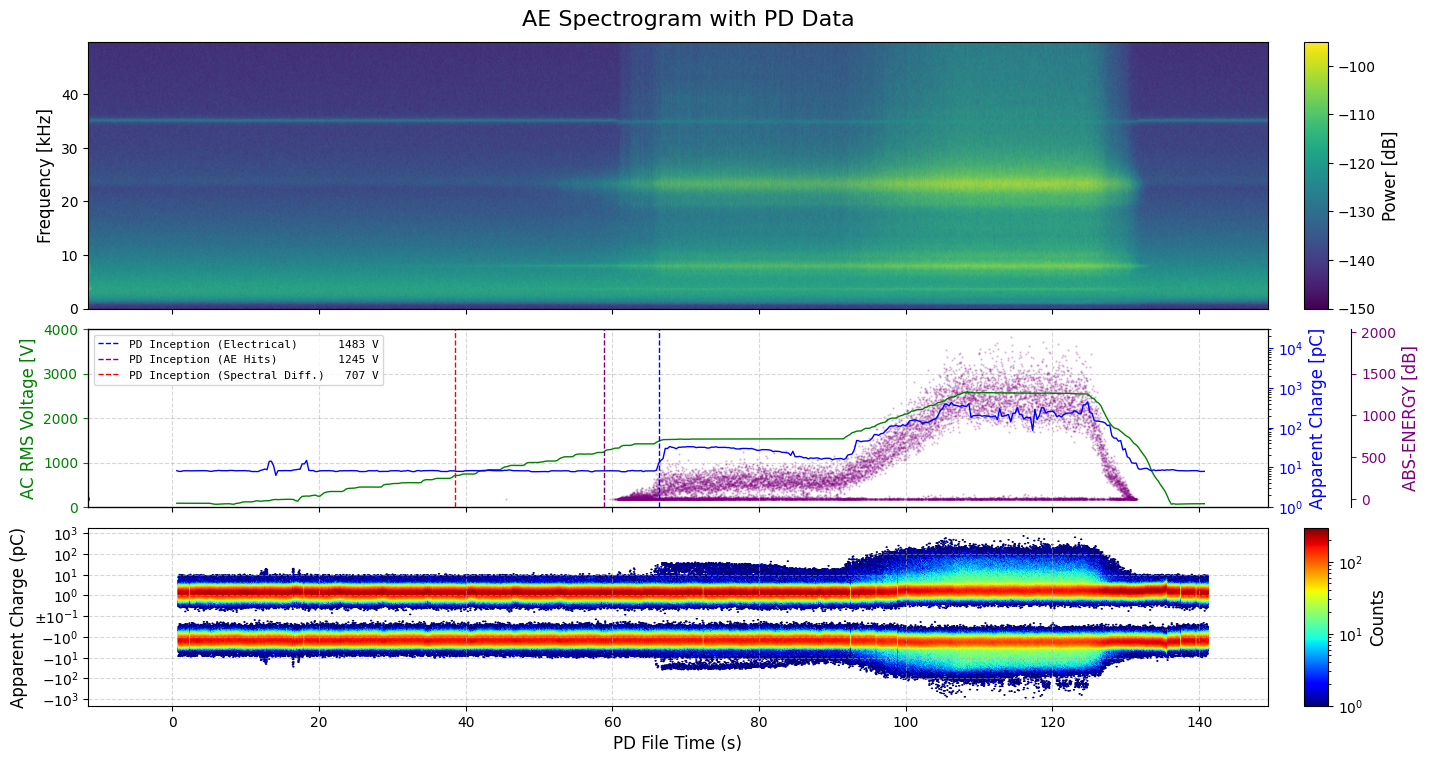

In [129]:
label_fontsize = 12
tick_fontsize = 10

# Create a figure and GridSpec layout: left column for plots, right column for a narrower colorbar
fig = plt.figure(figsize=(16, 8))
gs = fig.add_gridspec(
    nrows=3,
    ncols=2,
    width_ratios=[0.98, 0.02],   # 92% width for plots, 8% for colorbar (narrower)
    height_ratios=[3, 2, 2],        # Spectrogram row taller than waveform row
    hspace=0.10,
    wspace=0.06                  # Small horizontal gap between plots and colorbar
)

ax1 = fig.add_subplot(gs[0, 0])              # Top-left: spectrogram
ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)  # Bottom-left: Apparent charge, voltage, AE trends
ax3 = fig.add_subplot(gs[2, 0], sharex=ax1)  # Bottom-left: PD data
cax = fig.add_subplot(gs[0, 1])              # Top-right: colorbar axis (aligned with spectrogram)
cax3 = fig.add_subplot(gs[2, 1])            # Bottom-right: colorbar axis (aligned with PD data)

# ==== Plot spectrogram on ax1 ====  
xmin = masked_times[0]
xmax = masked_times[-1]
ymin = masked_frequencies[0] / 1e3  # Convert to kHz
ymax = masked_frequencies[-1] / 1e3  # Convert to kHz

spec_img = ax1.imshow(
    masked_Sxx_log,
    extent=[xmin, xmax, ymin, ymax],
    interpolation='bilinear',
    cmap='viridis',
    aspect='auto',
    vmin=min_spectrogram_value_ctrl,
    vmax=max_spectrogram_value_ctrl,
    origin='lower'
)
ax1.set_ylabel('Frequency [kHz]', fontsize=label_fontsize)
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:.0f}'))
ax1.tick_params(axis='both', which='major', labelsize=tick_fontsize)

# # Hide the x-tick labels on ax1, since the bottom-most axis will display shared time axis
ax1.tick_params(axis='x', labelbottom=False)

# Attach colorbar to the narrower cax axis
cbar = fig.colorbar(spec_img, cax=cax, orientation='vertical')
cbar.set_label('Power [dB]', fontsize=label_fontsize)
cbar.ax.tick_params(labelsize=tick_fontsize)

# for pd_start, pd_ext in pd_times:
#     ax1.axvline(pd_start + AE_time_shift + wfm_stream_time_shift, color='red', linestyle='--', linewidth=0.5, label='Partial Discharge Inception')
#     ax1.axvline(pd_ext + AE_time_shift + wfm_stream_time_shift, color='red', linestyle='--', linewidth=0.5, label='Partial Discharge Inception')
#     ax1.axvspan(pd_start + AE_time_shift + wfm_stream_time_shift, pd_ext + AE_time_shift + wfm_stream_time_shift, color='red', alpha=0.1, label='Partial Discharge Inception Window')

# ==== Plot on ax2 ====
ax2.plot(
    MPD_df['Time [s]'], 
    MPD_df['AC Input RMS Voltage [V]'], 
    color='green', 
    linewidth=1.0, 
    # label='AC RMS Voltage [V]'
)
ax2.set_ylim(0, 4e3)  # Set y-limits for AC Input RMS Voltage
ax2.set_ylabel('AC RMS Voltage [V]', fontsize=label_fontsize, color='green')
ax2.grid(True, linestyle='--', alpha=0.5)

# Use AutoLocator for x-axis to get nice, even tick values
ax2.tick_params(axis='x', labelbottom=False)

# Ensure y-axis ticks are visible
ax2.tick_params(axis='y', which='major', labelsize=tick_fontsize, colors='green')
ax2.tick_params(axis='x', which='major', labelsize=tick_fontsize)

# ==== Create a twin y‐axis for Apparent Charge ====
ax2b = ax2.twinx()
ax2b.plot(
    MPD_df['Time [s]'],
    MPD_df['IEC 60270 Apparent Charge (Q_IEC/WTD) [pC]'],
    color='blue',
    linewidth=1.0,
    # label='Apparent Charge [pC]',
)
ax2b.set_ylabel('Apparent Charge [pC]', fontsize=label_fontsize, color='blue')
ax2b.tick_params(axis='y', labelsize=tick_fontsize, colors='blue')
ax2b.set_yscale('log')  # Set y-axis to logarithmic scale for better visibility
ax2b.set_ylim(1e0, 3e4)  # Set y-limits for Apparent Charge axis
# ax2b.grid(True, linestyle='--', alpha=0.5)

max_width = max(len(f"{int(v)}") for v in (
    list(elec_inc_voltages) +
    list(ae_hits_inc_voltages) +
    list(ae_spectral_diff_inc_voltages)
))

# Electrical PD inception
for (pdi_start, _), V in zip(elec_times, elec_inc_voltages):
    ax2.axvline(
        pdi_start, color='blue', linestyle='--', linewidth=1.0,
        label=f'PD Inception (Electrical)      {V:>{max_width}.0f} V'
    )

# AE hits PD inception
for (pdi_start, _), V in zip(ae_hits_times, ae_hits_inc_voltages):
    ax2.axvline(
        pdi_start, color='purple', linestyle='--', linewidth=1.0,
        label=f'PD Inception (AE Hits)         {V:>{max_width}.0f} V'
    )

# Spectral-diff PD inception
if ae_spectral_diff_times is not None and ae_spectral_diff_inc_voltages is not None:
    for (pdi_start, _), V in zip(ae_spectral_diff_times, ae_spectral_diff_inc_voltages):
        ax2.axvline(
            pdi_start, color='red', linestyle='--', linewidth=1.0,
            label=f'PD Inception (Spectral Diff.)  {V:>{max_width}.0f} V'
        )
        # ax1.axvspan(pdi_start-.5, pdi_start+.5, color='red', alpha=0.1, label='PD Inception Window')

        # ax2.axvline(pdi_ext, color='red', linestyle='--', linewidth=0.5, label='PD Extinction')
        # ax1.axvspan(pdi_ext-.5, pdi_ext+.5, color='red', alpha=0.1, label='PD Inception Window')

        # ax1.axvspan(pdi_start, pdi_ext, color='orange', alpha=0.1, label='PD Inception Window')

        # # Add a hatched rectangle inside the region [x1, x2]
        # rect = Rectangle(
        #     (x1, ymin), x2 - x1, ymax - ymin,
        #     facecolor='none',
        #     hatch='////',
        #     lw=0
        # )
        # ax1.add_patch(rect)


# # ==== Create a third y‐axis for AE ====

# ax2c = ax2.twinx()
# ax2c.plot(
#     mistras_tdd_df['TIME'],
#     mistras_tdd_df['ASL_CONTINUOUS'],
#     color='purple',
#     linewidth=0.7,
#     label='ASL [dB]'
# )
# ax2c.set_ylabel('ASL [dB]', fontsize=14, color='purple')
# ax2c.tick_params(axis='y', labelsize=12, colors='purple')
# ax2c.spines['right'].set_position(('outward', 60))  # Offset the third y-axis
# ax2c.set_ylim(15, 35)  # Set y-limits for AE axis


ax2c = ax2.twinx()
ax2c.scatter(
    mistras_df['TIME'],
    mistras_df['ABS-ENERGY'],
    color='purple',
    s=0.5,
    alpha=0.2,
    label='ABS-ENERGY [dB]',
)
ax2c.set_ylabel('ABS-ENERGY [dB]', fontsize=label_fontsize, color='purple')
ax2c.tick_params(axis='y', labelsize=tick_fontsize, colors='purple')
ax2c.spines['right'].set_position(('outward', 60))  # Offset the y-axis
# ax2c.set_ylim(15, 35)  # Set y-limits for AE axis

# if L_inf_psd_distances is not None:
#     ax2d = ax2.twinx()
#     ax2d.plot(
#         psd_times,
#         L_inf_psd_distances,
#         color='red',
#         linewidth=0.7,
#         label='L-Inf Distance'
#     )
#     ax2d.set_ylabel('L∞ Distance [dB]', fontsize=label_fontsize, color='red')
#     ax2d.spines['right'].set_position(('outward', 60))  # Offset the third y-axis

ax2.legend(loc='upper left', fontsize=8)
ax2_legend = ax2.legend(loc='upper left', fontsize=8)
for text in ax2_legend.get_texts():
    text.set_fontfamily('monospace')

time = pd_data[:, 0]
measurements = pd_data[:, 1]

# 1) mask exact zeros
mask    = measurements != 0
x       = time[mask]
y_raw   = measurements[mask]*1e12  # Convert to pC

# 2) true log10 of magnitudes
log_abs = np.log10(np.abs(y_raw))

# 3) integer bounds
exp_min = int(np.floor(log_abs.min()))   # e.g. -13
exp_max = int(np.ceil (log_abs.max()))   # e.g.  -8

# 4) shift so smallest magnitude → 0, largest → (exp_max - exp_min)
m       = log_abs - exp_min
M       = exp_max - exp_min

# 5) signed‑shifted coordinate
y_sym   = np.sign(y_raw) * m
hb = ax3.hexbin(
    x, y_sym,
    gridsize=1000,
    cmap='jet',
    norm=LogNorm(vmin=1),
    mincnt=1
)
# Attach colorbar to the narrower cax axis
cbar3 = fig.colorbar(hb, cax=cax3, orientation='vertical')
cbar3.set_label('Counts', fontsize=label_fontsize)
cbar3.ax.tick_params(labelsize=tick_fontsize)

# 7) tick locations from -M…0…+M
ticks = np.arange(-M, M+1)

# 8) labels back to ±10^n using our integer exp_min
labels = []
for t in ticks:
    if   t >  0:
        # positive side → +10^(exp_min + t)
        labels.append(f"$10^{{{exp_min + t}}}$")
    elif t <  0:
        # negative side → -10^(exp_min + |t|)
        labels.append(f"$-10^{{{exp_min + abs(t)}}}$")
    else:
        # center → the smallest magnitude
        labels.append(f"$±10^{{{exp_min}}}$")
ax3.set_yticks(ticks)
ax3.set_yticklabels(labels)

# 9) formatting
ax3.set_ylabel('Apparent Charge (pC)', fontsize=label_fontsize)
ax3.grid(True, linestyle='--', alpha=0.5)

# Set x-axis
ax3.set_xlabel('PD File Time (s)', fontsize=label_fontsize)
ax3.set_xlim(xmin, xmax)
ax3.xaxis.set_major_locator(mticker.MaxNLocator(integer=False))


# (Optional) If you want a legend that shows both curves:
# lines_v, labels_v = ax2.get_legend_handles_labels()
# lines_pc,   labels_pc   = ax2b.get_legend_handles_labels()
# lines_ae, labels_ae = ax2c.get_legend_handles_labels()
# ax2.legend(
#     lines_pc + lines_v + lines_ae,
#     labels_pc + labels_v + labels_ae,
#     loc='upper left',
#     fontsize=8
# )

fig.subplots_adjust(top=0.94)  # Lower the top of the subplots, leaving room for suptitle


# x_list = [51.1, 52.1, 53.1, 54.1, 55.1]  # etc.
# for x in x_list:
#     ax1.axvline(x=x, color='white', linestyle='--', alpha=0.1, linewidth=0.8)

# x_list = [.5 + x for x in range(-100, 160)]  # Example: 51.1, 52.1, ..., 60.1
# ax1.vlines(x_list, ymin=90, ymax=125, colors='white', linestyles='--', linewidth=0.8)

# Put the voltage + charge axes above the AE scatter axis
ax2.set_zorder(3)   # green line axis
ax2b.set_zorder(4)  # blue line axis
ax2c.set_zorder(2)  # purple dots axis (lowest)

# Make axis facecolors transparent so higher z-order axes don't hide lower ones
for a in (ax2, ax2b, ax2c):
    a.patch.set_alpha(0)

plt.suptitle(
    f"AE Spectrogram with PD Data",
    # f"\nStart Time: {MPD_metadata['start_time']}, Duration: {MPD_metadata['duration']} s",
    fontsize=16
)

# Build the save path for the image
save_path = os.path.join(images_dir, f"{parent_name}_ae_hits_combined_plot.png")
print(f"Saving spectrogram image to \"{save_path}\"")

# Save before showing
plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.show()
plt.close('all')

Saving image to "C:\Users\sapierso\Box\PD-Acoustic Project Data\0_FormattedData\PD-acoustic170\images\PD-acoustic170_ASL_combined_plot.png"


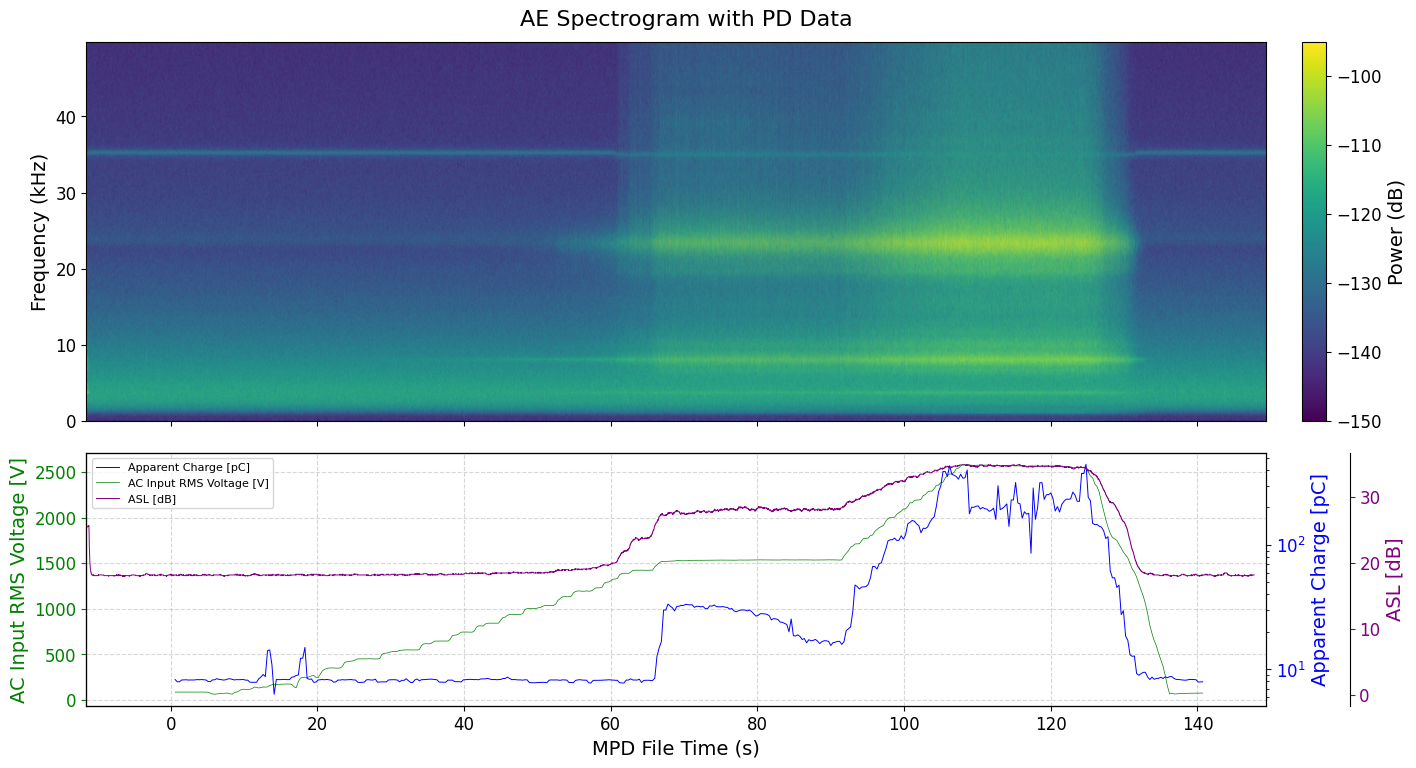

In [139]:
# Create a figure and GridSpec layout: left column for plots, right column for a narrower colorbar
fig = plt.figure(figsize=(16, 8))
gs = fig.add_gridspec(
    nrows=2,
    ncols=2,
    width_ratios=[0.98, 0.02],   # % width for plots, % for colorbar (narrower)
    height_ratios=[3, 2],        # Spectrogram row taller than waveform row
    hspace=0.10,
    wspace=0.06                  # Small horizontal gap between plots and colorbar
)

ax1 = fig.add_subplot(gs[0, 0])              # Top-left: spectrogram
ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)  # Bottom-left: AE waveform, shares x-axis
cax = fig.add_subplot(gs[0, 1])              # Top-right: colorbar axis (aligned with spectrogram)

# ==== Plot spectrogram on ax1 ====  
spec_img = ax1.imshow(
    masked_Sxx_log,
    extent=[xmin, xmax, ymin, ymax],
    interpolation='bilinear',
    cmap='viridis',
    aspect='auto',
    vmin=min_spectrogram_value_ctrl,
    vmax=max_spectrogram_value_ctrl,
    origin='lower'
)
ax1.set_ylabel('Frequency (kHz)', fontsize=14)
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:.0f}'))
ax1.tick_params(axis='both', which='major', labelsize=12)

# # Hide the x-tick labels on ax1, since ax2 will display shared time axis
ax1.tick_params(axis='x', labelbottom=False)

# Attach colorbar to the narrower cax axis
cbar = fig.colorbar(spec_img, cax=cax, orientation='vertical')
cbar.set_label('Power (dB)', fontsize=14)
cbar.ax.tick_params(labelsize=12)


# ==== Plot on ax2 ====
ax2.plot(
    MPD_df['Time [s]'], 
    MPD_df['AC Input RMS Voltage [V]'], 
    color='green', 
    linewidth=0.5, 
    label='AC Input RMS Voltage [V]'
)
ax2.set_ylabel('AC Input RMS Voltage [V]', fontsize=14, color='green')
ax2.grid(True, linestyle='--', alpha=0.5)

# Use AutoLocator for x-axis to get nice, even tick values
ax2.set_xlim(xmin, xmax)
ax2.xaxis.set_major_locator(mticker.MaxNLocator(integer=False))

# Set x-axis label on ax2
ax2.set_xlabel('MPD File Time (s)', fontsize=14)

# Ensure y-axis ticks are visible
ax2.tick_params(axis='y', which='major', labelsize=12, colors='green')
ax2.tick_params(axis='x', which='major', labelsize=12)

# ==== Create a twin y‐axis for Apparent Charge ====
ax2b = ax2.twinx()
ax2b.plot(
    MPD_df['Time [s]'],
    MPD_df['IEC 60270 Apparent Charge (Q_IEC/WTD) [pC]'],
    color='blue',
    linewidth=0.7,
    label='Apparent Charge [pC]'
)
ax2b.set_yscale('log')  # Set y-axis to logarithmic scale
ax2b.set_ylabel('Apparent Charge [pC]', fontsize=14, color='blue')
ax2b.tick_params(axis='y', labelsize=12, colors='blue')


# ==== Create a third y‐axis for AE ====
ax2c = ax2.twinx()
ax2c.plot(
    mistras_tdd_df['TIME'],
    mistras_tdd_df['ASL_CONTINUOUS'],
    color='purple',
    linewidth=0.7,
    label='ASL [dB]'
)
ax2c.set_ylabel('ASL [dB]', fontsize=14, color='purple')
ax2c.tick_params(axis='y', labelsize=12, colors='purple')
ax2c.spines['right'].set_position(('outward', 60))  # Offset the third y-axis


# (Optional) If you want a legend that shows both curves:
lines_v, labels_v = ax2.get_legend_handles_labels()
lines_pc,   labels_pc   = ax2b.get_legend_handles_labels()
lines_ae, labels_ae = ax2c.get_legend_handles_labels()
ax2.legend(
    lines_pc + lines_v + lines_ae,
    labels_pc + labels_v + labels_ae,
    loc='upper left',
    fontsize=8
)

fig.subplots_adjust(top=0.94)  # Lower the top of the subplots, leaving room for suptitle
plt.suptitle(
    f"AE Spectrogram with PD Data",
    # f"Start Time: {MPD_metadata['start_time']}, Duration: {MPD_metadata['duration']} s",
    fontsize=16
)

# Build the save path for the image
save_path = os.path.join(images_dir, f"{parent_name}_ASL_combined_plot.png")
print(f"Saving image to \"{save_path}\"")

# Save before showing
plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.show()
plt.close('all')

In [75]:
# # 4) Create a figure and GridSpec layout: left column for plots, right column for a narrower colorbar
# fig = plt.figure(figsize=(16, 8))
# gs = fig.add_gridspec(
#     nrows=2,
#     ncols=2,
#     width_ratios=[0.98, 0.02],   # 92% width for plots, 8% for colorbar (narrower)
#     height_ratios=[3, 2],        # Spectrogram row taller than waveform row
#     hspace=0.10,
#     wspace=0.06                  # Small horizontal gap between plots and colorbar
# )

# ax1 = fig.add_subplot(gs[0, 0])              # Top-left: spectrogram
# ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)  # Bottom-left: AE waveform, shares x-axis
# cax = fig.add_subplot(gs[0, 1])              # Top-right: colorbar axis (aligned with spectrogram)

# # ==== Plot spectrogram on ax1 ====  
# spec_img = ax1.imshow(
#     masked_Sxx_log,
#     extent=[xmin, xmax, masked_frequencies[-1]/1e3, masked_frequencies[0]/1e3],
#     interpolation='bilinear',
#     cmap='viridis',
#     aspect='auto',
#     vmin=min_spectrogram_value_ctrl,
#     vmax=max_spectrogram_value_ctrl
# )
# ax1.set_xlim(xmin, xmax)
# ax1.invert_yaxis()
# ax1.set_ylabel('Frequency (kHz)', fontsize=14)
# ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:.0f}'))
# ax1.tick_params(axis='both', which='major', labelsize=12)

# # # Hide the x-tick labels on ax1, since ax2 will display shared time axis
# ax1.tick_params(axis='x', labelbottom=False)

# # Attach colorbar to the narrower cax axis
# cbar = fig.colorbar(spec_img, cax=cax, orientation='vertical')
# cbar.set_label('Power (dB)', fontsize=14)
# cbar.ax.tick_params(labelsize=12)

# # ==== Plot AE waveform on ax2 ====
# ae_time = masked_ae_data[:, 0] + AE_time_shift + wfm_stream_time_shift
# ae_signal = masked_ae_data[:, 1]
# ax2.plot(ae_time, ae_signal, color='k', linewidth=0.5)
# ax2.set_ylim(-0.001, 0.001)  # Set y-limits for AE Signal
# ax2.set_ylabel('AE Signal (V)', fontsize=14)
# ax2.grid(True, linestyle='--', alpha=0.5)

# # Use AutoLocator for x-axis to get nice, even tick values
# # ax2.set_xlim(times[0], times[-1])
# ax2.xaxis.set_major_locator(mticker.MaxNLocator(integer=False))

# # Set x-axis label on ax2
# ax2.set_xlabel('Time (s)', fontsize=14)

# # Ensure y-axis ticks are visible
# ax2.tick_params(axis='y', which='major', labelsize=12)
# ax2.tick_params(axis='x', which='major', labelsize=12)

# plt.show()

# plt.close('all')

In [76]:
# ----------------------------------------------------------------------
# 1)  ── PRE-COMPUTE A FULL-LENGTH SPECTROGRAM ─────────────────────────
# ----------------------------------------------------------------------
vmin        = min_spectrogram_value_ctrl   # robust global limits
vmax        = max_spectrogram_value_ctrl

# ----------------------------------------------------------------------
# 2)  ── ASK THE USER IF THEY WANT A VIDEO ─────────────────────────────
# ----------------------------------------------------------------------
while True:
    make_video = input("Generate sliding-window spectrogram video? (y/n): ").strip().lower()
    if make_video in ("y", "n"):
        break
    print("Please enter 'y' or 'n'.")

if make_video == "n":
    raise SystemExit("OK – nothing to do.")

# ----------------------------------------------------------------------
# 3)  ── VIDEO SETTINGS YOU MAY TWEAK ──────────────────────────────────
# ----------------------------------------------------------------------
FPS         = 4            # video frame-rate
WINDOW_LEN  = 2.0          # seconds shown in each frame
STEP        = 0.5          # seconds between two successive frames
DPI         = 150
OUTFILE     = f"spectrogram_{WINDOW_LEN}swin_{STEP}sstep_{FPS}fps.mp4"

# ----------------------------------------------------------------------
# 4)  ── STATIC FIGURE/AXES BOILERPLATE (done once) ────────────────────
# ----------------------------------------------------------------------
mpl.rcParams.update({"font.size": 12})
fig, ax = plt.subplots(figsize=(16, 7), dpi=DPI)

# dummy 2-D array so that imshow exists before the first update()
im = ax.imshow(
    np.zeros((len(masked_frequencies), 1)),
    extent=[0, WINDOW_LEN, masked_frequencies[-1]/1e3, masked_frequencies[0]/1e3],
    interpolation="bilinear",
    cmap="viridis",
    aspect="auto",
    vmin=vmin, vmax=vmax,
    origin="lower",
)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Frequency (kHz)")
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{x:.0f}"))
cbar = fig.colorbar(im, ax=ax, fraction=0.05, pad=0.04)
cbar.set_label("Power (dB)")
plt.subplots_adjust(right=0.88)

# ----------------------------------------------------------------------
# 5)  ── ANIMATION CORE ────────────────────────────────────────────────
# ----------------------------------------------------------------------
def frame_gen():
    """Yield successive (mask, start_time) pairs covering the whole clip."""
    starts = np.arange(spec_times[0], spec_times[-1] - WINDOW_LEN + 1e-9, STEP)
    for s in starts:
        col_mask = (spec_times >= s) & (spec_times < s + WINDOW_LEN)
        yield col_mask, s

def update(frame):
    col_mask, s = frame
    if not np.any(col_mask):
        return (im,)                           # empty window – skip

    window_img = masked_Sxx_log[:, col_mask]          # slice columns only
    im.set_data(window_img)
    im.set_extent([s, s + WINDOW_LEN, masked_frequencies[0], masked_frequencies[-1]])
    ax.set_title(f"Sliding-window spectrogram   $t = {s:6.2f}$–{s + WINDOW_LEN:6.2f} s")
    return (im,)

anim = animation.FuncAnimation(
    fig, update, frames=frame_gen(), blit=False, interval=1000 / FPS
)

# ----------------------------------------------------------------------
# 6)  ── SAVE TO DISK (requires ffmpeg in PATH) ────────────────────────
# ----------------------------------------------------------------------
writer = animation.FFMpegWriter(fps=FPS, bitrate=1800)
anim.save(OUTFILE, writer=writer)
print(f"Video written to {OUTFILE}")


SystemExit: OK – nothing to do.

c:\Users\sapierso\AppData\Local\anaconda3\envs\Pierson_ML\lib\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cv2
import os
from tqdm import tqdm
from matplotlib.backends.backend_agg import FigureCanvasAgg

In [ ]:
def create_spectrogram_sliding_window_video_optimized(spectrogram, t, frqs, 
                                                    min_spectrogram_value_ctrl, max_spectrogram_value_ctrl,
                                                    window_size_seconds=2.0, playback_speed=1.0, fps=30,
                                                    output_filename='spectrogram_video.mp4',
                                                    cmap='viridis', figure_width=1600, figure_height=700,
                                                    label_size=14, tick_size=12):
    """
    Create a sliding window video from spectrogram data with time and frequency information - optimized version
    
    Parameters:
    -----------
    spectrogram : numpy.ndarray
        The spectrogram data
    t : numpy.ndarray
        Time values
    frqs : numpy.ndarray
        Frequency values
    min_spectrogram_value_ctrl, max_spectrogram_value_ctrl : float
        Min and max values for spectrogram color mapping
    window_size_seconds : float, optional
        Size of the viewing window in seconds
    playback_speed : float, optional
        Speed multiplier for playback (e.g., 2.0 means the video advances 2 seconds of data per 1 second of playback)
    fps : int, optional
        Frames per second of the output video
    output_filename : str, optional
        Path to save the output video
    cmap : str, optional
        Colormap for the spectrogram
    figure_width, figure_height : int, optional
        Dimensions of the output video in pixels
    label_size, tick_size : int, optional
        Font sizes for labels and ticks
    """
    # Calculate step size based on playback speed and fps
    step_size_seconds = playback_speed / fps
    
    # Calculate window size and step size in time indices
    time_resolution = t[1] - t[0]
    window_size_indices = int(window_size_seconds / time_resolution)
    step_size_indices = max(1, int(step_size_seconds / time_resolution))
    
    # Calculate the number of frames
    num_frames = (len(t) - window_size_indices) // step_size_indices + 1
    
    # Calculate video dimensions
    video_width = figure_width
    video_height = figure_height
    
    # Height of the overview
    overview_height = int(video_height * 0.15)
    main_height = video_height - overview_height - 10  # 10px padding
    
    # Initialize the video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # or 'avc1' for h.264
    video = cv2.VideoWriter(output_filename, fourcc, fps, (video_width, video_height))
    
    # ============ KEY OPTIMIZATION: Pre-render the overview only once ============
    print("Creating overview spectrogram...")
    fig_overview, ax_overview = plt.subplots(figsize=(video_width/100, overview_height/100), dpi=100)
    overview_img = ax_overview.imshow(
        spectrogram,
        extent=[t[0], t[-1], frqs[-1], frqs[0]],
        interpolation='bilinear',
        cmap=cmap,
        aspect='auto',
        vmin=min_spectrogram_value_ctrl,
        vmax=max_spectrogram_value_ctrl
    )
    ax_overview.invert_yaxis()
    ax_overview.set_xlabel('Time (s)', fontsize=tick_size-2)
    ax_overview.tick_params(axis='both', which='major', labelsize=tick_size-2)
    plt.tight_layout()
    
    # Convert to image directly using FigureCanvasAgg (faster than savefig)
    canvas = FigureCanvasAgg(fig_overview)
    canvas.draw()
    overview_array = np.array(canvas.buffer_rgba())[:, :, :3]
    overview_img = cv2.cvtColor(overview_array, cv2.COLOR_RGB2BGR)
    plt.close(fig_overview)
    
    # Resize to fit the video dimensions
    overview_img = cv2.resize(overview_img, (video_width, overview_height))
    
    # ============ KEY OPTIMIZATION: Create and reuse a single figure for all frames ============
    print("Creating template for main window...")
    # Create the main window template figure and axes - will be reused for all frames
    fig, ax = plt.subplots(figsize=(figure_width/100, main_height/100), dpi=100)
    
    # Create the initial imshow object - we'll update its data for each frame
    img = ax.imshow(
        spectrogram[:, :window_size_indices],
        extent=[t[0], t[window_size_indices], frqs[-1], frqs[0]],
        interpolation='bilinear',
        cmap=cmap,
        aspect='auto',
        vmin=min_spectrogram_value_ctrl,
        vmax=max_spectrogram_value_ctrl
    )
    ax.invert_yaxis()
    
    # Set up all the static elements that don't change between frames
    ax.set_ylabel('Frequency (Hz)', fontsize=label_size)
    ax.set_xlabel('Time (s)', fontsize=label_size)
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: '{:.0f}'.format(x)))
    cbar = fig.colorbar(img, ax=ax, fraction=0.05, pad=0.04)
    cbar.set_label('Power (dB)', fontsize=label_size)
    cbar.ax.tick_params(labelsize=tick_size)
    ax.tick_params(axis='both', which='major', labelsize=tick_size)
    
    # Create a title object that we'll update for each frame
    title = ax.set_title('', fontsize=label_size+2)
    
    # Prepare the canvas for fast rendering
    canvas = FigureCanvasAgg(fig)
    
    # Create frames with simple inline progress bar
    print(f"Creating {num_frames} frames...")
    import sys
    
    # Function to create a simple inline progress bar
    def print_progress_bar(current, total, bar_length=50):
        percent = float(current) * 100 / total
        arrow = '=' * int(percent / 100 * bar_length - 1) + '>'
        spaces = ' ' * (bar_length - len(arrow))
        
        sys.stdout.write(f"\rProgress: [{arrow}{spaces}] {percent:.1f}% ({current}/{total})")
        sys.stdout.flush()
    
    for frame_idx in range(num_frames):
        # Update the progress bar
        print_progress_bar(frame_idx + 1, num_frames)
        
        # Calculate window indices and times
        start_idx = frame_idx * step_size_indices
        end_idx = min(start_idx + window_size_indices, len(t) - 1)
        start_time = t[start_idx]
        end_time = t[end_idx]
        
        # ============ KEY OPTIMIZATION: Update only what changes ============
        # Update the image data
        img.set_data(spectrogram[:, start_idx:end_idx])
        
        # Update the extent to match the current window
        img.set_extent([start_time, end_time, frqs[-1], frqs[0]])
        
        # Update the title
        title.set_text(f'Window: {start_time:.2f}s - {end_time:.2f}s')
        
        # ============ KEY OPTIMIZATION: Fast rendering ============
        # Redraw the canvas (much faster than savefig)
        canvas.draw()
        
        # Convert to numpy array directly (no file I/O)
        main_array = np.array(canvas.buffer_rgba())[:, :, :3]
        main_img = cv2.cvtColor(main_array, cv2.COLOR_RGB2BGR)
        
        # Resize to fit the video dimensions
        main_img = cv2.resize(main_img, (video_width, main_height))
        
        # Create a blank frame for this iteration
        frame = np.zeros((video_height, video_width, 3), dtype=np.uint8)
        
        # Add main spectrogram window to frame
        frame[:main_height, :] = main_img
        
        # Add overview to bottom of frame
        frame[main_height+10:, :] = overview_img
        
        # Calculate the position of the current window in the overview
        total_time_span = t[-1] - t[0]
        window_start_ratio = (start_time - t[0]) / total_time_span
        window_end_ratio = (end_time - t[0]) / total_time_span
        
        overview_start_x = int(window_start_ratio * video_width)
        overview_end_x = int(window_end_ratio * video_width)
        
        # Draw rectangle on the overview to show current window position
        cv2.rectangle(frame, 
                     (overview_start_x, main_height+10), 
                     (overview_end_x, video_height), 
                     (0, 255, 0), 2)
        
        # Write the frame to the video
        video.write(frame)
    
    # Print a newline after the progress bar is complete
    print()
    
    # Clean up
    plt.close(fig)
    video.release()
    
    print(f"Video saved as '{output_filename}'")
    return output_filename

# Example usage
if __name__ == "__main__":   
    print("Creating video...")
    video_path = create_spectrogram_sliding_window_video_optimized(
        spectrogram=masked_Sxx_log,
        t=spec_times,
        frqs=masked_frequencies,
        min_spectrogram_value_ctrl=min_spectrogram_value_ctrl,
        max_spectrogram_value_ctrl=max_spectrogram_value_ctrl,
        window_size_seconds=10.0,      # Size of the window in seconds
        playback_speed=6,            # Playback speed (x times faster than real-time)
        fps=5,                        # Frames per second
        output_filename='custom_spectrogram_sliding_window_optimized.mp4',
        cmap='viridis',                # Match your original colormap
        figure_width=1600,             # Width of the figure in pixels
        figure_height=700,             # Height of the figure in pixels
        label_size=14,                 # Size of axis labels
        tick_size=12                   # Size of tick labels
    )
    
    print(f"Video created at: {os.path.abspath(video_path)}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.cm as cm
import os
from tqdm import tqdm
import matplotlib

# Force matplotlib to use a specific backend for video writing
matplotlib.use('Agg')

def create_sample_spectrogram(time_bins=1000, freq_bins=256):
    """
    Create a sample spectrogram if no data is provided
    
    Parameters:
    -----------
    time_bins : int
        Number of time bins (width of spectrogram)
    freq_bins : int
        Number of frequency bins (height of spectrogram)
        
    Returns:
    --------
    numpy.ndarray
        Sample spectrogram data
    """
    # Create a base matrix
    spec = np.random.rand(freq_bins, time_bins) * 0.1
    
    # Add some "features" to make it look more like a real spectrogram
    # Add harmonics (horizontal lines)
    for i in range(1, 6):
        pos = np.random.randint(10, freq_bins-20)
        spec[pos:pos+3, :] += np.random.rand() * 0.8
    
    # Add some transients (vertical lines)
    for i in range(15):
        pos = np.random.randint(0, time_bins)
        width = np.random.randint(1, 5)
        spec[:, pos:pos+width] += np.random.rand() * 0.3
        
    # Add some "notes" (diagonal patterns)
    for i in range(10):
        start_time = np.random.randint(0, time_bins-100)
        end_time = start_time + np.random.randint(50, 100)
        start_freq = np.random.randint(0, freq_bins-20)
        end_freq = start_freq + np.random.randint(-20, 20)
        
        # Create diagonal line
        times = np.linspace(start_time, end_time, end_time-start_time).astype(int)
        freqs = np.linspace(start_freq, end_freq, end_time-start_time).astype(int)
        for t, f in zip(times, freqs):
            if 0 <= f < freq_bins and 0 <= t < time_bins:
                spec[f:f+5, t] += 0.7
    
    # Apply some smoothing
    from scipy.ndimage import gaussian_filter
    spec = gaussian_filter(spec, sigma=1)
    
    # Normalize
    spec = (spec - spec.min()) / (spec.max() - spec.min())
    
    return spec

def create_sliding_window_video_original(spectrogram, window_size=100, step_size=1, fps=30, 
                               output_filename='spectrogram_video.mp4', dpi=100,
                               cmap='viridis', figsize=(10, 8), codec='h264'):
    """
    Create a sliding window video from a spectrogram numpy array using matplotlib's animation
    
    Parameters:
    -----------
    spectrogram : numpy.ndarray
        2D array containing the spectrogram data, shape (frequency_bins, time_bins)
    window_size : int
        Width of the sliding window in time bins
    step_size : int
        Number of time bins to advance the window in each frame
    fps : int
        Frames per second in the output video
    output_filename : str
        Name of the output video file
    dpi : int
        Resolution of the output video
    cmap : str
        Matplotlib colormap to use
    figsize : tuple
        Figure size (width, height) in inches
    codec : str
        Video codec to use (h264, mpeg4, etc.)
        
    Returns:
    --------
    str
        Path to the created video file
    """
    freq_bins, time_bins = spectrogram.shape
    
    # Create the figure with two subplots - main view and overview
    fig = plt.figure(figsize=figsize)
    
    # Setup layout grid - main view takes 80% of height, overview takes 15%
    grid = plt.GridSpec(20, 1, hspace=0.3)
    ax_main = fig.add_subplot(grid[:16, 0])  # Main view - top 80%
    ax_overview = fig.add_subplot(grid[17:, 0])  # Overview - bottom 15%
    
    # Calculate the number of frames
    num_frames = (time_bins - window_size) // step_size + 1
    
    # Initial plot for main view
    vmin, vmax = np.min(spectrogram), np.max(spectrogram)
    main_img = ax_main.imshow(spectrogram[:, 0:window_size], 
                   aspect='auto', 
                   origin='lower',
                   cmap=cmap,
                   vmin=vmin,
                   vmax=vmax,
                   extent=[0, window_size, 0, freq_bins])
    
    # Add colorbar to main view
    plt.colorbar(main_img, ax=ax_main, label='Amplitude')
    
    # Set labels for main view
    ax_main.set_xlabel('Time (frames)')
    ax_main.set_ylabel('Frequency (bins)')
    ax_main.set_title('Spectrogram Sliding Window')
    
    # Plot the full spectrogram in the overview (this stays static)
    overview_img = ax_overview.imshow(spectrogram, 
                          aspect='auto', 
                          origin='lower',
                          cmap=cmap,
                          vmin=vmin,
                          vmax=vmax,
                          extent=[0, time_bins, 0, freq_bins])
    
    # Set minimal labels for overview
    ax_overview.set_xlabel('Full Spectrogram')
    ax_overview.set_yticks([])  # No y ticks for overview
    
    # Create a rectangle patch for the window indicator (will be updated in each frame)
    from matplotlib.patches import Rectangle
    window_rect = Rectangle((0, 0), window_size, freq_bins, 
                           fill=False, edgecolor='lime', linestyle='-', linewidth=2)
    ax_overview.add_patch(window_rect)
    
    # Animation update function
    def update(frame):
        start_idx = frame * step_size
        end_idx = start_idx + window_size
        
        # Update the main image data
        main_img.set_array(spectrogram[:, start_idx:end_idx])
        
        # Update the extent to reflect the current window position
        main_img.set_extent([start_idx, end_idx, 0, freq_bins])
        
        # Update the title to show current position
        ax_main.set_title(f'Spectrogram Sliding Window (Position: {start_idx}-{end_idx})')
        
        # Update the rectangle position in the overview
        window_rect.set_xy((start_idx, 0))
        
        return [main_img, window_rect]
    
    # Create the animation
    print(f"Creating animation with {num_frames} frames...")
    anim = FuncAnimation(fig, update, frames=tqdm(range(num_frames)), blit=True)
    
    # Set up the writer with explicit codec
    if codec == 'h264':
        # Try first with h264 codec (best quality and compatibility)
        try:
            from matplotlib.animation import FFMpegWriter
            writer = FFMpegWriter(fps=fps, codec='h264', 
                                bitrate=3000,
                                extra_args=['-pix_fmt', 'yuv420p'])  # For compatibility
        except Exception as e:
            print(f"Warning: Could not use h264 codec: {e}")
            print("Falling back to mpeg4 codec")
            writer = FFMpegWriter(fps=fps, codec='mpeg4')
    else:
        # Use specified codec
        from matplotlib.animation import FFMpegWriter
        writer = FFMpegWriter(fps=fps, codec=codec)
    
    # Save the animation
    print(f"Saving video with {num_frames} frames at {fps} fps...")
    anim.save(output_filename, writer=writer, dpi=dpi)
    plt.close(fig)
    
    print(f"Video saved as '{output_filename}'")
    return output_filename

# Function to create a time-based spectrogram video - mimics the user's original spectrogram style
def create_spectrogram_sliding_window_time(masked_Sxx_log, times, masked_frequencies, 
                                         min_spectrogram_value_ctrl, max_spectrogram_value_ctrl,
                                         window_size_seconds=2.0, step_size_seconds=0.1, fps=30, 
                                         output_filename='spectrogram_time_video.mp4', dpi=100,
                                         cmap='viridis', figsize=(10, 8), codec='h264'):
    """
    Create a sliding window video from a spectrogram with time axis
    
    Parameters:
    -----------
    masked_Sxx_log : numpy.ndarray
        2D array containing the spectrogram data
    times : numpy.ndarray
        Array of time values (x-axis)
    masked_frequencies : numpy.ndarray
        Array of frequency values (y-axis)
    min_spectrogram_value_ctrl, max_spectrogram_value_ctrl : float
        Min and max values for colormap scaling
    window_size_seconds : float
        Width of the sliding window in seconds
    step_size_seconds : float
        Number of seconds to advance the window in each frame
    fps, output_filename, dpi, cmap, figsize : same as above
    codec : str
        Video codec to use (h264, mpeg4, etc.)
    """
    # Calculate window size and step size in time indices
    time_resolution = times[1] - times[0]
    window_size_indices = int(window_size_seconds / time_resolution)
    step_size_indices = max(1, int(step_size_seconds / time_resolution))
    
    # Create the figure with two subplots - main view and overview
    fig = plt.figure(figsize=figsize)
    
    # Setup layout grid - main view takes 80% of height, overview takes 15%
    grid = plt.GridSpec(20, 1, hspace=0.3)
    ax_main = fig.add_subplot(grid[:16, 0])  # Main view - top 80%
    ax_overview = fig.add_subplot(grid[17:, 0])  # Overview - bottom 15%
    
    # Calculate the number of frames
    num_frames = (len(times) - window_size_indices) // step_size_indices + 1
    
    # Initial plot for main view
    start_time = times[0]
    end_time = times[window_size_indices]
    
    main_img = ax_main.imshow(masked_Sxx_log[:, 0:window_size_indices], 
                   aspect='auto', 
                   origin='lower',
                   cmap=cmap,
                   vmin=min_spectrogram_value_ctrl,
                   vmax=max_spectrogram_value_ctrl,
                   extent=[start_time, end_time, masked_frequencies[-1], masked_frequencies[0]])
    
    # Invert y-axis (frequencies)
    ax_main.invert_yaxis()
    
    # Add colorbar to main view
    cbar = plt.colorbar(main_img, ax=ax_main, label='Power (dB)')
    
    # Set labels for main view
    ax_main.set_xlabel('Time (s)')
    ax_main.set_ylabel('Frequency (Hz)')
    ax_main.set_title('Spectrogram Sliding Window')
    
    # Format the y-axis to show whole numbers
    from matplotlib.ticker import FuncFormatter
    ax_main.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}'.format(x)))
    
    # Plot the full spectrogram in the overview (this stays static)
    overview_img = ax_overview.imshow(masked_Sxx_log, 
                          aspect='auto', 
                          origin='lower',
                          cmap=cmap,
                          vmin=min_spectrogram_value_ctrl,
                          vmax=max_spectrogram_value_ctrl,
                          extent=[times[0], times[-1], masked_frequencies[-1], masked_frequencies[0]])
    
    # Invert y-axis for overview
    ax_overview.invert_yaxis()
    
    # Set minimal labels for overview
    ax_overview.set_xlabel('Full Spectrogram')
    ax_overview.set_yticks([])  # No y ticks for overview
    
    # Create a rectangle patch for the window indicator (will be updated in each frame)
    from matplotlib.patches import Rectangle
    window_rect = Rectangle((start_time, masked_frequencies[-1]), 
                          window_size_seconds, 
                          masked_frequencies[0] - masked_frequencies[-1], 
                          fill=False, edgecolor='lime', linestyle='-', linewidth=2)
    ax_overview.add_patch(window_rect)
    
    # Animation update function
    def update(frame):
        start_idx = frame * step_size_indices
        end_idx = min(start_idx + window_size_indices, len(times) - 1)
        
        # Calculate window times
        start_time = times[start_idx]
        end_time = times[end_idx]
        
        # Update the main image data
        main_img.set_array(masked_Sxx_log[:, start_idx:end_idx])
        
        # Update the extent to reflect the current window position
        main_img.set_extent([start_time, end_time, masked_frequencies[-1], masked_frequencies[0]])
        
        # Update the title to show current position
        ax_main.set_title(f'Spectrogram Window: {start_time:.2f}s - {end_time:.2f}s')
        
        # Update the rectangle position in the overview
        window_rect.set_xy((start_time, masked_frequencies[-1]))
        window_rect.set_width(end_time - start_time)
        
        return [main_img, window_rect]
    
    # Create the animation
    print(f"Creating animation with {num_frames} frames...")
    anim = FuncAnimation(fig, update, frames=tqdm(range(num_frames)), blit=True)
    
    # Set up the writer with explicit codec
    if codec == 'h264':
        # Try first with h264 codec (best quality and compatibility)
        try:
            from matplotlib.animation import FFMpegWriter
            writer = FFMpegWriter(fps=fps, codec='h264', 
                                bitrate=3000,
                                extra_args=['-pix_fmt', 'yuv420p'])  # For compatibility
        except Exception as e:
            print(f"Warning: Could not use h264 codec: {e}")
            print("Falling back to mpeg4 codec")
            writer = FFMpegWriter(fps=fps, codec='mpeg4')
    else:
        # Use specified codec
        from matplotlib.animation import FFMpegWriter
        writer = FFMpegWriter(fps=fps, codec=codec)
    
    # Save the animation
    print(f"Saving video with {num_frames} frames at {fps} fps...")
    anim.save(output_filename, writer=writer, dpi=dpi)
    plt.close(fig)
    
    print(f"Video saved as '{output_filename}'")
    return output_filename

def create_example_data():
    """
    Create example data similar to what the user might have
    """
    # Time and frequency ranges
    duration = 10.0  # seconds
    time_resolution = 0.01  # seconds
    times = np.arange(0, duration, time_resolution)
    frequencies = np.linspace(0, 5000, 256)
    
    # Create a spectrogram (simplified example)
    spectrogram = np.zeros((len(frequencies), len(times)))
    
    # Add some features
    # Base noise
    spectrogram += np.random.rand(len(frequencies), len(times)) * 0.1
    
    # Add a chirp (increasing frequency over time)
    for t_idx, t in enumerate(times):
        freq_idx = int((t / duration) * len(frequencies) * 0.8)
        if freq_idx < len(frequencies):
            width = 5
            spectrogram[max(0, freq_idx-width):min(len(frequencies), freq_idx+width), t_idx] += 0.8 * np.exp(-0.5 * np.arange(-width, width)**2 / 5)
    
    # Add some harmonics
    for harmonic in [2, 3, 4]:
        for t_idx, t in enumerate(times):
            freq_idx = int((t / duration) * len(frequencies) * 0.8 / harmonic)
            if freq_idx < len(frequencies):
                width = 3
                spectrogram[max(0, freq_idx-width):min(len(frequencies), freq_idx+width), t_idx] += (0.8 / harmonic) * np.exp(-0.5 * np.arange(-width, width)**2 / 3)
    
    # Add some transients
    for _ in range(5):
        t_idx = np.random.randint(0, len(times))
        width_t = np.random.randint(10, 30)
        for i in range(-width_t, width_t):
            if 0 <= t_idx + i < len(times):
                spectrogram[:100, t_idx+i] += 0.5 * np.exp(-0.5 * i**2 / 100)
    
    # Convert to log scale (dB) with some offset to avoid log(0)
    spectrogram = 10 * np.log10(spectrogram + 1e-10)
    
    # Set min and max values for display
    min_val = np.percentile(spectrogram, 5)
    max_val = np.percentile(spectrogram, 95)
    
    return spectrogram, times, frequencies, min_val, max_val


# Example usage
if __name__ == "__main__":
    # Generate a sample spectrogram with index numbers
    print("Generating sample spectrogram...")
    spec = create_sample_spectrogram(time_bins=1000, freq_bins=256)
    
    # Create the sliding window video with the original approach
    video_path = create_sliding_window_video_original(
        spec,
        window_size=200,       # Size of the window in time bins
        step_size=5,           # How many bins to move per frame
        fps=30,                # Frames per second
        output_filename='spectrogram_sliding_window_original.mp4',
        cmap='viridis',
        figsize=(10, 8),
        codec='mpeg4'         # Try 'mpeg4' if 'h264' doesn't work
    )
    
    print(f"Video created at: {os.path.abspath(video_path)}")
    
    # # Now create a time-based example
    # print("\nCreating time-based example data...")
    
    # # Create the time-based sliding window video
    # video_path_time = create_spectrogram_sliding_window_time(
    #     masked_Sxx_log=masked_Sxx_log,
    #     times=times,
    #     masked_frequencies=masked_frequencies,
    #     min_spectrogram_value_ctrl=min_spectrogram_value_ctrl,
    #     max_spectrogram_value_ctrl=max_spectrogram_value_ctrl,
    #     window_size_seconds=2.0,
    #     step_size_seconds=0.1,
    #     fps=30,
    #     output_filename='spectrogram_sliding_window_time.mp4',
    #     cmap='viridis',
    #     figsize=(10, 8),
    #     codec='mpeg4'          # Try 'mpeg4' if 'h264' doesn't work
    # )
    
    # print(f"Time-based video created at: {os.path.abspath(video_path_time)}")

In [ ]:
# # Create figure and axes objects
# fig, ax = plt.subplots(figsize=(12, 6))

# # Plot the spectrogram using axes object
# pcm = ax.pcolormesh(times, masked_frequencies, masked_Sxx_log, 
#                     shading='gouraud', 
#                     vmin=min_spectrogram_value_ctrl, 
#                     vmax=max_spectrogram_value_ctrl)

# # Set axis limits and labels
# ax.set_ylabel('Frequency [Hz]', fontsize=14)
# ax.set_xlabel('Time [s]', fontsize=14)

# # Set title
# ax.set_title(f'{base_folder_name} Spectrogram', fontsize=16)

# # Set tick parameters
# ax.tick_params(axis='both', which='major', labelsize=12)

# # Add colorbar
# fig.colorbar(pcm, ax=ax, label='Intensity [dB]')

# # Adjust layout
# fig.tight_layout()

# # Show the plot
# plt.show()

## Zoomed-In Spectrogram

In [ ]:
# Times (s) over which to mask out the x-axis
start_time_mask = 74.5
end_time_mask = 75

# Range (Hz) over which to mask out the y-axis
max_freq = 200e3

# Create the boolean mask for the x-axis
time_mask = (spec_times >= start_time_mask) & (spec_times <= end_time_mask)

# Create the boolean mask for the y-axis
freq_mask = spec_frequencies <= max_freq

# Filter times and spectrogram data based on the time_mask.
masked_times = spec_times[time_mask]
masked_frequencies = spec_frequencies[freq_mask]
masked_Sxx_log = Sxx_log[:, time_mask]
masked_Sxx_log = masked_Sxx_log[freq_mask, :]

In [ ]:
# # Create figure and axes objects 
# fig, ax = plt.subplots(figsize=(12, 6))

# # Plot the masked section of the spectrogram using pcolormesh
# pcm = ax.pcolormesh(
#     masked_times, masked_frequencies, masked_Sxx_log, 
#     shading='gouraud', 
#     vmin=min_spectrogram_value_ctrl, 
#     vmax=max_spectrogram_value_ctrl
# )

# # Set axis limits and labels
# ax.set_ylabel('Frequency [Hz]', fontsize=14)
# ax.set_xlabel('Time [s]', fontsize=14)

# # Set title
# ax.set_title(f'{base_folder_name} Spectrogram', fontsize=16)

# # Set tick parameters
# ax.tick_params(axis='both', which='major', labelsize=12)

# # Add colorbar
# fig.colorbar(pcm, ax=ax, label='Intensity [dB]')

# # Adjust layout
# fig.tight_layout()

# # Show the plot
# plt.show()

In [ ]:
fig, ax1 = plt.subplots(figsize=(16, 7))

label_size=14
tick_size=12

print(min_spectrogram_value_ctrl)
print(max_spectrogram_value_ctrl)

# TODO: If want log scale, need to transform the masked_power_db array (harder, more memory-efficient) or use pcolormesh (easier)
scalogram_image = ax1.imshow(
    masked_Sxx_log, 
    extent=[masked_times[0], masked_times[-1], masked_frequencies[-1], masked_frequencies[0]], 
    interpolation='bilinear', 
    cmap='viridis', 
    aspect='auto', 
    vmin=min_spectrogram_value_ctrl,
    vmax=max_spectrogram_value_ctrl, 
    # origin='lower'
)
ax1.invert_yaxis()

print(masked_frequencies)

ax1.set_ylabel('Frequency (Hz)', fontsize=label_size)
ax1.set_xlabel('Time (s)', fontsize=label_size)

# Format the y-axis to show whole numbers instead of scientific notation
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: '{:.0f}'.format(x)))

# Adjust the space between the graph and colorbar
plt.subplots_adjust(right=0.85)  # Adjust right side to make room for colorbar

cbar = fig.colorbar(scalogram_image, ax=[ax1], fraction=0.05, pad=0.04)
cbar.set_label('Power (dB)', fontsize=label_size)
cbar.ax.tick_params(labelsize=tick_size) 

plt.tick_params(axis='both', which='major', labelsize=tick_size)

## Checkpoint Before Proceeding with CWT/DWT Analysis

In [ ]:
try:
    while True:
        user_input = input("Do you want to run CWT/DWT Analysis? Type 'Y/n' to continue: ")
        if user_input.lower() == 'n':
            raise Exception("Execution stopped by user.")
        elif user_input.lower() == 'y':
            break
except Exception as e:
    print(e)
    # Prevent further cells from executing
    raise

## Generate a Synthetic Signal Based on the Power Spectrum of the Time-Masked Raw Signal to Compare Spectrogram Results with

In [ ]:
# Define the resolution factor
r = 1  # Change 'r' to your desired resolution factor

# Original signal parameters
N = len(masked_ae_data)
dt = 1. / sampling_frequency

duration = np.max(masked_ae_data[:, 0])
print(f"Duration: {duration}")

# New sampling frequency and parameters
sampling_frequency_new = sampling_frequency * r
dt_new = 1. / sampling_frequency_new
N_new = int(duration * sampling_frequency_new)

# New time vector
time_synthetic = np.linspace(masked_ae_data[0, 0], masked_ae_data[-1, 0], N_new, endpoint=False)

# Frequency vectors
freqs_new = np.fft.fftfreq(N_new, d=dt_new)
freqs_new_positive = freqs_new[:N_new // 2 + 1]

# Interpolate PSD to new frequencies up to the original Nyquist frequency
max_freq = sampling_frequency / 2
mask = freqs_new_positive <= max_freq
freqs_interp = freqs_new_positive[mask]
interp_psd = interp1d(psd_frequencies, psd, kind='linear', bounds_error=False, fill_value=0)
psd_interp = interp_psd(freqs_interp)

# Compute amplitude spectrum
# The factor of 2 accounts for the energy in negative frequencies
# The sqrt(N_new) factor is to match the scaling of np.fft.fft
amplitude_spectrum = np.zeros(len(freqs_new_positive))
amplitude_spectrum[mask] = np.sqrt(1/2 * psd_interp * sampling_frequency_new * N_new)
print(amplitude_spectrum)

# Generate random phases
np.random.seed(0)  # For reproducibility; remove or change for different results
random_phases = np.exp(1j * 2 * np.pi * np.random.rand(len(freqs_new_positive)))
print(random_phases)

# Construct the positive frequency components
fft_positive = amplitude_spectrum * random_phases

# Construct the full FFT spectrum with Hermitian symmetry
if N_new % 2 == 0:
    # N_new is even
    fft_synthetic = np.zeros(N_new, dtype=complex)
    fft_synthetic[0] = fft_positive[0].real  # DC component (real-valued)
    fft_synthetic[1:N_new // 2] = fft_positive[1:-1]
    fft_synthetic[N_new // 2] = fft_positive[-1].real  # Nyquist component (real-valued)
    fft_synthetic[N_new // 2 + 1:] = np.conj(fft_positive[1:-1][::-1])
else:
    # N_new is odd
    fft_synthetic = np.zeros(N_new, dtype=complex)
    fft_synthetic[0] = fft_positive[0].real  # DC component (real-valued)
    fft_synthetic[1:(N_new + 1) // 2] = fft_positive[1:]
    fft_synthetic[(N_new + 1) // 2:] = np.conj(fft_positive[1:][::-1])

# Inverse FFT to get the synthetic signal
synthetic_signal = np.fft.ifft(fft_synthetic).real

# Compute the PSD of the synthetic signal
f_synthetic, Pxx_synthetic = welch(synthetic_signal, fs=sampling_frequency_new, nperseg=1024)

print(Pxx_synthetic)

# Plot the PSDs
plt.figure(figsize=(10, 6))
plt.semilogy(psd_frequencies, psd, label='Original Signal')
plt.semilogy(f_synthetic, Pxx_synthetic, label=f'Synthetic Signal (r={r})', linestyle='--')
plt.xlim(0, sampling_frequency/2)
plt.ylim(psd.min()/10, psd.max()*10)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power Spectral Density')
plt.title('Power Spectral Density Comparison')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Zoom in on the time-domain signals
zoom_start = start_time
zoom_end = start_time + 0.001
mask = (masked_ae_data[:, 0] >= zoom_start) & (masked_ae_data[:, 0] <= zoom_end)
masked_ae_zoom = masked_ae_data[mask]
mask_synth = (time_synthetic >= zoom_start) & (time_synthetic <= zoom_end)
time_synthetic_zoom = time_synthetic[mask_synth]
synthetic_signal_zoom = synthetic_signal[mask_synth]

y_min = min(masked_ae_data[:, 1].min(), synthetic_signal.min())
y_max = max(masked_ae_data[:, 1].max(), synthetic_signal.max())

# Plot zoomed-in signals
plt.figure(figsize=(10, 6))
plt.plot(masked_ae_zoom[:, 0], masked_ae_zoom[:, 1], label='Original Signal')
plt.plot(time_synthetic_zoom, synthetic_signal_zoom, label=f'Synthetic Signal (r={r})', alpha=0.7)
plt.ylim(y_min, y_max)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Time-Domain Signal Comparison (Zoomed In)')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [ ]:
raise Exception("")

## Time-Mask the Signal for Wavelet Analysis (Recommended for Sake of Computation Time)

In [ ]:
start_time = 34.6
end_time = 35.4

original_or_synthetic = ""
while True:
    # Specify whether to generate the scalogram using the orignal or synthetic data
    original_or_synthetic = input("Specify whether to generate the scalogram using the orignal or synthetic data. Type \"original\" or \"synthetic\": ")
    print(original_or_synthetic)

    if original_or_synthetic == "original" or original_or_synthetic == "synthetic":
        break
    else:
        raise Exception("Invalid input. Try again.")

if original_or_synthetic == "original":
    # Process original signal
    mask = (combined_wfm_data[:, 0] > start_time)
    if end_time is not None:
        mask = (combined_wfm_data[:, 0] > start_time) & (combined_wfm_data[:, 0] < end_time)
    time = combined_wfm_data[:, 0][mask]
    signal = combined_wfm_data[:, 1][mask]
    signal = signal - np.mean(signal)  # Remove any y-axis offset

elif original_or_synthetic == "synthetic":
    # Synthetic signal (for comparison)
    mask = (time_synthetic > start_time)
    if end_time is not None:
        mask = (time_synthetic > start_time) & (time_synthetic < end_time)
    time = time_synthetic[mask]
    signal = synthetic_signal[mask]

print(time.shape)
print(signal.shape)


# Plot Time-Masked Raw Signal
plt.figure(figsize=(12, 6))
plt.plot(time, signal)
plt.title(f'Time-Masked Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude (g)')
plt.grid(True)
plt.show()

## Filter the Signal for Wavelet Analysis (Optional)

In [ ]:
filter_signal = ""
while filter_signal != "y":
    # Specify the file path directly
    filter_signal = input("Would you like to filter the signal? (Y/n)")

    if filter_signal.lower() == "y":
        # Define the bandpass filter parameters
        lowcut = 100  # Lower frequency (Hz)
        highcut = 25000  # Upper frequency (Hz)

        # Butterworth bandpass filter design
        def butter_bandpass(lowcut, highcut, fs, order=20):
            nyquist = 0.5 * fs  # Nyquist frequency
            low = lowcut / nyquist
            high = highcut / nyquist
            b, a = scipy.signal.butter(order, [low, high], btype='band')
            return b, a

        # Apply the filter to the signal
        def bandpass_filter(data, lowcut, highcut, fs, order=5):
            b, a = butter_bandpass(lowcut, highcut, fs, order=order)
            y = scipy.signal.filtfilt(b, a, data)
            return y

        # Filter the signal
        signal = bandpass_filter(signal, lowcut, highcut, sampling_frequency) 
        break

    elif filter_signal.lower() == "n":
        break

if filter_signal == "y":
    # Plot the filtered signal
    plt.figure(figsize=(12, 6))
    plt.plot(time, signal, color="r")
    plt.title(f'Complete Filtered Signal')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.grid(True)
    # plt.tight_layout()
    plt.show()

    # Plot the filtered signal (zoomed in)
    zoom_mask = (time > start_time) & (time < (start_time + .02))

    plt.figure(figsize=(12, 6))
    plt.plot(time[zoom_mask], signal[zoom_mask], color="r")
    plt.title(f'Filtered Signal (Zoomed)')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.grid(True)
    # plt.tight_layout()
    plt.show()

    # Re-compute and plot the power spectrum for the filtered signal
    psd_frequencies, psd = welch(signal, fs=sampling_frequency, nperseg=8192)
    # Convert PSD to dB Scale
    psd_db = 10 * np.log10(psd)

    psd_min = np.min(psd)
    psd_max = np.max(psd)

    psd_db_min = np.min(psd_db)
    psd_db_max = np.max(psd_db)

    # Plotting the PSD on a log scale
    plt.figure(figsize=(6,3))
    plt.semilogx(psd_frequencies, psd_db)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power Spectral Density (V^2/Hz)")
    # plt.ylim([psd_db_min, psd_db_max])
    plt.title("Power Spectral Density, Unfiltered (PSD)")
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.tight_layout()
    plt.show()

## Compute Wavelet Transform

In [ ]:
# Listing all available wavelets
all_wavelets = pywt.wavelist()  # Lists all discrete and continuous wavelets
discrete_wavelets = pywt.wavelist(kind='discrete')
continuous_wavelets = pywt.wavelist(kind='continuous')

print("Discrete wavelets:", discrete_wavelets)
print("Continuous wavelets:", continuous_wavelets)

# Declare the mother wavelet
wavelet = 'morl'
wavelet_obj = pywt.ContinuousWavelet(wavelet)
print()
print(wavelet_obj)

In [ ]:
# Define the frequency range you want to capture
lowest_frequency = 1000  # Hz (adjust this as needed)
highest_frequency = min(150e3, sampling_frequency/2)  # Nyquist frequency (adjust this as needed -- max is Nyquist/2)

# Compute the normalized frequency range
lowest_frequency_normalized = lowest_frequency / sampling_frequency
highest_frequency_normalized = highest_frequency / sampling_frequency

# Calculate the corresponding scales
highest_scale = pywt.frequency2scale(wavelet, lowest_frequency_normalized)
lowest_scale = pywt.frequency2scale(wavelet, highest_frequency_normalized)
# scales = np.arange(1, 128)

num_scales = 128  # Adjustable resolution

normalized_frequencies = np.linspace(highest_frequency_normalized, lowest_frequency_normalized, num_scales)
scales = [pywt.frequency2scale(wavelet, frequency) for frequency in normalized_frequencies]

scales_converted2frequencies = [pywt.scale2frequency(wavelet, scale)/sample_interval for scale in scales]
print(f"Scales: {scales}")
print(f"Scales converted to frequencies: {scales_converted2frequencies}")

# Perform the Continuous Wavelet Transform
coefficients, spec_frequencies = pywt.cwt(signal, scales, wavelet, sampling_period=sample_interval)

# Verify the frequency range
print(f"Frequency range: {spec_frequencies[-1]:.2f} Hz to {spec_frequencies[0]:.2f} Hz")

## CWT Results

In [ ]:
abs_coefficients = np.abs(coefficients)  # Take the absolute value of the coefficients to get the magnitude
# print(coefficients)
# print(abs_coefficients)
abs_coefficients_copy = np.abs(coefficients)
power = np.abs(coefficients) ** 2
epsilon = 1e-10
power_db = 10 * np.log10(power+epsilon)

print(f"Frequencies Array: {spec_frequencies.shape}")
print(f"Coefficients Array: {coefficients.shape}")

max_coeff_value = abs(coefficients.max())
print(f"Maximum Coefficients Value: {max_coeff_value}")
min_power = power.min()
max_power = power.max()
min_power_db = power_db.min()
print(f"Min Power: {min_power_db}")
max_power_db = power_db.max()
print(f"Max Power: {max_power_db}")

## Full Scalogram Plotted with Filled Contours Method (adjust max_magnitude as needed for contrast)

In [ ]:
# Create a meshgrid for time and frequencies
time_mesh, freq_mesh = np.meshgrid(time, spec_frequencies)

# Adjust the values for max_magnitude and n_color_contours to manipulate graph contrast and resolution, respectively
min_value = min_power_db
max_value = max_power_db
print(f"Min Scalogram Value: {min_value}")
print(f"Max Scalogram Value: {max_value}")
n_color_contours = 10

full_scalogram_levels = np.linspace(min_value, max_value, n_color_contours, endpoint=True)

In [ ]:
title_size = 18
label_size = 16
tick_size = 14

# Find the indices of frequencies within the desired range
frequency_indices = np.where((spec_frequencies >= lowest_frequency) & (spec_frequencies <= highest_frequency))[0]

# Ensure frequency_indices is 1D and properly formatted
frequency_indices = np.ravel(frequency_indices)

# Filter the frequencies and coefficients accordingly
masked_frequencies = spec_frequencies[frequency_indices]

# Specify the desired timeframe range
start_timeframe = start_time
end_timeframe = end_time
# start_timeframe = 205
# end_timeframe = 210

# Find the indices of the time within the desired range
if end_timeframe is not None:
    time_indices = np.where((time >= start_timeframe) & (time <= end_timeframe))[0]
else:
    time_indices = np.where((time >= start_timeframe))[0]

# Ensure time_indices is 1D and properly formatted
time_indices = np.ravel(time_indices)

masked_timeframe = time[time_indices]

# Corrected indexing for power_db
# Using frequency_indices and time_indices to slice power_db
masked_power_db = power_db[np.ix_(frequency_indices, time_indices)]
print("masked_power_db shape:", masked_power_db.shape)


fig, ax1 = plt.subplots(figsize=(16, 7))

# TODO: If want log scale, need to transform the masked_power_db array (harder, more memory-efficient) or use pcolormesh (easier)
scalogram_image = ax1.imshow(
    masked_power_db, 
    extent=[masked_timeframe[0], masked_timeframe[-1], masked_frequencies[-1], masked_frequencies[0]],  # TODO: I think the y-scale is messed up on the graph because the y-axis of masked_power_db is not linear 
    # interpolation='bilinear', 
    cmap='jet', 
    aspect='auto', 
    vmax=max_value, 
    vmin=min_value
)

print(masked_frequencies)

ax1.set_ylabel('Frequency (Hz)', fontsize=label_size)
ax1.set_xlabel('Time (s)', fontsize=label_size)
# ax1.set_title('FL-98 (Heavy 2-Phase Flow) Scalogram', fontsize=title_size)

# Format the y-axis to show whole numbers instead of scientific notation
ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: '{:.0f}'.format(x)))

# ax2 = ax1.twinx()
# ax2.set_yscale('log')
# ax2.set_ylabel('Scales')
# ax2.tick_params(axis='y', color='b')
# ax2.set_ylim(scales[0], scales[-1])
# ax2.invert_yaxis()

# Adjust the space between the graph and colorbar
plt.subplots_adjust(right=0.85)  # Adjust right side to make room for colorbar

cbar = fig.colorbar(scalogram_image, ax=[ax1], fraction=0.05, pad=0.04)
cbar.set_label('Power (dB)', fontsize=label_size)
cbar.ax.tick_params(labelsize=tick_size) 

plt.tick_params(axis='both', which='major', labelsize=tick_size)

In [ ]:
raise Exception()

In [ ]:
# # Find the indices of frequencies within the desired range
# frequency_indices = np.where((frequencies >= lowest_frequency) & (frequencies <= highest_frequency))[0]

# # Ensure frequency_indices is 1D and properly formatted
# frequency_indices = np.ravel(frequency_indices)

# # Filter the frequencies and coefficients accordingly
# masked_frequencies = frequencies[frequency_indices]

# print("power_db shape:", power_db.shape)  # (16, 1279999)
# print("frequency_indices:", frequency_indices)  # Should be 1D array

# # Specify the desired timeframe range
# start_timeframe = start_time
# end_timeframe = end_time
# # start_timeframe = 205
# # end_timeframe = 210

# # Find the indices of the time within the desired range
# if end_timeframe is not None:
#     time_indices = np.where((time >= start_timeframe) & (time <= end_timeframe))[0]
# else:
#     time_indices = np.where((time >= start_timeframe))[0]

# # Ensure time_indices is 1D and properly formatted
# time_indices = np.ravel(time_indices)

# masked_timeframe = time[time_indices]

# print("time_indices:", time_indices)  # Should be 1D array

# # Corrected indexing for power_db
# # Using frequency_indices and time_indices to slice power_db
# masked_power_db = power_db[np.ix_(frequency_indices, time_indices)]
# print(power_db)

# print("masked_power_db shape:", masked_power_db.shape)


# fig, ax1 = plt.subplots(figsize=(16, 8))

# # TODO: If want log scale, need to transform the masked_power_db array (harder, more memory-efficient) or use pcolormesh (easier)
# scalogram_image = ax1.pcolormesh(
#     time, frequencies, masked_power_db, 
#     cmap='jet',
#     shading='gouraud',  # or 'flat' if you want exact cell boundaries
#     vmax=max_value,
#     vmin=min_value
# )

# ax1.set_ylabel('Frequency (Hz)')
# ax1.set_xlabel('Time (s)')
# ax1.set_title('Scalogram (Wavelet Transform)')

# # Format the y-axis to show whole numbers instead of scientific notation
# ax1.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: '{:.0f}'.format(x)))

# ax2 = ax1.twinx()
# ax2.set_ylabel('Scales')
# ax2.tick_params(axis='y', color='b')
# ax2.set_ylim(scales[0], scales[-1])
# ax2.invert_yaxis()

# # Adjust the space between the graph and colorbar
# plt.subplots_adjust(right=0.85)  # Adjust right side to make room for colorbar

# cbar = fig.colorbar(scalogram_image, ax=[ax1, ax2], fraction=0.05, pad=0.04)
# cbar.set_label('Power (dB)')

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 6))

scalogram = ax1.contourf(time, spec_frequencies, power_db, levels=full_scalogram_levels, cmap='jet', extend='both')
# scalogram = ax1.pcolormesh(time, frequencies, power_db, cmap='jet', shading='auto')
ax1.set_ylabel('Frequency (Hz)')
ax1.set_xlabel('Time (s)')
ax1.set_title('Scalogram (Wavelet Transform)')
# ax1.set_yscale('log')
# ax1.set_xlim([1, 1.05])

ax2 = ax1.twinx()
# ax2.set_yscale('log')
ax2.set_ylabel('Scales')
ax2.tick_params(axis='y', color='b')
ax2.set_ylim(scales[0], scales[-1])
ax2.invert_yaxis()

# Adjust the space between the graph and colorbar
plt.subplots_adjust(right=0.85)  # Adjust right side to make room for colorbar

# Add colorbar without large gaps
cbar = fig.colorbar(scalogram, ax=[ax1, ax2], fraction=0.05, pad=0.04)
cbar.set_label('Power')

# # Create a third axis to plot "time" vs "signal" with a linear y-axis
# ax3 = ax1.twinx()
# ax3.spines['right'].set_position(('outward', 60))  # Move the third axis further out
# ax3.set_ylabel('Signal', color='g')
# ax3.plot(time, signal, color='g')  # Plot time vs signal
# ax3.tick_params(axis='y', labelcolor='g')
# ax3.set_yscale('linear')  # Ensure the y-axis is linear

plt.show()

## Time-Masked Scalogram (adjust xmin, xmax, max_magnitude to zoom and adjust contrast)

In [ ]:
xmin = 43.02  # Default 0
xmax = xmin + 0.01  # Use none to designate no end
n_color_contours = 64

mask = time > xmin
if xmax:
    mask = mask & (time < xmax)

masked_time_array = time[mask]
masked_power_array = power[:, mask]
masked_power_db_array = power_db[:, mask]
masked_signal = signal[mask]

levels = np.linspace(min_value, max_value, n_color_contours, endpoint=True)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

zoom_mask = (time > xmin) & (time < xmax)
ax.plot(time[zoom_mask], signal[zoom_mask])

# Adjust the space between the graph and the right edge to match the contourf() plot
plt.subplots_adjust(right=0.85)

plt.show()



fig, ax1 = plt.subplots(figsize=(12, 6))

scalogram = ax1.contourf(masked_time_array, spec_frequencies, masked_power_db_array, levels=levels, cmap='jet', extend='both')
ax1.set_ylabel('Frequency (Hz)')
ax1.set_xlabel('Time (s)')
ax1.set_title('Scalogram (Wavelet Transform)')
ax1.set_yscale('log')

ax2 = ax1.twinx()
ax2.set_yscale('log')
ax2.set_ylabel('Scales')
ax2.tick_params(axis='y', color='b')
ax2.set_ylim(scales[0], scales[-1])
ax2.invert_yaxis()

# Adjust the space between the graph and colorbar
plt.subplots_adjust(right=0.85)  # Adjust right side to make room for colorbar

# Add colorbar without large gaps
cbar = fig.colorbar(scalogram, ax=[ax1, ax2], fraction=0.05, pad=0.04)
cbar.set_label('Power')

plt.show()

In [ ]:
# # Define the bandpass filter parameters
# lowcut = 1000  # Lower frequency (Hz)
# highcut = 5000  # Upper frequency (Hz)

# # Butterworth bandpass filter design
# def butter_bandpass(lowcut, highcut, fs, order=5):
#     nyquist = 0.5 * fs  # Nyquist frequency
#     low = lowcut / nyquist
#     high = highcut / nyquist
#     b, a = scipy.signal.butter(order, [low, high], btype='band')
#     return b, a

# # Apply the filter to the signal
# def bandpass_filter(data, lowcut, highcut, fs, order=5):
#     b, a = butter_bandpass(lowcut, highcut, fs, order=order)
#     y = scipy.signal.filtfilt(b, a, data)
#     return y

# # Filter the signal
# filtered_signal = bandpass_filter(signal, lowcut, highcut, sampling_frequency)

# plt.figure(figsize=(10, 6))
# plt.plot(time[zoom_mask], filtered_signal[zoom_mask], label='Filtered Signal (Bandpass)', color='r')
# plt.title(f'Filtered Signal (Bandpass: {lowcut}Hz - {highcut}Hz)')
# plt.xlabel('Time [s]')
# plt.ylabel('Amplitude')
# plt.grid(True)

# plt.tight_layout()
# plt.show()

## Statistical Analysis of Time-Masked Signal

In [ ]:
N = np.size(masked_signal)
mean = np.mean(masked_signal)
variance = np.var(masked_signal)  # Population variance
st_dev = math.sqrt(variance)
shapiro_test = stats.shapiro(masked_signal)
ks_test = stats.kstest(masked_signal, 'norm')
anderson_test = stats.anderson(masked_signal, dist='norm')

print(f"# of Points: {N}")
print(f"Mean: {mean}")
print(f"Variance: {variance}")
print(f"Shapiro Test p-value: {shapiro_test.pvalue}")
print(f"K-S Test p-value: {ks_test.pvalue}")
print(anderson_test)

# # Create a histogram
# plt.figure(figsize=(12,5))
# plt.hist(signal, bins=200, edgecolor='black', alpha=0.7)
# plt.title('Histogram of the Data Distribution')
# plt.xlabel('Value')
# plt.ylabel('Frequency')
# plt.xlim([mean-3*st_dev,mean+3*st_dev])
# plt.show()

# # KDE plot to smooth over the low-resolution signal
# sns.kdeplot(signal, shade=True)
# plt.title('KDE Plot of Low-Resolution Signal')
# plt.xlabel('Value')
# plt.ylabel('Density')
# # plt.axvline(x=mean-2*st_dev, color='r', linestyle='--',)
# plt.axvline(x=mean-st_dev, color='r', linestyle='--',)
# plt.axvline(x=mean, color='r', linestyle='--',)
# plt.axvline(x=mean+st_dev, color='r', linestyle='--',)
# # plt.axvline(x=mean+2*st_dev, color='r', linestyle='--',)
# plt.show()

# Q-Q Plot: If the data is normally distributed, the points in the Q-Q plot will roughly follow a straight diagonal line.
stats.probplot(masked_signal, dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()

In [ ]:
# # Calculate mean and standard deviation
# mean = np.mean(signal)
# std_dev = np.std(signal)

# # Perform KDE using scipy's gaussian_kde
# kde = gaussian_kde(signal)

# # Create an x-axis range for plotting and integration
# x = np.linspace(min(signal), max(signal), 1000)

# # Evaluate the KDE for the x-axis
# kde_values = kde(x)

# # Plot the KDE
# plt.plot(x, kde_values, label='KDE')
# plt.fill_between(x, kde_values, alpha=0.5)

# # Add vertical lines for ±1σ, ±2σ, and ±3σ
# plt.axvline(mean - std_dev, color='green', linestyle='--', label='1σ')
# plt.axvline(mean + std_dev, color='green', linestyle='--')
# plt.axvline(mean - 2*std_dev, color='blue', linestyle='--', label='2σ')
# plt.axvline(mean + 2*std_dev, color='blue', linestyle='--')
# plt.axvline(mean - 3*std_dev, color='red', linestyle='--', label='3σ')
# plt.axvline(mean + 3*std_dev, color='red', linestyle='--')

# # Define the KDE function for integration
# def kde_function(x_val):
#     return kde(x_val)

# # Numerically integrate the KDE for 1σ, 2σ, and 3σ
# area_1sigma, _ = quad(kde_function, mean - std_dev, mean + std_dev)
# area_2sigma, _ = quad(kde_function, mean - 2*std_dev, mean + 2*std_dev)
# area_3sigma, _ = quad(kde_function, mean - 3*std_dev, mean + 3*std_dev)

# # Integrate the entire KDE (total area)
# total_area, _ = quad(kde_function, min(signal), max(signal))

# # Calculate the percentage of area within 1σ, 2σ, and 3σ
# percentage_within_1sigma = (area_1sigma / total_area) * 100
# percentage_within_2sigma = (area_2sigma / total_area) * 100
# percentage_within_3sigma = (area_3sigma / total_area) * 100

# # Add title and labels
# plt.title(f"KDE Plot with {percentage_within_1sigma:.2f}% within 1σ, "
#           f"{percentage_within_2sigma:.2f}% within 2σ, "
#           f"{percentage_within_3sigma:.2f}% within 3σ")
# plt.legend()

# # Show plot
# plt.show()

# # Print the results
# print(f"Percentage of area within 1 standard deviation: {percentage_within_1sigma:.2f}%")
# print(f"Percentage of area within 2 standard deviations: {percentage_within_2sigma:.2f}%")
# print(f"Percentage of area within 3 standard deviations: {percentage_within_3sigma:.2f}%")

In [ ]:
# Calculate the power spectrum of the wavelet transform (magnitude squared of coefficients)
power_spectrum = abs_coefficients_copy[:] ** 2

# Compute the mean power spectrum of the baseline
masked_mean_power_spectrum  = np.mean(masked_power_array, axis=1)

dof = 2  # DOF=2 because in a complex-valued signal, both the real and imaginary parts contribute to the power

# Using chi2.cdf to convert power spectrum values to confidence levels
# chi2.cdf returns the probability that a chi-squared random variable with 'dof' DOF 
# will be less than or equal to a given value (power in this case)
confidence_array = chi2.cdf(power_spectrum / masked_mean_power_spectrum[:, np.newaxis], dof)
masked_confidence_array = chi2.cdf(masked_power_array / masked_mean_power_spectrum[:, np.newaxis], dof)

# Compute the power levels corresponding to an n% confidence level at each frequency/scale
confidence_percentage = 99.0
confidence = confidence_percentage / 100
confidence_level_power = chi2.ppf(confidence, df=2) * masked_mean_power_spectrum

# Convert confidence level from power to magnitude by taking the square root
confidence_level_magnitude = np.sqrt(confidence_level_power)

"""Curve Fit for Noise Following a Power Law"""
# Mask Frequencies above the Sensor's Level of Attenuation
max_sensor_frequency = 10000
mask = spec_frequencies < 10000

# Define the power-law function
def power_law(f, k, alpha):
    return k * f ** (-alpha)

# Initial guess for k and alpha
initial_guess = [1e-3, 1]

# Perform curve fitting
params, covariance = curve_fit(power_law, spec_frequencies[mask], masked_mean_power_spectrum[mask], p0=initial_guess)
k_fitted, alpha_fitted = params
print(f"Fitted k: {k_fitted}")
print(f"Fitted alpha: {alpha_fitted}")

# Compute the fitted power values
P_fitted = power_law(spec_frequencies, k_fitted, alpha_fitted)

# Plot the original data and the fitted curve
plt.figure()
plt.plot(spec_frequencies, masked_mean_power_spectrum, label='Original Data')
plt.plot(spec_frequencies, P_fitted, 'r', label='Fitted Curve')
plt.plot(spec_frequencies, confidence_level_power, color='gray', alpha=0.3, label=f'{confidence_percentage}% Confidence Power')
plt.axvline(max_sensor_frequency, color='orange', linestyle='--', label="Max Sensor Frequency")
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('Power vs. Frequency with Fitted Power Law')
plt.legend()
plt.show()

# Visualize the baseline power and the confidence intervals for reference
plt.plot(spec_frequencies, masked_mean_power_spectrum, label='Mean Power')
plt.plot(spec_frequencies, P_fitted, 'r', label='Fitted Curve')
plt.plot(spec_frequencies, confidence_level_power, color='gray', alpha=0.3, label=f'{confidence_percentage}% Confidence Power')
plt.axvline(max_sensor_frequency, color='orange', linestyle='--')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.legend()
plt.xlim([0, 100])
plt.gca().set_ylim(bottom=0)
plt.show()

In [ ]:
# Get the confidences for every scale for a magnitude level on the scalogram
def get_confidence_levels(magnitude: float, mean_power_spectrum, dof=2):
    if magnitude > 1 or magnitude < 0:
        raise Exception("Magnitude must be a number between 0 and 1")
    n_scales = mean_power_spectrum.shape[0]
    magnitude_coefficients = np.full(n_scales, magnitude)
    power_spectrum = magnitude_coefficients ** 2
    confidence_levels = chi2.cdf(power_spectrum / mean_power_spectrum, dof)
    return confidence_levels

confidence_levels_for_certain_magnitude = get_confidence_levels(magnitude=0.01, mean_power_spectrum=masked_mean_power_spectrum)
np.set_printoptions(precision=15)
print(confidence_levels_for_certain_magnitude)
np.set_printoptions(precision=8)

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Overlay confidence contours (in magnitude)
scalogram = ax1.contourf(time, spec_frequencies, power, levels=full_scalogram_levels, cmap='jet', extend='both')
# Overlay the single filled contour
contour = ax1.contourf(time, spec_frequencies, confidence_array, levels=[0.999999999999998, 1], colors='white', alpha=.5)

ax1.set_ylabel('Frequency (Hz)')
ax1.set_xlabel('Time (s)')
ax1.set_title('Scalogram (Wavelet Transform)')
ax1.set_yscale('log')

ax2 = ax1.twinx()
ax2.set_yscale('log')
ax2.set_ylabel('Scales')
ax2.tick_params(axis='y', color='b')
ax2.set_ylim(scales[0], scales[-1])
ax2.invert_yaxis()

# Adjust the space between the graph and colorbar
plt.subplots_adjust(right=0.85)  # Adjust right side to make room for colorbar

# Add colorbar without large gaps
cbar = fig.colorbar(scalogram, ax=[ax1, ax2], fraction=0.05, pad=0.04)
cbar.set_label('Magnitude')
# ax1.set_xlim([12.2, 12.21])
plt.show()

## Full Scalogram Plotted with Colormesh Method

In [ ]:
fig, ax1 = plt.subplots(figsize=(12, 6))

scalogram = ax1.pcolormesh(time, spec_frequencies, power, cmap='jet', shading='auto')
ax1.set_ylabel('Frequency (Hz)')
ax1.set_xlabel('Time (s)')
ax1.set_title('Scalogram (Wavelet Transform)')
ax1.set_yscale('log')

ax2 = ax1.twinx()
ax2.set_yscale('log')
ax2.set_ylabel('Scales')
ax2.tick_params(axis='y', color='b')
ax2.set_ylim(scales[0], scales[-1])
ax2.invert_yaxis()

# Adjust the space between the graph and colorbar
plt.subplots_adjust(right=0.85)  # Adjust right side to make room for colorbar

# Add colorbar without large gaps
cbar = fig.colorbar(scalogram, ax=[ax1, ax2], fraction=0.05, pad=0.04)
cbar.set_label('Magnitude')

plt.show()